In [612]:
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import random
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
from adjustText import adjust_text

In [613]:
head1 = io.loadmat('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/DATA/NeuroPAL_data/WholeBrain_Ca_Activity/YoungAdults/Head_Activity_OH16230.mat')
# 21 Heads, healthier than other strain 

tail1 = io.loadmat('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/DATA/NeuroPAL_data/WholeBrain_Ca_Activity/YoungAdults/Tail_Activity_OH16230.mat')
# 21 Tails


In [614]:
### Normaling the 'traces' to be mean-centered and variance normalized (reported as z-scores) ###
for i, neuron in enumerate(head1['traces']):
    for j, traces in enumerate(neuron[0][0]):
        mean = np.nanmean(traces)
        std = np.nanstd(traces)
        z_norm_traces = (traces - mean) / std
        # Replace the original traces values with their corresponding z-scores
        head1['traces'][i][0][0][j] = z_norm_traces

print(np.size(head1['traces'][20][0][0][0])) # 960 = 955 + 5 NaN values
# print(head1['traces'][20][0][0][0])


960


/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/1963495009.py:4: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(traces)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [615]:
# Here I want to pull out ASJ left and right
def LR_Traces(file, neuron_search, left_or_right): 
    
    neuron_number = [] #make empty list to save to first
    
    for i in range(0, len(file['neurons'])): #search for list of neuron names, for head1 it's 109 names
        if neuron_search in file['neurons'][i]:
            neuron_number = i #output the index number, i, of the neuron name that matches the search
    
    if not neuron_number: #a boolean, if neuron_number is empty, it will throw an error
        print("Error: Neuron being searched is not in file") 
    
    traces = file['traces'][neuron_number][0][0] #this is just to pull out the traces/data

    LeftNeuron_list = []
    RightNeuron_list = []
    nansNeuron_list = []

    is_L = file['is_L'][neuron_number][0][0] #this is to find if the neuron is Left or Right

    for i in range(0,len(is_L)): #loop through the L/R list, which is either 1, 0, or nans if there's no L/R neuron
        if is_L[i] == 1: # 1 = Left neuron
            LeftNeuron_list.append(traces[i][0][4:-1]) #exclude nans which are in the beginning (4 nans) and 1 nan at the end
        if is_L[i] == 0: # 0 = Right neuron
            RightNeuron_list.append(traces[i][0][4:-1])
        if np.isnan(is_L[i]): #nans = no Left or Right
            nansNeuron_list.append(traces[i][0][4:-1])
        #Notice that here the 'i' value represents the values in the is_L file, meaning that it's looping through 
        # either 42 ors 21 numbers. That means that the corresponding traces[i] value will match the 42/21 trials
        # for that neuron.
    
    if left_or_right == 'left': #Here you can choose which side neuron you want
        return LeftNeuron_list
    if left_or_right == 'right':
        return RightNeuron_list
    if left_or_right == 'neither': #if you know ahead of time that it only has one side, choose 'neither'
        return nansNeuron_list
    
AVA_L = LR_Traces(head1, 'AVA', 'left') #here I want to separate ASJ L and R, and I already know they're in the head
AVA_R = LR_Traces(head1, 'AVA', 'right')

print(len(AVA_L[0])) # 955
print(len(AVA_L)) # 21


955
21


In [616]:
# ## WHEN  RUNNING KERNEL WITH OLD NUMPY ###
def Neurons_list(heads_or_tails, names_or_traces): #this will make a master list of the neuron names and their traces
    if heads_or_tails == 'heads': #you can choose which dataset you want, heads or tails
        data_file = head1
    if heads_or_tails == 'tails':
        data_file = tail1
        
    names_temp = [] 
    traces_temp = []

    for i in range(len(data_file['neurons'])): 

        name = data_file['neurons'][i][0][0] #the files are in dictionary format, so you have to index, and then extract the first value of the nested list
        trace = data_file['traces'][i][0][0] 
        is_L = data_file['is_L'][i][0][0] 

        for j in range(0,len(is_L)):  
            if is_L[j] == 1: # 1 = Left neuron
                names_temp.append(name + '_L') #here you can add the letter 'L' to the end of the name
                traces_temp.append(trace[j][0][4:-1]) #exclude nans, which are 4 nans in beginning, 1 nan at end
                #print(len(trace[i][0][4:-1]))

            if is_L[j] == 0: # 0 = Right neuron
                names_temp.append(name + '_R')
                traces_temp.append(trace[j][0][4:-1])
            if np.isnan(is_L[j]): # nans = no left or right neuron
                names_temp.append(name) 
                traces_temp.append(trace[j][0][4:-1])

    names = [] #want to remove the duplicates
    for i in names_temp: # the names_temp basically looks like 'neuronL','neuronL','neuronL', etc and 'neuronR','neuronR'
        if i not in names: 
            names.append(i) #saving unique names to list 'names' from list 'names_temp'

    traces = np.reshape(traces_temp,(len(names), 21))
    # reshape is a function to basically take a big array and tell the dimensions that you want to reshape to
    # because the length of the names corresponds to how many traces SETS we have, we can use that variable as a number
    # and we already know that one SET has 21 
    
    if names_or_traces == 'names': #here you can choose whether you want the list of names or the traces data
        return names
    if names_or_traces == 'traces':
        return traces

head_names = Neurons_list('heads', 'names')
head_traces = Neurons_list('heads', 'traces')

tail_names = Neurons_list('tails', 'names')
tail_traces = Neurons_list('tails', 'traces')

print(len(head_traces)) #189
print(len(head_traces[0])) #21
print(head_traces[0][0])
print(len(head_traces[0][5])) #955

#print(head_traces[0]) 

#print(len(tail_traces))
#print(len(tail_traces[0]))
#print(type(tail_traces[0]))

189
21
[ 1.37090077e+00  1.16861170e-01 -2.48405140e-01  5.50792418e-01
 -2.26306990e-01 -2.93846757e-01 -3.24628639e-01 -6.31017210e-01
  2.81143849e-02  2.08521000e-01 -1.05614845e+00 -1.27202816e+00
 -6.82303950e-01 -2.24961331e+00 -5.46372761e-01 -1.74967299e+00
 -1.92063470e+00 -1.42153963e+00 -1.52733558e+00 -1.63303545e+00
 -1.43760319e+00 -1.58347799e+00 -8.94527311e-01 -1.45369553e+00
 -1.88579414e+00 -1.88445770e+00 -1.59912600e+00 -1.81577116e+00
 -1.31597704e+00 -2.12743175e+00 -9.45433489e-01 -1.37099683e+00
 -8.91285620e-01 -6.47197395e-01 -6.71610249e-01 -2.85848952e-01
 -1.50271269e+00 -8.88679626e-01 -1.68576383e-01 -5.08166711e-01
 -1.63327576e+00 -1.18984260e+00 -1.68249954e+00 -1.14611683e+00
 -8.18974852e-01 -1.87563927e+00 -1.24029239e+00 -7.71925404e-01
 -1.31446231e+00 -1.54287329e+00 -2.82851606e-01 -1.25544847e+00
 -6.90029152e-01 -1.09710391e+00 -9.16723831e-01 -1.29646222e+00
 -1.38738684e+00 -9.12175137e-01 -9.63239614e-01 -3.57054288e-01
  9.64895557e-02 -

/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [629]:
## Correlate ASJ with all neurons
def Correlate(neuron1, ASJ_neuron): #neuron 1 is the list of neurons, ASJ_neuron is ASJ L or R

    correlations = np.empty((len(neuron1), 21)) #make an empty array with the same number of rows as there are neurons (189 for head, 42 for tail), and 21 traces
    
    correlations[:] = np.nan #fill with nans

    for i in range(0,len(neuron1)): #loop through each neuron
        for j in range(0, 21): #loop through each of the 21 trials
            try: #using try, except, and continue together is useful because if something doesn't work, it will skip instead of 'breaking' the loop 
                length = len(neuron1[i][j]) 
                corr = np.corrcoef(neuron1[i][j][:length], ASJ_neuron[j][:length]) #setting so the length of the neuron trace is the same for both #np.corrcoef uses the Pearson correlation coefficient test
                correlations[i][j] = corr[0][1]
                # now save that value in the correlations list of nans. correlations[i][j] will now correspond with the location
                # of neuron1[i][j]. the corr[0][1] is just a weird part of the corrcoef function - this location
                # just refers to the actual correlation value
            except: 
                continue 
            
    return correlations

corr_head_AVA_L = Correlate(head_traces, AVA_L)
corr_head_AVA_R = Correlate(head_traces, AVA_R)

corr_tail_AVA_L = Correlate(tail_traces, AVA_L)
corr_tail_AVA_R = Correlate(tail_traces, AVA_R)

/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [630]:
# I realized that since you want the top 10 hits of ALL neurons (heads and tails), then we should combine everything
# Now we'll just keep the ASJL data and ASJR data separated, but combine heads and tails for each

all_names = head_names+tail_names
all_traces_L = np.concatenate((corr_head_AVA_L, corr_tail_AVA_L))
all_traces_R = np.concatenate((corr_head_AVA_R, corr_tail_AVA_R))

print(len(corr_head_AVA_L))
print(len(corr_tail_AVA_L))
print(len(all_traces_L))

189
42
231


In [631]:
def Ranking(array, names, analysis_variable): 
    ranked = np.zeros((len(names), 21)) #make empty array the length of all neurons (189), by 21 trials
    name = []
    medians = []
    true_medians = []
    ranked_meds = []
    absolute_meds = []

    for i in array: 
        med = np.nanmedian(i) #want the median value of the correlation values because medians will exclude weird outliers
        medians.append(abs(med)) #correlation is correlation, doesn't matter positive or negative
        true_medians.append(med)
        
    reverse_sort = np.sort(medians)[::-1] #sorts highest to highest

    for i in range(0,len(names)): 
        where = np.where(reverse_sort[i] == medians) #find where the value of the reverse_sort ranking matches the values of the medians
        num_where = where[0][0]
        ranked[i] = (array[num_where]) #now I can save the location of the neuron order to 'ranked'
        name.append(names[num_where]) #appending name of indexed neuron
        ranked_meds.append(true_medians[num_where])
        absolute_meds.append(medians[num_where])
        
    if analysis_variable == 'names':
        return name
    if analysis_variable == 'correlations':
        return ranked
    if analysis_variable == 'medians': #this will be ranked based on absolute value, but I don't think you need it anymore
        return absolute_meds
    if analysis_variable == 'true medians': #this is ranking with their true values
        return ranked_meds

rank_AVA_L = Ranking(all_traces_L, all_names, 'correlations')
#print(rank_AVA_L)
rank_AVA_L_names = Ranking(all_traces_L, all_names, 'names')
print(rank_AVA_L_names)
rank_AVA_L_meds = Ranking(all_traces_L, all_names, 'true medians')
#print(rank_AVA_L_names[:10]) #if you want just top 10 hits

rank_AVA_R = Ranking(all_traces_R, all_names, 'correlations')
rank_AVA_R_names = Ranking(all_traces_R, all_names, 'names')
rank_AVA_R_meds = Ranking(all_traces_R, all_names, 'true medians')
print(rank_AVA_R_names)

['AVA_L', 'AVA_R', 'RIM_R', 'RMDV_L', 'RIM_L', 'AVE_L', 'AVE_R', 'SAAV_L', 'SABD', 'RMDV_R', 'SIBV_L', 'SAAV_R', 'SIBV_R', 'RIB_R', 'RME_R', 'RIB_L', 'ADF_R', 'URYD_L', 'AIB_R', 'AVB_R', 'AIB_L', 'OLQD_L', 'OLQV_L', 'OLQV_R', 'URYD_R', 'URYV_L', 'RMD_R', 'AVB_L', 'RMEV', 'VB2', 'AFD_L', 'RMD_L', 'SIBD_L', 'SABV_L', 'OLQD_R', 'AFD_R', 'RID', 'RMED', 'RME_L', 'URYV_R', 'RIA_L', 'IL1D_R', 'RIG_R', 'DB1', 'VD2', 'RIA_R', 'SABV_R', 'SIBD_R', 'AWB_R', 'RMH_R', 'IL1D_L', 'URX_L', 'URB_R', 'URAV_L', 'VA1', 'URAD_R', 'ADF_L', 'IL1_R', 'OLL_L', 'DB2', 'OLL_R', 'IL1_L', 'ASH_R', 'RMG_L', 'AVG', 'URAD_L', 'URB_L', 'URX_R', 'ASH_L', 'ADA_L', 'IL1V_L', 'ASK_L', 'RIS', 'CEPD_R', 'CEPV_L', 'PLN_L', 'URAV_R', 'I3', 'ASK_R', 'AIA_L', 'CEPD_L', 'ASG_L', 'IL1V_R', 'RIP_R', 'SIAD_L', 'SMDV_R', 'ALA', 'PVC_L', 'PLN_R', 'AS1', 'RIP_L', 'M4', 'M5', 'PLM_L', 'I5', 'ADA_R', 'RIF_R', 'M3_R', 'AS11', 'AUA_R', 'M3_L', 'MI', 'VB1', 'PVC_R', 'SMDD_L', 'PHA_L', 'VD13', 'ADL_R', 'SMBD_L', 'M1', 'ASG_R', 'PHB_R', 'PQR'

In [625]:
# Just the top 10 hits
top10_rank_AVA_L = rank_AVA_L[0:12]
#print(top10_rank_AVA_L)
top10_rank_AVA_L_names = rank_AVA_L_names[0:12] 
print(top10_rank_AVA_L_names)

#I noticed that the top 2 hits are with itself (AVAL and AVAR) lol, so we can use [2:12] instead of [:10]
#BUT if you want to show that the top 2 hits are with itself, then use the [:10], idk if Andrew would want to 
#show that, because it's actually a good control and proof of concept to show that the ranking system works lol :) 

# ------- #
# Okay I plotted the original top10 hits, but I noticed 2 of them were strange for AVA R dataset
#if you use [2:12] then it's index 0 and 3 that are strange
#if you use [:10] then it would be index 2 and 5
#make sure you match the index below accordingly based on if you use [2:12] or [:10]
# so the new index is going to ignore these 2, but if you want to plot it then you can just use [2:12] or [:10]
top10_rank_AVA_R = rank_AVA_L[0:12]

# top10_rank_AVA_R = np.concatenate((rank_AVA_R[0:2] , rank_AVA_R[3:5], rank_AVA_R[6:14])) #this is for [2:12]
# #If you want index for [:10] then it would be [:2] + [3:5] + [6:12]
# #print(top10_rank_AVA_R)

# top10_rank_AVA_R_names = rank_AVA_R_names[0:2] + rank_AVA_R_names[3:5] + rank_AVA_R_names[6:14]
top10_rank_AVA_R_names = rank_AVA_R_names[0:12]
print(top10_rank_AVA_R_names)


['AVA_L', 'AVA_R', 'RIM_R', 'RMDV_L', 'RIM_L', 'AVE_L', 'AVE_R', 'SAAV_L', 'SABD', 'RMDV_R', 'SIBV_L', 'SAAV_R']
['AVA_R', 'AVA_L', 'RIM_R', 'RIM_L', 'RMDV_R', 'AVE_R', 'AVE_L', 'RMDV_L', 'SABD', 'SAAV_L', 'SAAV_R', 'AIB_L']


In [626]:
# If you want to know if the neuron is in the head or tail, since we ended up combining everything, we can use this simple code 
location_L = []

for i in top10_rank_AVA_L_names:
    if i in head_names:
        location_L.append('Head')
    else:
        location_L.append('Tail')
        
print(location_L)

location_R = []

for i in top10_rank_AVA_R_names:
    if i in head_names:
        location_R.append('Head')
    else:
        location_R.append('Tail')
        
print(location_R)

['Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head']
['Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head']


/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


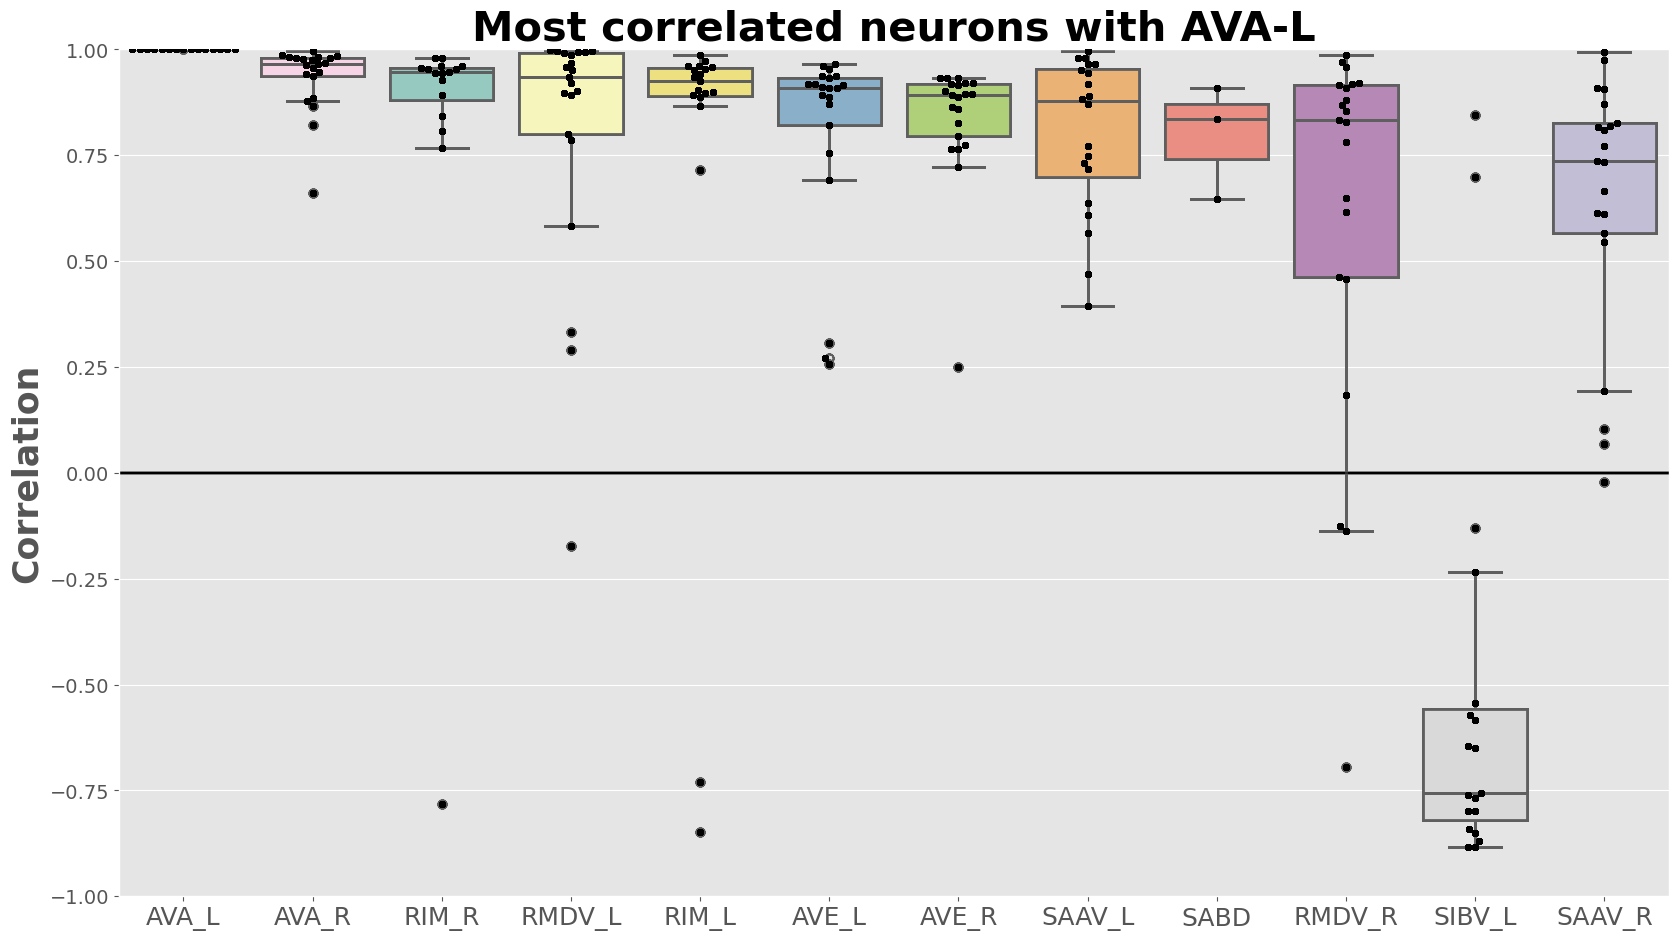

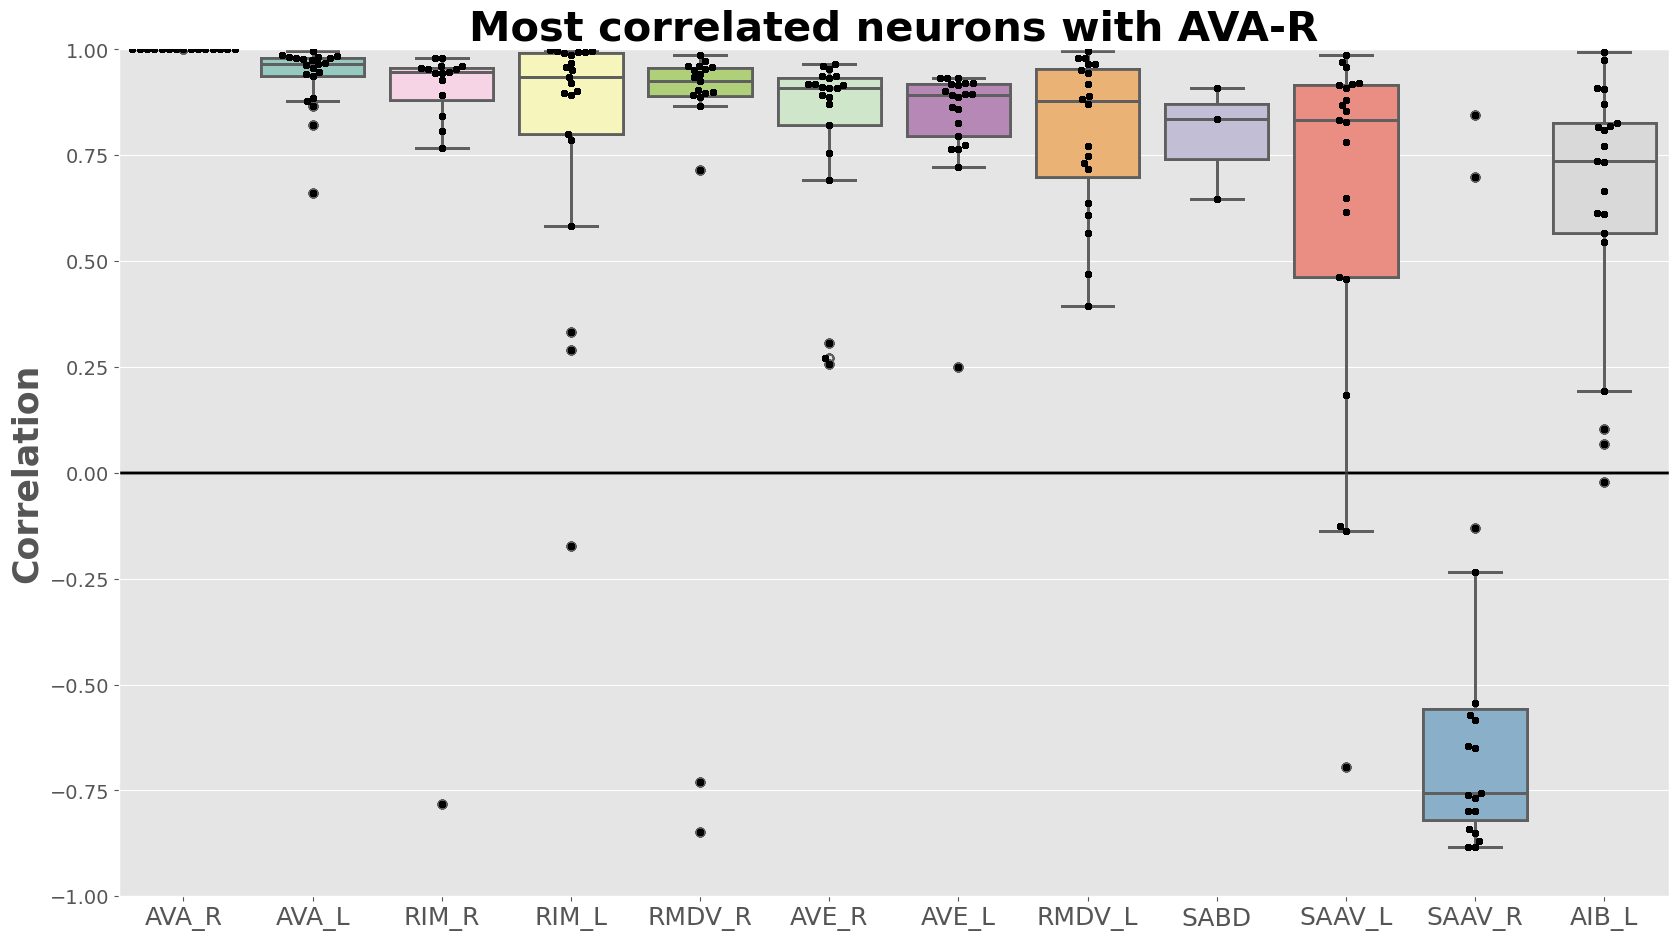

In [627]:
# This is plotting the top 10
dF_L = pd.DataFrame(top10_rank_AVA_L.T, columns=top10_rank_AVA_L_names) #make a pandas dataframe-easier for plotting
#Notice that I used .T, that transposes things to make them inverted (I have no idea why, but plotting boxplots 
#makes things inverted for some reason...)
#print(dF_L)

plt.style.use("ggplot") #to have plot look more like ggplot2 in R
colors_0 = sns.color_palette("Set3") #If you look up 'matplotlib colormap reference' you can find a list of options
colors_0= random.sample(colors_0, len(colors_0))
colors_1 = random.sample(colors_0, len(colors_0))

fig, ax = plt.subplots(1,1, figsize=(20, 11), facecolor='w') #this establishes the plotting
for i in top10_rank_AVA_L.T: #this is for plotting the connecting lines, normally you don't need to loop to plot
    ax.set_title('Most correlated neurons with AVA-L', fontsize=30, weight='bold') 
    sns.boxplot(data=dF_L, palette=colors_0, linewidth = 2) 
    sns.swarmplot(data=dF_L, size=5, color='black') 
    #ax.plot(i, alpha=0.5) #for plotting connecting lines - to look at trends of trials across neurons
    # plt.xticks(rotation=60) 
    ax.set_ylabel('Correlation', fontsize=25, weight='bold')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.axhline(y=0, color='black', alpha=0.5)
    ax.set_ylim([-1,1])
   # plt.axhline(y=0, color='black', alpha=0.5) #I drew a black line for number 0 because that shows no correlation
    # plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/031424_AVA_L_Ranked_Correlations.png', dpi = 900)


# Repeat the same things for ASJ R    
dF_R = pd.DataFrame(top10_rank_AVA_R.T, columns=top10_rank_AVA_R_names)
#print(dF_R)

plt.style.use("ggplot") #to have plot look more like ggplot2 in R

fig, ax = plt.subplots(1,1, figsize=(20,11), facecolor='w')
for i in top10_rank_AVA_R.T:
    ax.set_title('Most correlated neurons with AVA-R', fontsize=30, weight='bold')
    sns.boxplot(data=dF_R, palette=colors_1, linewidth = 2)
    sns.swarmplot(data=dF_R, size=5, color='black')
    #ax.plot(i, alpha=0.5)
    # plt.xticks(rotation=60)
    ax.set_ylabel('Correlation', fontsize=25, weight='bold')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_ylim([-1,1])
    plt.axhline(y=0, color='black', alpha=0.5)
    # plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/031424_AVA_R_Ranked_Correlations.png', dpi = 900)

/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 94.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 94.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 29.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


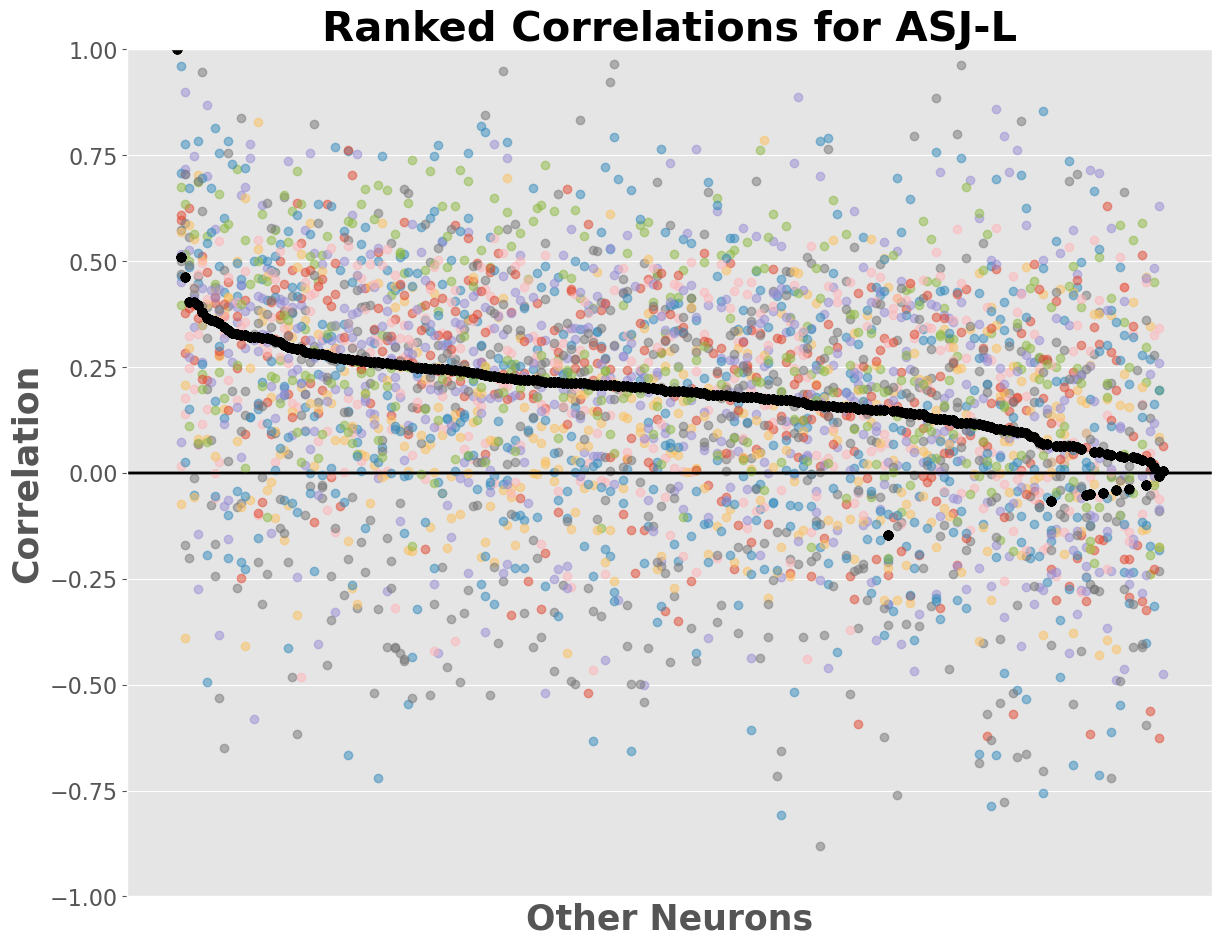

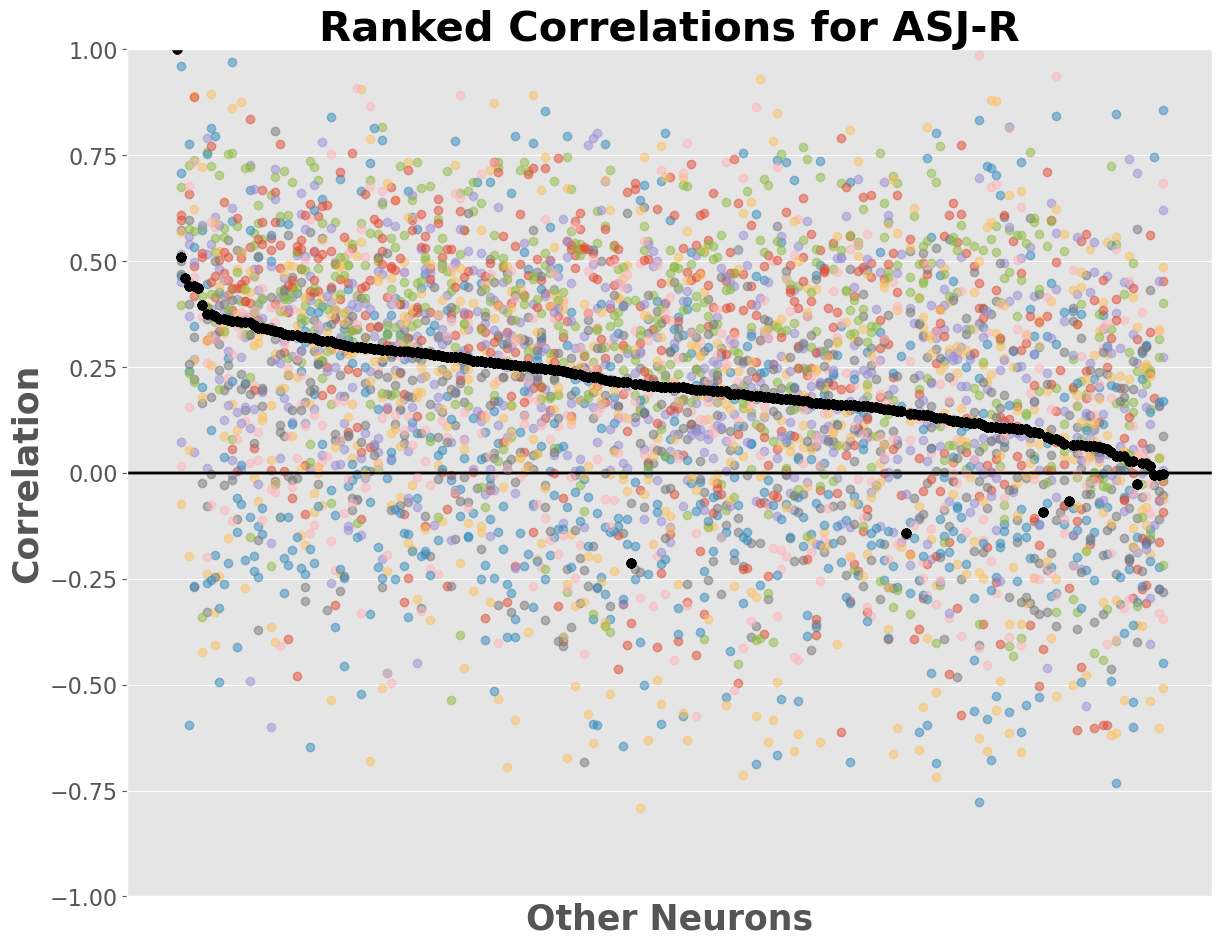

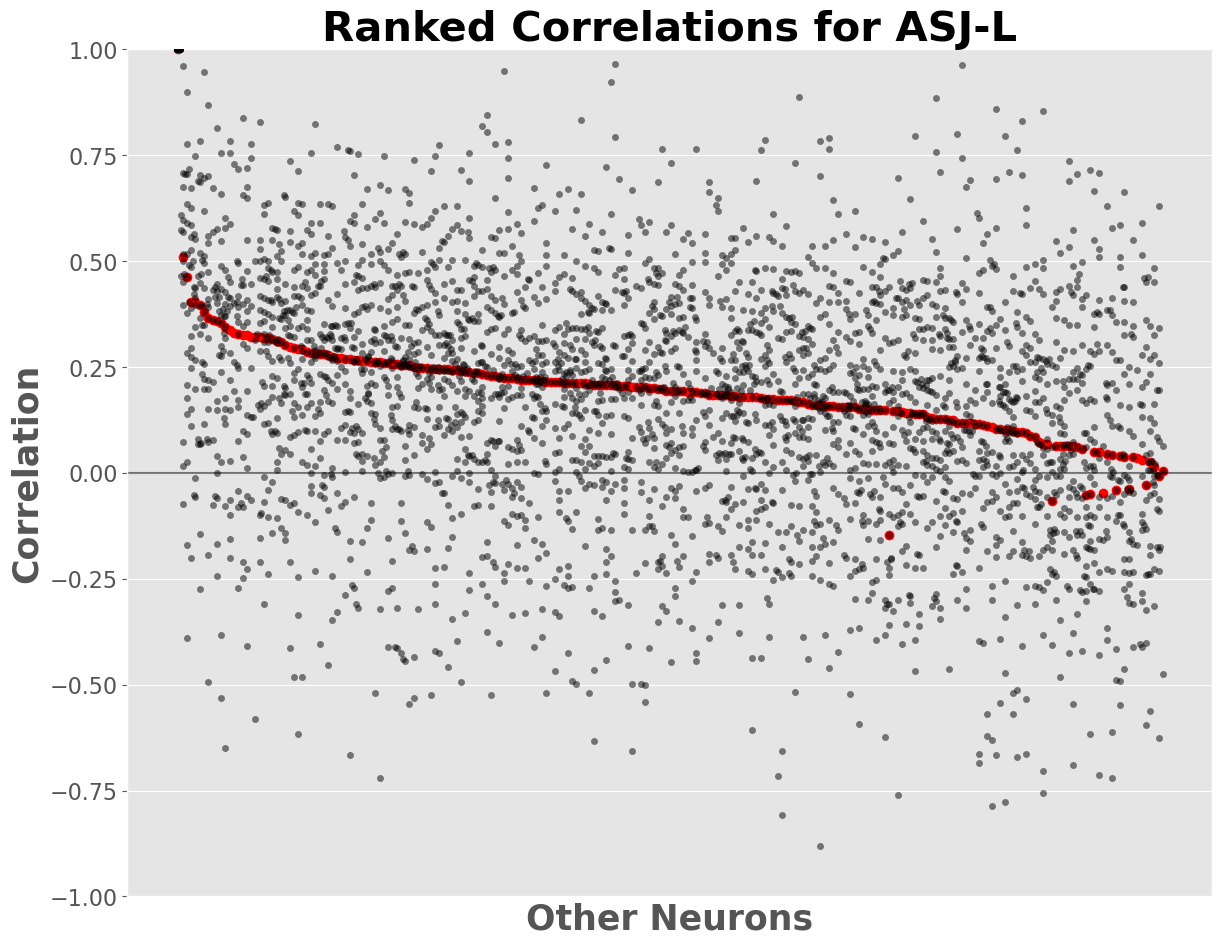

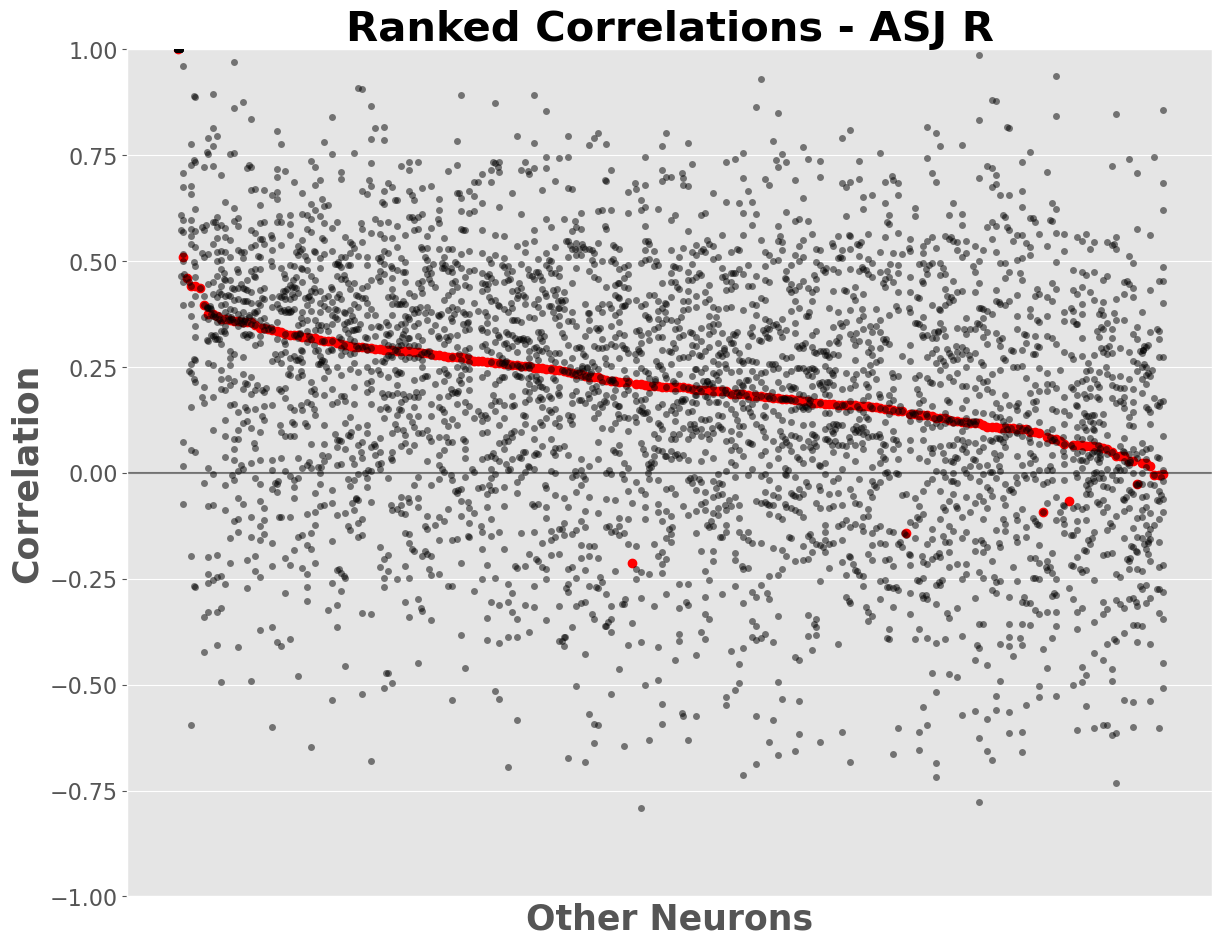

In [628]:
# This is plotting ALL the correlations, and I added the medians as a red color to show
# COLORFUL VERSION
plt.style.use("ggplot") #to have plot look more like ggplot2 in R

count=1
fig, ax = plt.subplots(1,1, figsize=(14,11), facecolor='w') #this establishes the plotting
for i in rank_ASJ_L.T:
    ax.set_title('Ranked Correlations for ASJ-L', fontsize=30, weight='bold') #title
    #sns.swarmplot(data=dF_ALL_L, alpha=0) #plot each individual trial dot using swarmplot
    ax.plot(rank_ASJ_L_names, rank_ASJ_L_meds, 'o', color='black') #this is plotting the medians
    ax.plot(rank_ASJ_L_names, i,'o', alpha=0.5, label = count) 
    ax.set_ylabel('Correlation', fontsize=25, weight='bold')
    ax.set_xlabel('Other Neurons', fontsize=25, weight='bold')
    ax.set_xticks([])    
    ax.tick_params(axis= 'y', labelsize=16)
    ax.set_ylim([-1,1])
    plt.axhline(y=0, color='black', alpha=0.5) 
    count += 1
    #plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/031424_ASJ_L_Ranked_Correlations.png') #here you can save your figure
 
# Repeat the same things for ASJ R    
#print(dF_R)
count=1
fig, ax = plt.subplots(1,1, figsize=(14,11), facecolor='w')
for i in rank_ASJ_R.T:
    ax.set_title('Ranked Correlations for ASJ-R', fontsize=30, weight='bold')
    ax.plot(rank_ASJ_R_names, i,'o', alpha=0.5, label = count)
    ax.plot(rank_ASJ_R_names, rank_ASJ_R_meds, 'o', color='black') #this is plotting the medians
    ax.set_ylabel('Correlation', fontsize=25, weight='bold')
    ax.set_xlabel('Other Neurons', fontsize=25, weight='bold')
    ax.set_xticks([])
    ax.tick_params(axis= 'y', labelsize=16)
    ax.set_ylim([-1,1])
    plt.axhline(y=0, color='black', alpha=0.5)
    count += 1
    #plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/031424_ASJ_R_Ranked_Correlations.png')

# This is plotting ALL the correlations, and I added the medians as a red color to show
# BLACK/RED VERSION

dF_ALL_L = pd.DataFrame(rank_ASJ_L.T, columns=rank_ASJ_L_names) #make a pandas dataframe-easier for plotting
#Notice that I used .T, that transposes things to make them inverted (I have no idea why, but plotting boxplots 
#makes things inverted for some reason...)
#print(dF_L)
fig, ax = plt.subplots(1,1, figsize=(14,11), facecolor='w')
ax.set_title('Ranked Correlations for ASJ-L', fontsize=30, weight='bold')
sns.swarmplot(data=dF_ALL_L, color='black', alpha=0.5)
ax.plot(rank_ASJ_L_names, rank_ASJ_L_meds, 'o', color='red') #this is plotting the medians
ax.set_ylabel('Correlation', fontsize=25, weight='bold')
ax.set_xlabel('Other Neurons', fontsize=25, weight='bold')
ax.set_xticks([])
ax.tick_params(axis= 'y', labelsize=16)
ax.set_ylim([-1,1])
plt.axhline(y=0, color='black', alpha=0.5)
#plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/031424_ASJ_L_Ranked_Correlations.png') #here you can save your figure

# Repeat the same things for ASJ R    
dF_ALL_R = pd.DataFrame(rank_ASJ_R.T, columns=rank_ASJ_R_names)
#print(dF_R)

fig, ax = plt.subplots(1,1, figsize=(14,11), facecolor='w')
ax.set_title('Ranked Correlations - ASJ R', fontsize=30, weight='bold')
sns.swarmplot(data=dF_ALL_R, color='black', alpha=0.5)
ax.plot(rank_ASJ_R_names, rank_ASJ_R_meds, 'o', color='red') #this is plotting the medians
ax.set_ylabel('Correlation', fontsize=25, weight='bold')
ax.set_xlabel('Other Neurons', fontsize=25, weight='bold')
ax.set_xticks([])
ax.yaxis.set_tick_params(labelsize=16)
ax.set_ylim([-1,1])
plt.axhline(y=0, color='black', alpha=0.5)
#plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/031424_ASJ_R_Ranked_Correlations.png')
    

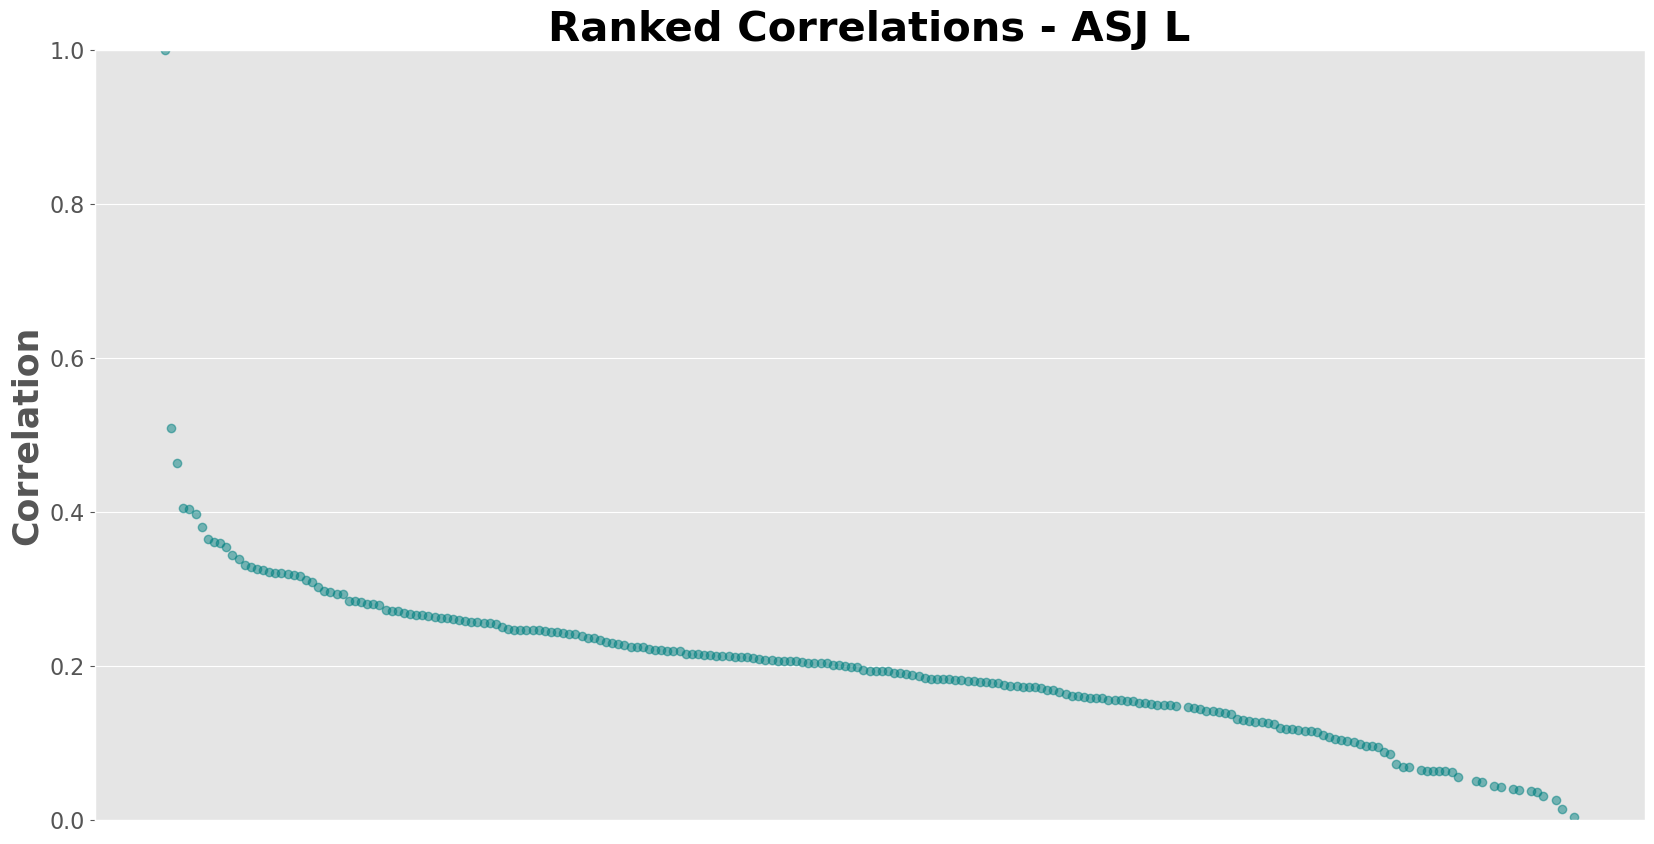

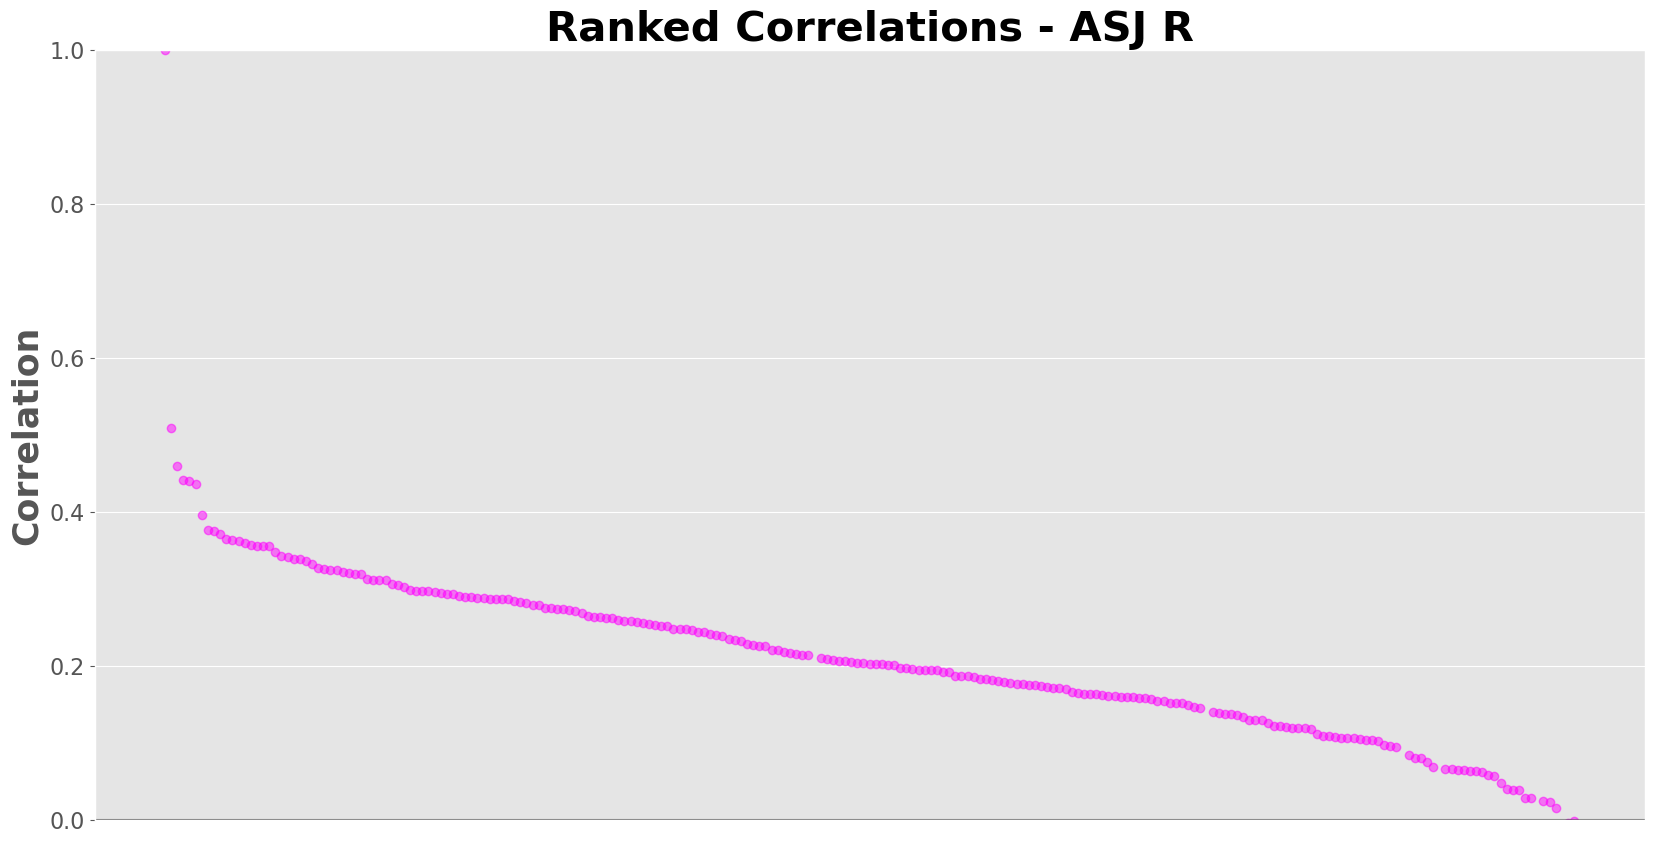

In [13]:
## This is just plotting the absolute value medians ##

fig, ax = plt.subplots(1,1, figsize=(20,10), facecolor='w') #this establishes the plotting
ax.set_title('Ranked Correlations - ASJ L', fontsize=30, weight='bold') #title
ax.plot(rank_ASJ_L_names, rank_ASJ_L_meds, 'o', color='teal', alpha=0.5)
ax.set_ylabel('Correlation', fontsize=25, weight='bold')
ax.tick_params(axis= 'y', labelsize=16)
ax.set_xticks([])
ax.set_ylim([0,1])
#plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/031424_ASJ_L_Ranked_Correlations.png') #here you can save your figure

fig, ax = plt.subplots(1,1, figsize=(20,10), facecolor='w')
ax.set_title('Ranked Correlations - ASJ R', fontsize=30, weight='bold')
ax.plot(rank_ASJ_R_names, rank_ASJ_R_meds, 'o', color='fuchsia', alpha=0.5)
ax.set_ylabel('Correlation', fontsize=25, weight='bold')
ax.tick_params(axis= 'y', labelsize=16)
ax.set_xticks([])
ax.set_ylim([0,1])
plt.axhline(y=0, color='black', alpha=0.5)
#plt.savefig('Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots//031424_ASJ_R_Ranked_Correlations.png')
    

In [162]:
# Here I wanted to color-code the stimuli that was delivered since it is randomized 
# This will help you organize the data based on stimuli that was delivered

print(head1['stims'])
# 1 = butanone = paleturquoise
# 2 = pentanedione = pink
# 3 = NaCl = yellow

color1 = []
color2 = []
color3 = []

for i in head1['stims']:
    if i[0] == 1:
        color1.append('paleturquoise')
    if i[0] == 2:
        color1.append('pink')
    if i[0] == 3:
        color1.append('yellow')
        
    if i[1] == 1:
        color2.append('paleturquoise')
    if i[1] == 2:
        color2.append('pink')
    if i[1] == 3:
        color2.append('yellow')
        
    if i[2] == 1:
        color3.append('paleturquoise')
    if i[2] == 2:
        color3.append('pink')
    if i[2] == 3:
        color3.append('yellow')

print(type(head1))

[[2 1 3]
 [2 1 3]
 [2 1 3]
 [2 1 3]
 [2 1 3]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [3 2 1]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [1 3 2]
 [2 1 3]
 [1 3 2]
 [1 3 2]
 [2 1 3]]
<class 'dict'>


In [163]:
cmap = plt.get_cmap('nipy_spectral') #this is a colormap, you can look up 'matplotlib colormap reference' to find more, for coloring by trial
count = 0
for i in range(0,21): #21 is because there's 21 trials
    fig, axs = plt.subplots(1,2, figsize=(15,6), facecolor='w')
    ax1 = axs[0]
    ax2 = axs[1]

    ax1.set_title(f"Trial {i+1} ASJ-Left", fontweight="bold") #added one to index as Python indexes at 0
    ax1.plot(ASJ_L[i], color = cmap(i*12))  #to get a wider variety of colors, I multiplied by 12
    ax1.axvspan(242, 282, facecolor=color1[i], alpha = 0.5) #duration of stimulus pulse
    ax1.axvspan(482, 522, facecolor=color2[i], alpha = 0.5) 
    ax1.axvspan(722, 802, facecolor=color3[i], alpha = 0.5)
    ax1.set_xlabel("Frames") #4 sec per frame, so 63.66 minutes total recording time 
    ax1.set_ylabel("Fluorescence Intensity (z-score)")
    
    ax2.set_title(f"Trial {i+1} ASJ-Right", fontweight="bold")
    ax2.plot(ASJ_R[i], color = cmap(i*12))
    ax2.axvspan(242, 282, facecolor=color1[i], alpha = 0.5) 
    ax2.axvspan(482, 522, facecolor=color2[i], alpha = 0.5)
    ax2.axvspan(722, 802, facecolor=color3[i], alpha = 0.5)
    ax2.set_xlabel("Frames")
    ax2.set_ylabel("Fluorescence Intensity (z-score)")
    count += 1

    plt.close()

In [14]:
# to find out frame times I converted seconds to frames
# second (x) * 4 = frame (y)
# I got the number 4 because it was the frames per second they said
# You can find out frames per second by: mat1['fps']
# This was useful because in mat1['stim_times'] they list what SECOND times they pulsed stimuli
# So I had to figure out what FRAME time I needed to color-code
# For example, 60.5 second stimulus pulse equals 242 frames (see below numbers for ax.axvspan, 242-282)

In [15]:
#print(len(ASJ_L))
# 21 trials
#print(len(ASJ_L[0]))
# 955 frames per trial
#print(ASJ_L[0][0:242])

# 1 = butanone = paleturquoise
# 2 = pentanedione = pink
# 3 = NaCl = yellow

<font color='lightgreen' size = 12>Lance's Code</font>

In [666]:
### Function to extract all stimuli-specific traces for a specified neuron ###
def NeuronList_stimuli(data, neuron, left_right): 
    
    stimulus_indices = {1: [], 2: [], 3: []}

    for trial_index, trial in enumerate(data['stims']):
        for stimulus_index, stimulus in enumerate(trial):
            stimulus_indices[stimulus].append((trial_index, stimulus_index))

    stimulus_intervals = [(232, 482), (472, 722), (712, 955)]
    neuron_data = {}
    
    if left_right == 'left':
    
        neuron_L = LR_Traces(data, neuron, left_right) 

        neuron_data[f'{neuron}_L_control'] = [traces[:232] for traces in neuron_L]
        
        neuron_data[f'{neuron}_L_butanone'] = []
        neuron_data[f'{neuron}_L_pentanedione'] = []
        neuron_data[f'{neuron}_L_NaCl'] = []
    
        for stimulus, indices in stimulus_indices.items():
            for trial_index, stimulus_index in indices:
                start, end = stimulus_intervals[stimulus_index]
                if stimulus == 1:
                    neuron_data[f'{neuron}_L_butanone'].append(neuron_L[trial_index][start:end])
                elif stimulus == 2:
                    neuron_data[f'{neuron}_L_pentanedione'].append(neuron_L[trial_index][start:end])
                elif stimulus == 3:
                    neuron_data[f'{neuron}_L_NaCl'].append(neuron_L[trial_index][start:end])
    
        neuron_data[f'{neuron}_stimuli_list_L'] = [neuron_data[f'{neuron}_L_control'], neuron_data[f'{neuron}_L_butanone'], neuron_data[f'{neuron}_L_pentanedione'], neuron_data[f'{neuron}_L_NaCl']]
        return neuron_data[f'{neuron}_stimuli_list_L']
    
    if left_right == 'right':
    
        neuron_R = LR_Traces(data, neuron, left_right)

        neuron_data[f'{neuron}_R_control'] = [traces[:232] for traces in neuron_R]
    
        neuron_data[f'{neuron}_R_butanone'] = []
        neuron_data[f'{neuron}_R_pentanedione'] = []
        neuron_data[f'{neuron}_R_NaCl'] = []

        for stimulus, indices in stimulus_indices.items():
            for trial_index, stimulus_index in indices:
                start, end = stimulus_intervals[stimulus_index]
                if stimulus == 1:
                    neuron_data[f'{neuron}_R_butanone'].append(neuron_R[trial_index][start:end])
                elif stimulus == 2:
                    neuron_data[f'{neuron}_R_pentanedione'].append(neuron_R[trial_index][start:end])
                elif stimulus == 3:
                    neuron_data[f'{neuron}_R_NaCl'].append(neuron_R[trial_index][start:end])

        neuron_data[f'{neuron}_stimuli_list_R'] = [neuron_data[f'{neuron}_R_control'], neuron_data[f'{neuron}_R_butanone'], neuron_data[f'{neuron}_R_pentanedione'], neuron_data[f'{neuron}_R_NaCl']]
        return neuron_data[f'{neuron}_stimuli_list_R']

ASJ_stimuli_list_L = NeuronList_stimuli(head1, 'ASJ', 'left')
ASJ_stimuli_list_R = NeuronList_stimuli(head1, 'ASJ', 'right')

#print(len(AIA_stimuli_list_L[0:]))
# 4 lists for AIA L
#print(len(AIA_stimuli_list_L[0]))
# 21 trials for control
#print(len(AIA_stimuli_list_L[0][0]))
# 232 frames for control, 

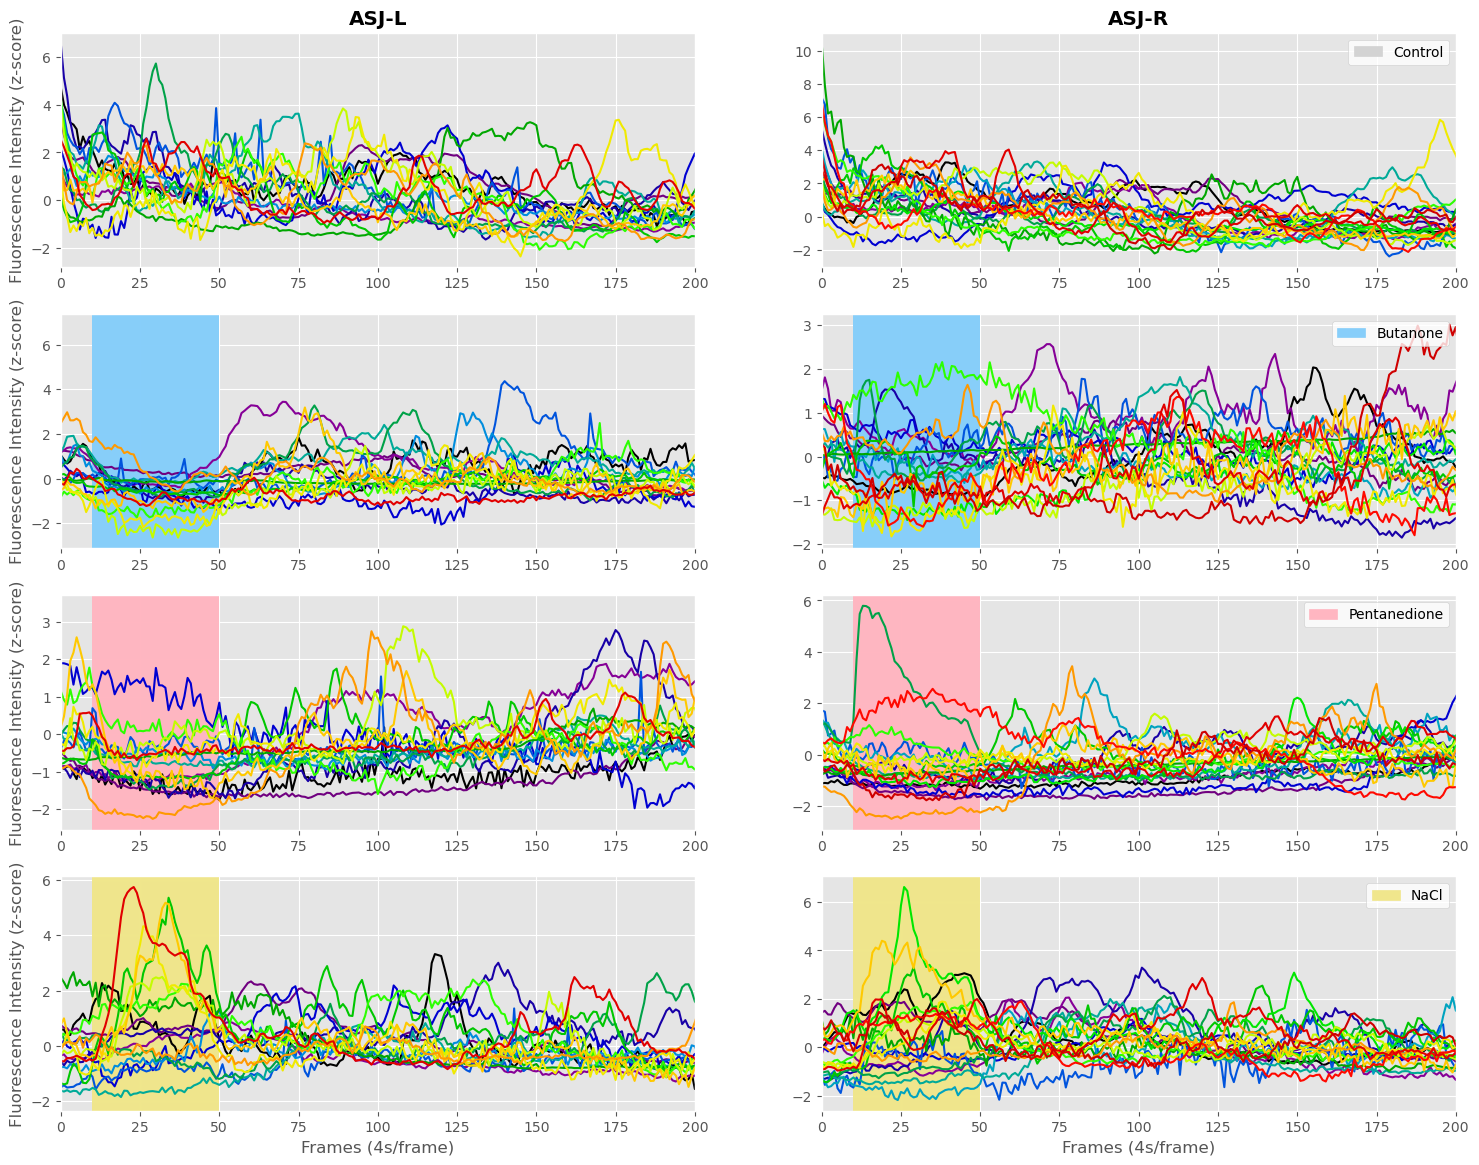

In [667]:
 ### Creating a plotting function to plot by stimuli for a specified neuron ###

def NeuronPlot_stimuli(neuron_stimuli_list_L, neuron_stimuli_list_R, title_L, title_R):    
    
    plt.style.use("ggplot") #to have plot look more like ggplot2 in R

    cmap = plt.get_cmap('nipy_spectral') #this is a colormap, you can look up 'matplotlib colormap reference' to find more, for coloring by trial

    fig, axs = plt.subplots(4,2, figsize=(18,14), facecolor='w')
    ax1 = axs[0,0]
    ax2 = axs[0,1]
    ax3 = axs[1,0]
    ax4 = axs[1,1]
    ax5 = axs[2,0]
    ax6 = axs[2,1]
    ax7 = axs[3,0]
    ax8 = axs[3,1]

    ax1.set_title(f"{title_L}", fontweight="bold") 
    ax2.set_title(f"{title_R}", fontweight="bold")

    ax7.set_xlabel("Frames (4s/frame)") 
    ax8.set_xlabel("Frames (4s/frame)")

    ax1.set_ylabel("Fluorescence Intensity (z-score)")
    ax3.set_ylabel("Fluorescence Intensity (z-score)")
    ax5.set_ylabel("Fluorescence Intensity (z-score)")
    ax7.set_ylabel("Fluorescence Intensity (z-score)")

    for i in range(0,21): 
        ax1.plot(neuron_stimuli_list_L[0][i], color = cmap(i*12))
        ax1.set_xlim(0, 200)

        ax2.plot(neuron_stimuli_list_R[0][i], color = cmap(i*12))
        ax2.set_xlim(0, 200)
        
        ax3.plot(neuron_stimuli_list_L[1][i], color = cmap(i*12)) 
        ax3.axvspan(10, 50, facecolor='lightskyblue', alpha = 0.5) 
        ax3.set_xlim(0, 200)

        ax4.plot(neuron_stimuli_list_R[1][i], color = cmap(i*12))
        ax4.axvspan(10, 50, facecolor='lightskyblue', alpha = 0.5) 
        ax4.set_xlim(0, 200)
        
        ax5.plot(neuron_stimuli_list_L[2][i], color = cmap(i*12))
        ax5.axvspan(10, 50, facecolor='lightpink', alpha = 0.5) 
        ax5.set_xlim(0, 200)

        ax6.plot(neuron_stimuli_list_R[2][i], color = cmap(i*12))
        ax6.axvspan(10, 50, facecolor='lightpink', alpha = 0.5)
        ax6.set_xlim(0, 200)

        ax7.plot(neuron_stimuli_list_L[3][i], color = cmap(i*12))
        ax7.axvspan(10, 50, facecolor='khaki', alpha = 0.5)
        ax7.set_xlim(0, 200)

        ax8.plot(neuron_stimuli_list_R[3][i], color = cmap(i*12))
        ax8.axvspan(10, 50, facecolor='khaki', alpha = 0.5)
        ax8.set_xlim(0, 200)

    patch1 = mpatches.Patch(color='lightskyblue', label='Butanone')
    patch2 = mpatches.Patch(color='lightpink', label='Pentanedione')
    patch3 = mpatches.Patch(color='khaki', label='NaCl')
    patch4 = mpatches.Patch(color='lightgrey', label='Control')

    ax2.legend(handles=[patch4], loc='upper right', facecolor = 'white')
    ax4.legend(handles=[patch1], loc='upper right', facecolor = 'white')
    ax6.legend(handles=[patch2], loc='upper right', facecolor = 'white')
    ax8.legend(handles=[patch3], loc='upper right', facecolor = 'white')

    # plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/ASJ_L_R_ExposureTraces.png', dpi = 900)

    return plt.show()   

ASJ_test_plot = NeuronPlot_stimuli(ASJ_stimuli_list_L, ASJ_stimuli_list_R, 'ASJ-L', 'ASJ-R')


In [26]:
print(len(head1['neurons']))
print(len(head1['stims']))
print(len(head1['stims'][0]))
print(len(head1['traces'][0][0][0]))   
print(len(head1['is_L'][0][0][0]))
print(len(head1['is_L'][0][0]))
print((head1['is_L'][0][0]))

109
21
3
42
42
1
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0]]


<font color='skyblue' size = 10>Plot ASJ correlation by stimulus</font>

<font color='red' size = 6>Function to isolate stimuli-specific traces for an individual neuron</font>

In [27]:
def NeuronList_stimuli(data, neuron, left_right): 
    
    stimulus_indices = {1: [], 2: [], 3: []}

    for trial_index, trial in enumerate(data['stims']):
        for stimulus_index, stimulus in enumerate(trial):
            stimulus_indices[stimulus].append((trial_index, stimulus_index))

    stimulus_intervals = [(232, 482), (472, 722), (712, 955)]
    neuron_data = {}
    
    if left_right == 'left':
    
        neuron_L = LR_Traces(data, neuron, left_right) 

        neuron_data[f'{neuron}_L_control'] = [traces[:232] for traces in neuron_L]
        
        neuron_data[f'{neuron}_L_butanone'] = []
        neuron_data[f'{neuron}_L_pentanedione'] = []
        neuron_data[f'{neuron}_L_NaCl'] = []
    
        for stimulus, indices in stimulus_indices.items():
            for trial_index, stimulus_index in indices:
                start, end = stimulus_intervals[stimulus_index]
                if stimulus == 1:
                    neuron_data[f'{neuron}_L_butanone'].append(neuron_L[trial_index][start:end])
                elif stimulus == 2:
                    neuron_data[f'{neuron}_L_pentanedione'].append(neuron_L[trial_index][start:end])
                elif stimulus == 3:
                    neuron_data[f'{neuron}_L_NaCl'].append(neuron_L[trial_index][start:end])
    
        neuron_data[f'{neuron}_stimuli_list_L'] = [neuron_data[f'{neuron}_L_control'], neuron_data[f'{neuron}_L_butanone'], neuron_data[f'{neuron}_L_pentanedione'], neuron_data[f'{neuron}_L_NaCl']]
        return neuron_data[f'{neuron}_stimuli_list_L']
    
    if left_right == 'right':
    
        neuron_R = LR_Traces(data, neuron, left_right)

        neuron_data[f'{neuron}_R_control'] = [traces[:232] for traces in neuron_R]
    
        neuron_data[f'{neuron}_R_butanone'] = []
        neuron_data[f'{neuron}_R_pentanedione'] = []
        neuron_data[f'{neuron}_R_NaCl'] = []

        for stimulus, indices in stimulus_indices.items():
            for trial_index, stimulus_index in indices:
                start, end = stimulus_intervals[stimulus_index]
                if stimulus == 1:
                    neuron_data[f'{neuron}_R_butanone'].append(neuron_R[trial_index][start:end])
                elif stimulus == 2:
                    neuron_data[f'{neuron}_R_pentanedione'].append(neuron_R[trial_index][start:end])
                elif stimulus == 3:
                    neuron_data[f'{neuron}_R_NaCl'].append(neuron_R[trial_index][start:end])

        neuron_data[f'{neuron}_stimuli_list_R'] = [neuron_data[f'{neuron}_R_control'], neuron_data[f'{neuron}_R_butanone'], neuron_data[f'{neuron}_R_pentanedione'], neuron_data[f'{neuron}_R_NaCl']]
        return neuron_data[f'{neuron}_stimuli_list_R']

ASJ_stimuli_list_L = NeuronList_stimuli(head1, 'ASJ', 'left')
ASJ_stimuli_list_R = NeuronList_stimuli(head1, 'ASJ', 'right')

<font color='red' size = 6>Function to isolate all traces and indexed stimuli data for all neurons</font>

In [28]:
## WHEN  RUNNING KERNEL WITH OLD NUMPY ###
def OtherNeurons(heads_or_tails, names_or_tracesStimuli): #this will make a master list of the neuron names and their traces
    if heads_or_tails == 'heads': #you can choose which dataset you want, heads or tails
        data_file = head1
    if heads_or_tails == 'tails':
        data_file = tail1
        
    names_temp = [] 
    traces_temp = []

    for i in range(len(data_file['neurons'])): 

        name = data_file['neurons'][i][0][0] #the files are in dictionary format, so you have to index, and then extract the first value of the nested list
        trace = data_file['traces'][i][0][0] 
        is_L = data_file['is_L'][i][0][0] 

        for j in range(0,len(is_L)):  
            if is_L[j] == 1: # 1 = Left neuron
                names_temp.append(name + '_L') #here you can add the letter 'L' to the end of the name
                traces_temp.append(trace[j][0][4:-1]) #exclude nans, which are 4 nans in beginning, 1 nan at end
                #print(len(trace[i][0][4:-1]))

            if is_L[j] == 0: # 0 = Right neuron
                names_temp.append(name + '_R')
                traces_temp.append(trace[j][0][4:-1])
            if np.isnan(is_L[j]): # nans = no left or right neuron
                names_temp.append(name) 
                traces_temp.append(trace[j][0][4:-1])

    names = [] #want to remove the duplicates
    for i in names_temp: # the names_temp basically looks like 'neuronL','neuronL','neuronL', etc and 'neuronR','neuronR'
        if i not in names: 
            names.append(i) #saving unique names to list 'names' from list 'names_temp'

    traces = np.reshape(traces_temp,(len(names), 21))

    #Transpose the traces array so that each row is a trial and each column is a neuron
    traces = np.transpose(traces)
    traces = traces.tolist()

    #Convert stims to a list of lists
    stims = [list(item) for item in head1['stims']]

    #Append stims to the end of each row in traces
    traces = [row + [stim] for row, stim in zip(traces, stims)]

    #Convert traces back to a numpy array
    final = np.array(traces)

    if names_or_tracesStimuli == 'names': #here you can choose whether you want the list of names or the traces data
        return names
    if names_or_tracesStimuli == 'traces_and_stimuli':
        return final

head_names = OtherNeurons('heads', 'names')
head_tracesAndStimuli = OtherNeurons('heads', 'traces_and_stimuli')

tail_names = OtherNeurons('tails', 'names')
tail_tracesAndStimuli = OtherNeurons('tails', 'traces_and_stimuli')

# print(len(head_tracesAndStimuli)) #21 trials, corresponding to the 21 rows
# print(len(head_tracesAndStimuli[0])) #189 neurons per trial, and the list of stimuli for that trial appended at the end, resulting in 190 columns
# print(len(head_tracesAndStimuli[0][0])) #955 frames per neuron trace
print(head_tracesAndStimuli[0][-1]) #the stimuli list is the last column, so you can index it with [i][-1] to get the stimuli for that trial

all_names = head_names+tail_names

[2, 1, 3]


/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/3299812450.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final = np.array(traces)


<font color='red' size = 6>Function to isolate stimuli-specific traces for all other neurons</font>

In [29]:
def OTHERNeuronList_stimuli(data): 
    
    stimulus_indices = {1: [], 2: [], 3: []}
    
    #Create a dictionary with the stimulus as the key, and then the trial number and stimulus index as the value
    for trial_index, trial in enumerate(data):
        for stimulus_index, stimulus in enumerate(trial[-1]): #the last column is the stimuli list
            stimulus_indices[stimulus].append((trial_index, stimulus_index))
    #print(stimulus_indices)

    #Initialize the intervals for each stimulus
    stimulus_intervals = [(232, 482), (472, 722), (712, 955)]
    neuron_data = {}
                             
    neuron_data['control'] = [[trace[:232] for trace in trial[:-1]] for trial in data] #outer loop iterates over trials, inner loop iterates over neurons, excluding the last column with  the stimuli list
    neuron_data['butanone'] = []
    neuron_data['pentanedione'] = []
    neuron_data['NaCl'] = []

    for stimulus, indices in stimulus_indices.items(): #iterates ove the keys=stimuli, and the indices=trial number and stimulus index
        for trial_index, stimulus_index in indices: #unpacks the tuples (indices) into trial number and stimulus index
            start, end = stimulus_intervals[stimulus_index] #extracts the start and end frames based on the stimulus and defined intervales "stimulus_intervals"
            if stimulus == 1:
                neuron_data['butanone'].append([data[trial_index][neuron_index][start:end] for neuron_index in range(len(data[trial_index])-1)]) # "-1" to exclude the last column with the stimuli array
            if stimulus == 2:
                neuron_data['pentanedione'].append([data[trial_index][neuron_index][start:end] for neuron_index in range(len(data[trial_index])-1)])
            if stimulus == 3:
                neuron_data['NaCl'].append([data[trial_index][neuron_index][start:end] for neuron_index in range(len(data[trial_index])-1)])
    
    #Concatenate all stimuli lists into one nested list
    neuron_data['stimuli_list'] = [neuron_data['control'], neuron_data['butanone'], neuron_data['pentanedione'], neuron_data['NaCl']]
    return neuron_data['stimuli_list']
    

OTHERneurons_stimuli_Head = OTHERNeuronList_stimuli(head_tracesAndStimuli)
OTHERneurons_stimuli_Tail = OTHERNeuronList_stimuli(tail_tracesAndStimuli)

# print(len(OTHERneurons_stimuli_Head)) #4 lists for each stimulus
# print(len(OTHERneurons_stimuli_Head[2])) #21 trials for pentanedione stimulus
# print(len(OTHERneurons_stimuli_Head[2][0])) # 189 - for 189 neurons
# print(OTHERneurons_stimuli_Head[2][0][0][0]) # first trace for neuron 1 for trial 1 for pentanedione stimulus
# print(OTHERneurons_stimuli_Head[0][5][2][0]) # first trace for neuron 3 in trial 6, stimulus control
# print(len(OTHERneurons_stimuli_Head[1][0][0])) #250 traces for Butanone stiumulus
# print(len(OTHERneurons_stimuli_Head[2][0][0])) #250 traces for pentanedione stiumulus
# print(len(OTHERneurons_stimuli_Head[3][0][0])) #243 traces for NaCl stiumulus


<font color='red' size = 6>Function to calculate correlation of ASJ neuron with all other neurons</font>

In [30]:
def CorrelateAlltoASJ(neurons, ASJ_neuron): #'neuron' is the list of all other neurons, ASJ_neuron is ASJ L or R
    num_stimuli, num_trials, num_neurons = len(neurons), len(neurons[0]), len(neurons[0][0])
    #print(num_stimuli, num_trials, num_neurons)
    correlations = np.full((num_stimuli, num_neurons, num_trials), np.nan)

    for s in range(num_stimuli): #loop through each stimulus (4)
        for t in range(num_trials): #loop through each of the 21 trials
            for n in range(num_neurons): #loop through each neuron
                try:
                    length = min(len(neurons[s][t][n]), len(ASJ_neuron[s][t])) #find the minimum length of the two traces (s - stimuli, t - trial, n - neuron)
                    corr = np.corrcoef(neurons[s][t][n][:length], ASJ_neuron[s][t][:length])
                    correlations[s][n][t] = corr[0][1]

                except:
                    print(f"Error at stimulus {s}, trial {t}, neuron {n}")
                    continue 


    return correlations

### Correlating Other Neurons (head) to ASJ L
corr_head_ASJ_L = CorrelateAlltoASJ(OTHERneurons_stimuli_Head, ASJ_stimuli_list_L)
## Correlating Other Neurons (tail) to ASJ L
corr_tail_ASJ_L = CorrelateAlltoASJ(OTHERneurons_stimuli_Tail, ASJ_stimuli_list_L)
### Correlating Other Neurons (head) to ASJ R
corr_head_ASJ_R = CorrelateAlltoASJ(OTHERneurons_stimuli_Head, ASJ_stimuli_list_R)
### Correlating Other Neurons (tail) to ASJ R
corr_tail_ASJ_R = CorrelateAlltoASJ(OTHERneurons_stimuli_Tail, ASJ_stimuli_list_R)              

# print(len(corr_head_ASJ_L[1][10])) # 21 trials
# print(np.isnan(corr_head_ASJ_L[1][10]).sum()) # 9 NaN values for stimulus butanone, neuron 11 for all trials

# print(len(corr_tail_ASJ_R)) # 4 - for each stimuli
# print(len(corr_tail_ASJ_R[0])) # 42 neurons 
# print(corr_tail_ASJ_R[3][2][0]) # correlation value for stimulus NaCl, neuron 3 (index is 0), trial 1 (index is 0)
# print(corr_tail_ASJ_R[1][10]) # correlation value for stimulus butanone, neuron 11 for all trials


/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<font color='red' size = 6>Function to rank neurons based on their median correlation value across all trials</font>

In [31]:
def RankingByStimuli(array, names, analysis_variable):
    all_ranked = []
    all_names = []
    all_ranked_meds = []
    all_true_meds = []
    
    for j in range(len(array)): # Loop over each stimulus
        more_than_4_nan = 0
        medians = []
        true_medians = []
        for i in array[j]: # Loop over each neuron for the iterative stimulus
            num_nan = np.isnan(i).sum()
            if num_nan <= 4: # Check if the neuron has more than 4 NaN values
               # print(f"Number of NaN values for neuron: {num_nan}")
                med = np.nanmedian(i) # Calculate the median correlation value for the current neuron across all trials
                medians.append(abs(med))  
                true_medians.append(med) 
            else:
                more_than_4_nan += 1

        reverse_sort = sorted(medians, reverse=True) # Sort medians in descending order
        ranked = np.empty((len(medians), len(array[j][0])), dtype=object) # Initialize ranked array
        name = []
        ranked_meds = []
        absolute_meds = []

        for i in range(len(reverse_sort)): # Loop over sorted medians
            index = medians.index(reverse_sort[i]) # Get index of current median in original medians list
            ranked[i] = array[j][index] # Store neuron's correlation values in ranked array
            name.append(names[index]) # Store neuron's name
            ranked_meds.append(true_medians[index]) # Store neuron's median correlation
            absolute_meds.append(medians[index]) # Store neuron's absolute median correlation

        all_ranked.append(ranked)
        all_names.append(name)
        all_ranked_meds.append(ranked_meds)
        all_true_meds.append(true_medians)

    if analysis_variable == 'names':
        return all_names
    elif analysis_variable == 'correlations':
        return all_ranked
    elif analysis_variable == 'medians':
        return all_ranked_meds
    elif analysis_variable == 'true medians':
        return all_true_meds

corr_all_traces_L = np.concatenate((corr_head_ASJ_L, corr_tail_ASJ_L), axis = 1)
corr_all_traces_R = np.concatenate((corr_head_ASJ_R, corr_tail_ASJ_R), axis = 1)

### Ranking for ASJ L correlations with Other Neurons ###
Ranking_ASJ_L_corr = RankingByStimuli(corr_all_traces_L, all_names, 'correlations')
Ranking_ASJ_L_names = RankingByStimuli(corr_all_traces_L, all_names, 'names')
Ranking_ASJ_L_trueMedians = RankingByStimuli(corr_all_traces_L, all_names, 'true medians')

### Ranking for ASJ R correlations with Other Neurons ###
Ranking_ASJ_R_corr = RankingByStimuli(corr_all_traces_R, all_names, 'correlations')
Ranking_ASJ_R_names = RankingByStimuli(corr_all_traces_R, all_names, 'names')
Ranking_ASJ_R_trueMedians = RankingByStimuli(corr_all_traces_R, all_names, 'true medians')

# print(len(Ranking_ASJ_L_corr)) # 4 - for each stimuli
# print(len(Ranking_ASJ_L_corr[0])) # 150 neurons (ones with less than 4 NaN correlation values across all trials)
# print(len(Ranking_ASJ_L_corr[0][0])) # 21 trials
# print(Ranking_ASJ_L_corr[0][0][0:10]) # top 10 highest correlated neurons (values) for control stimulus for first trial
# print(Ranking_ASJ_L_corr[3][5][0:10]) # top 10 highest correlated neurons (values) for NaCl stimulus for 6th trial

# print(len(Ranking_ASJ_L_names)) # 4 - for each stimuli
# print(len(Ranking_ASJ_L_names[0])) # value is 150.... meaning only 150 neurons have less than 4 NaN values - 81 with more than 4 NaN values
# print(len(Ranking_ASJ_R_names[0])) # value is 194.... meaning only 194 neurons have less than 4 NaN values - 37 with more than 4 NaN values
# print(Ranking_ASJ_L_names[2]) # names of the 150 neurons that have less than 4 NaN values in the pentanedione stimulus
# print(Ranking_ASJ_L_names[0][0]) # highest correlated neuron for control stimulus for first trial

<font color='red' size = 6>Converting ranked correlated neurons into a dataframe and calculating the median correlation values for each neuron across all trials</font>

In [32]:
df_rank_ASJ_L_corrC = pd.DataFrame(list(map(list, zip(*Ranking_ASJ_L_corr[0]))), columns=Ranking_ASJ_L_names[0])
df_rank_ASJ_L_corrB = pd.DataFrame(list(map(list, zip(*Ranking_ASJ_L_corr[1]))), columns=Ranking_ASJ_L_names[1])
df_rank_ASJ_L_corrP = pd.DataFrame(list(map(list, zip(*Ranking_ASJ_L_corr[2]))), columns=Ranking_ASJ_L_names[2])
df_rank_ASJ_L_corrNaCl = pd.DataFrame(list(map(list, zip(*Ranking_ASJ_L_corr[3]))), columns=Ranking_ASJ_L_names[3])

df_rank_ASJ_R_corrC = pd.DataFrame(list(map(list, zip(*Ranking_ASJ_R_corr[0]))), columns=Ranking_ASJ_R_names[0])
df_rank_ASJ_R_corrB = pd.DataFrame(list(map(list, zip(*Ranking_ASJ_R_corr[1]))), columns=Ranking_ASJ_R_names[1])
df_rank_ASJ_R_corrP = pd.DataFrame(list(map(list, zip(*Ranking_ASJ_R_corr[2]))), columns=Ranking_ASJ_R_names[2])
df_rank_ASJ_R_corrNaCl = pd.DataFrame(list(map(list, zip(*Ranking_ASJ_R_corr[3]))), columns=Ranking_ASJ_R_names[3])

def reorder_columns_HighMedian(df):
    medians = df.median().sort_values(ascending=False).index #Calculate the median of each column and sort the columns by median
    df = df[medians] #Reorder the columns based on the sorted medians
    return df

Reorder_df_rank_ASJ_L_corrC = reorder_columns_HighMedian(df_rank_ASJ_L_corrC)
Reorder_df_rank_ASJ_L_corrB = reorder_columns_HighMedian(df_rank_ASJ_L_corrB)
Reorder_df_rank_ASJ_L_corrP = reorder_columns_HighMedian(df_rank_ASJ_L_corrP)
Reorder_df_rank_ASJ_L_corrNaCl = reorder_columns_HighMedian(df_rank_ASJ_L_corrNaCl)

Reorder_df_rank_ASJ_R_corrC = reorder_columns_HighMedian(df_rank_ASJ_R_corrC)
Reorder_df_rank_ASJ_R_corrB = reorder_columns_HighMedian(df_rank_ASJ_R_corrB)
Reorder_df_rank_ASJ_R_corrP = reorder_columns_HighMedian(df_rank_ASJ_R_corrP)
Reorder_df_rank_ASJ_R_corrNaCl = reorder_columns_HighMedian(df_rank_ASJ_R_corrNaCl)

print(Reorder_df_rank_ASJ_R_corrB.head(3))



### Filtering out neurons with more than 'X' NaN values across all trials ###
def filter_nan_cutoff(df, num_nan):
    df = df.loc[:, df.isnull().sum() <= num_nan] #only keep columns with less than or equal to 4 NaN values for their entire column (across all 21 rows)
    return df  

ReorderCutoff_df_rank_ASJ_L_corrC = filter_nan_cutoff(Reorder_df_rank_ASJ_L_corrC, 16) 
ReorderCutoff_df_rank_ASJ_R_corrC = filter_nan_cutoff(Reorder_df_rank_ASJ_R_corrC, 16)
ReorderCutoff_df_rank_ASJ_L_corrB = filter_nan_cutoff(Reorder_df_rank_ASJ_L_corrB, 16)
ReorderCutoff_df_rank_ASJ_R_corrB = filter_nan_cutoff(Reorder_df_rank_ASJ_R_corrB, 16)
ReorderCutoff_df_rank_ASJ_L_corrP = filter_nan_cutoff(Reorder_df_rank_ASJ_L_corrP, 16)
ReorderCutoff_df_rank_ASJ_R_corrP = filter_nan_cutoff(Reorder_df_rank_ASJ_R_corrP, 16)
ReorderCutoff_df_rank_ASJ_L_corrNaCl = filter_nan_cutoff(Reorder_df_rank_ASJ_L_corrNaCl, 16)
ReorderCutoff_df_rank_ASJ_R_corrNaCl = filter_nan_cutoff(Reorder_df_rank_ASJ_R_corrNaCl, 16)

print(ReorderCutoff_df_rank_ASJ_R_corrB.head(3))

   ASJ_R       AVG  DA7    RIF_L     AIZ_R     AIB_L    URAV_L     ASJ_L   
0    1.0 -0.629846  NaN  0.72235  0.304563 -0.568833       NaN  0.493003  \
1    1.0       NaN  NaN      NaN  0.404107  0.279235  0.380825  0.843392   
2    1.0 -0.212258  NaN      NaN  0.556904 -0.294990 -0.231362  0.364645   

      RIA_L    RMDD_L  ...     BAG_R     AIA_R     RIG_L     RIF_R     AWA_L   
0 -0.165002  0.355644  ... -0.513172  0.639841 -0.670037 -0.596433 -0.638571  \
1  0.323643 -0.286384  ... -0.296773 -0.327462       NaN       NaN -0.141611   
2  0.333756  0.150696  ... -0.390984  0.455664  0.156099       NaN -0.287266   

      ASE_L     AWA_R      SABD       DB2       DA1  
0  0.475587 -0.593516 -0.704889 -0.657068 -0.720209  
1  0.086116 -0.131421       NaN -0.511247       NaN  
2 -0.227155 -0.469386 -0.286356       NaN       NaN  

[3 rows x 194 columns]
   ASJ_R       AVG    RIF_L     AIZ_R     AIB_L    URAV_L     ASJ_L     RIA_L   
0    1.0 -0.629846  0.72235  0.304563 -0.568833      

<font color='red' size = 6>Plotting function to plot top 10 correlated neurons for each stimuli</font>

/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/2043976726.py:24: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  sns.boxplot(data=ReorderCutoff_df_rank_ASJ_L_corrC.iloc[:, :10], palette=colors1, linewidth = 2, ax=ax1)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 47.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/2043976726.py:33: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  sns.boxplot(data=ReorderCutoff_df_rank_ASJ_R_corrC.iloc[:, :10], palette=colors2, linewidth = 2, ax=ax2)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 47.1% of the points cannot be placed; you may want to decrease the 

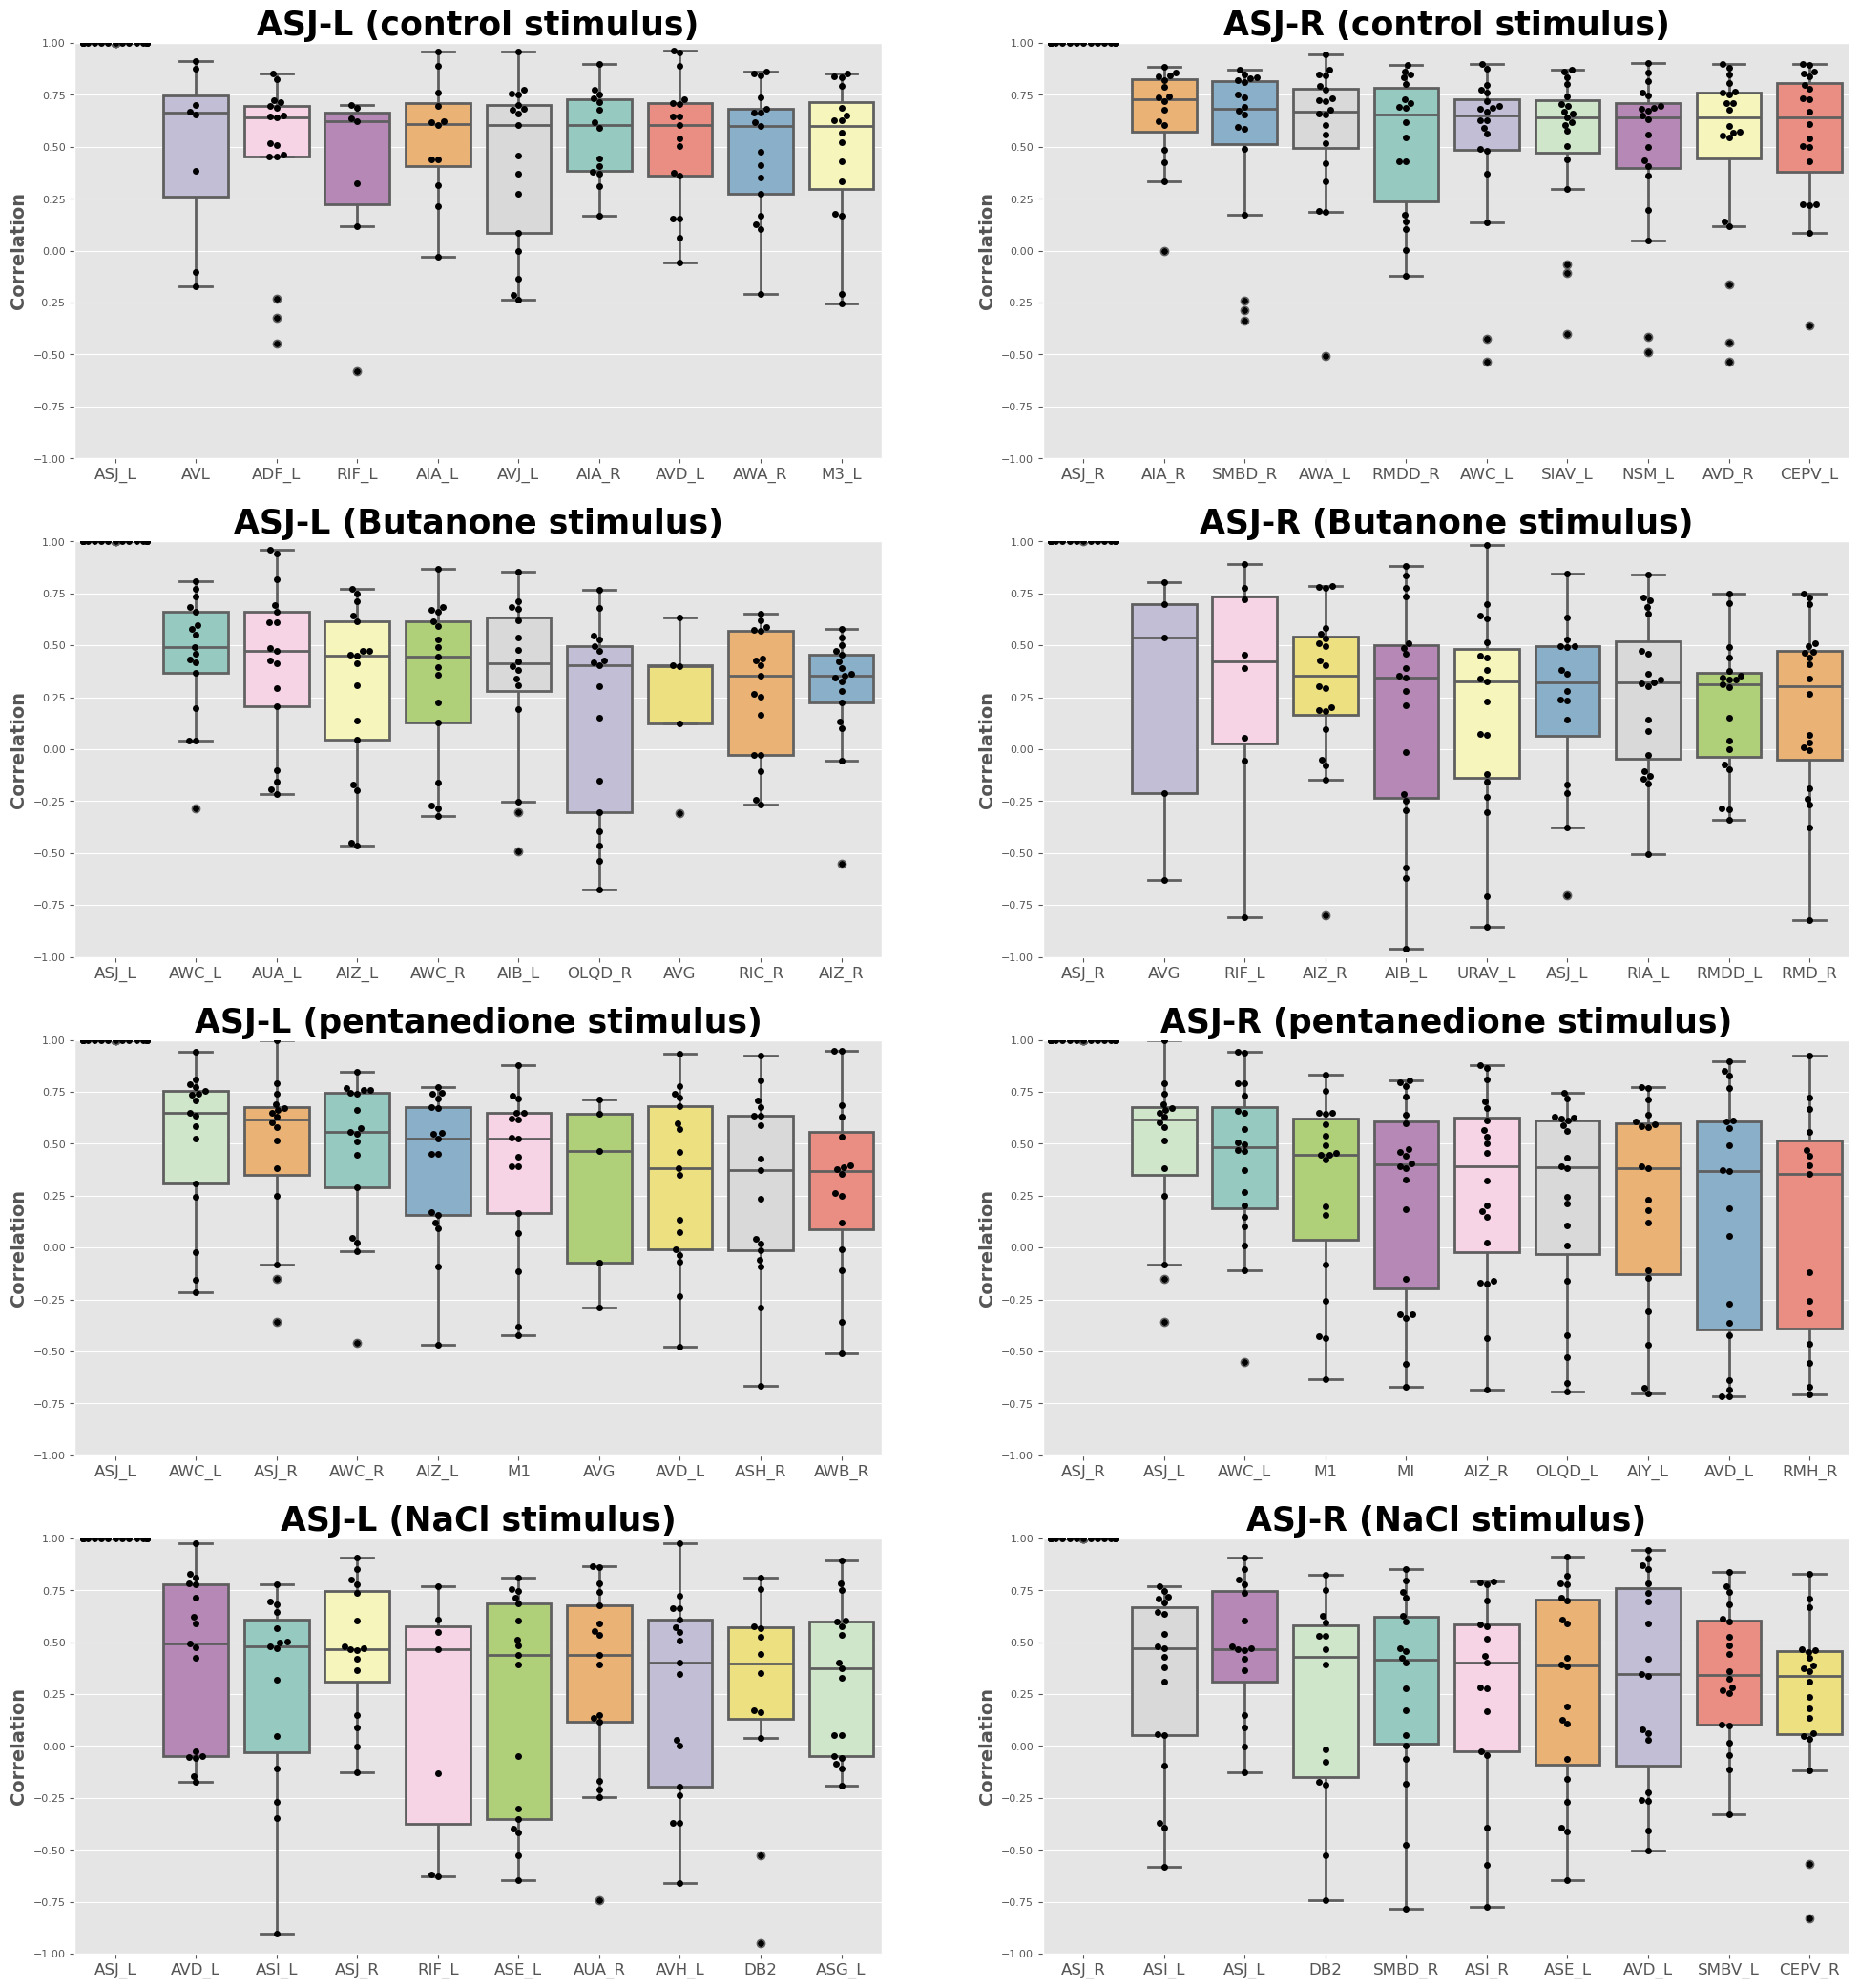

In [33]:
plt.style.use("ggplot") #to have plot look more like ggplot2 in R
colors = sns.color_palette("Set3") #if you look up 'matplotlib colormap reference' you can find a list of options

fig, axs = plt.subplots(4,2, figsize=(24,26), facecolor='w') #this establishes the plotting
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]
ax5 = axs[2,0]
ax6 = axs[2,1]
ax7 = axs[3,0]
ax8 = axs[3,1]

colors1 = random.sample(colors, len(colors))
colors2 = random.sample(colors, len(colors))
colors3 = random.sample(colors, len(colors))
colors4 = random.sample(colors, len(colors))
colors5 = random.sample(colors, len(colors))
colors6 = random.sample(colors, len(colors))
colors7 = random.sample(colors, len(colors))
colors8 = random.sample(colors, len(colors))

ax1.set_title('ASJ-L (control stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_ASJ_L_corrC.iloc[:, :10], palette=colors1, linewidth = 2, ax=ax1) 
sns.swarmplot(data=ReorderCutoff_df_rank_ASJ_L_corrC.iloc[:, :10], size=5, color='black', ax=ax1) 
ax1.set_ylabel('Correlation', fontsize=14, weight='bold')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=8)
ax1.set_ylim([-1,1])
# plt.axhline(y=0, color='black', alpha=0.5) 

ax2.set_title('ASJ-R (control stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_ASJ_R_corrC.iloc[:, :10], palette=colors2, linewidth = 2, ax=ax2) 
sns.swarmplot(data=ReorderCutoff_df_rank_ASJ_R_corrC.iloc[:, :10], size=5, color='black', ax=ax2) 
ax2.set_ylabel('Correlation', fontsize=14, weight='bold')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=8)
ax2.set_ylim([-1,1])
# plt.axhline(y=0, color='black', alpha=0.5) 

ax3.set_title('ASJ-L (Butanone stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_ASJ_L_corrB.iloc[:, :10], palette=colors3, linewidth = 2, ax=ax3)
sns.swarmplot(data=ReorderCutoff_df_rank_ASJ_L_corrB.iloc[:, :10], size=5, color='black', ax=ax3) 
ax3.set_ylabel('Correlation', fontsize=14, weight='bold')
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=8)
ax3.set_ylim([-1,1])
# plt.axhline(y=0, color='black', alpha=0.5) 

ax4.set_title('ASJ-R (Butanone stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_ASJ_R_corrB.iloc[:, :10], palette=colors4, linewidth = 2, ax=ax4) #excluding column 1, only 5 trials
sns.swarmplot(data=ReorderCutoff_df_rank_ASJ_R_corrB.iloc[:, :10], size=5, color='black', ax=ax4) 
ax4.set_ylabel('Correlation', fontsize=14, weight='bold')
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=8)
ax4.set_ylim([-1,1])
# plt.axhline(y=0, color='black', alpha=0.5) 

ax5.set_title('ASJ-L (pentanedione stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_ASJ_L_corrP.iloc[:, :10], palette=colors5, linewidth = 2, ax=ax5) 
sns.swarmplot(data=ReorderCutoff_df_rank_ASJ_L_corrP.iloc[:, :10], size=5, color='black', ax=ax5) 
ax5.set_ylabel('Correlation', fontsize=14, weight='bold')
ax5.xaxis.set_tick_params(labelsize=12)
ax5.yaxis.set_tick_params(labelsize=8)
ax5.set_ylim([-1,1])
# plt.axhline(y=0, color='black', alpha=0.5) 

ax6.set_title('ASJ-R (pentanedione stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_ASJ_R_corrP.iloc[:, :10], palette=colors6, linewidth = 2, ax=ax6) #removing first column as it IS ASJ_R
sns.swarmplot(data=ReorderCutoff_df_rank_ASJ_R_corrP.iloc[:, :10], size=5, color='black', ax=ax6) 
ax6.set_ylabel('Correlation', fontsize=14, weight='bold')
ax6.xaxis.set_tick_params(labelsize=12)
ax6.yaxis.set_tick_params(labelsize=8)
ax6.set_ylim([-1,1])
# plt.axhline(y=0, color='black', alpha=0.5) 

ax7.set_title('ASJ-L (NaCl stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_ASJ_L_corrNaCl.iloc[:, :10], palette=colors7, linewidth = 2, ax=ax7) 
sns.swarmplot(data=ReorderCutoff_df_rank_ASJ_L_corrNaCl.iloc[:, :10], size=5, color='black', ax=ax7)
ax7.set_ylabel('Correlation', fontsize=14, weight='bold')
ax7.xaxis.set_tick_params(labelsize=12)
ax7.yaxis.set_tick_params(labelsize=8)
ax7.set_ylim([-1,1])
# plt.axhline(y=0, color='black', alpha=0.5) 

ax8.set_title('ASJ-R (NaCl stimulus)', fontsize=25, weight='bold')
sns.boxplot(data=ReorderCutoff_df_rank_ASJ_R_corrNaCl.iloc[:, :10], palette=colors8, linewidth = 2, ax=ax8)
sns.swarmplot(data=ReorderCutoff_df_rank_ASJ_R_corrNaCl.iloc[:, :10], size=5, color='black', ax=ax8)
ax8.set_ylabel('Correlation', fontsize=14, weight='bold')
ax8.xaxis.set_tick_params(labelsize=12)
ax8.yaxis.set_tick_params(labelsize=8)
ax8.set_ylim([-1,1]) 
# plt.axhline(y=0, color='black', alpha=0.5)
plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/ASJ_LR_CorrelationStimulus.png', dpi = 900)

plt.show()

<font color='skyblue' size = 10>Now do it for AVA</font>

In [323]:
def NeuronList_stimuli(data, neuron, left_right): 
    
    stimulus_indices = {1: [], 2: [], 3: []}

    for trial_index, trial in enumerate(data['stims']):
        for stimulus_index, stimulus in enumerate(trial):
            stimulus_indices[stimulus].append((trial_index, stimulus_index))

    stimulus_intervals = [(232, 482), (472, 722), (712, 955)]
    neuron_data = {}
    
    if left_right == 'left':
    
        neuron_L = LR_Traces(data, neuron, left_right) 

        neuron_data[f'{neuron}_L_control'] = [traces[:232] for traces in neuron_L]
        
        neuron_data[f'{neuron}_L_butanone'] = []
        neuron_data[f'{neuron}_L_pentanedione'] = []
        neuron_data[f'{neuron}_L_NaCl'] = []
    
        for stimulus, indices in stimulus_indices.items():
            for trial_index, stimulus_index in indices:
                start, end = stimulus_intervals[stimulus_index]
                if stimulus == 1:
                    neuron_data[f'{neuron}_L_butanone'].append(neuron_L[trial_index][start:end])
                elif stimulus == 2:
                    neuron_data[f'{neuron}_L_pentanedione'].append(neuron_L[trial_index][start:end])
                elif stimulus == 3:
                    neuron_data[f'{neuron}_L_NaCl'].append(neuron_L[trial_index][start:end])
    
        neuron_data[f'{neuron}_stimuli_list_L'] = [neuron_data[f'{neuron}_L_control'], neuron_data[f'{neuron}_L_butanone'], neuron_data[f'{neuron}_L_pentanedione'], neuron_data[f'{neuron}_L_NaCl']]
        return neuron_data[f'{neuron}_stimuli_list_L']
    
    if left_right == 'right':
    
        neuron_R = LR_Traces(data, neuron, left_right)

        neuron_data[f'{neuron}_R_control'] = [traces[:232] for traces in neuron_R]
    
        neuron_data[f'{neuron}_R_butanone'] = []
        neuron_data[f'{neuron}_R_pentanedione'] = []
        neuron_data[f'{neuron}_R_NaCl'] = []

        for stimulus, indices in stimulus_indices.items():
            for trial_index, stimulus_index in indices:
                start, end = stimulus_intervals[stimulus_index]
                if stimulus == 1:
                    neuron_data[f'{neuron}_R_butanone'].append(neuron_R[trial_index][start:end])
                elif stimulus == 2:
                    neuron_data[f'{neuron}_R_pentanedione'].append(neuron_R[trial_index][start:end])
                elif stimulus == 3:
                    neuron_data[f'{neuron}_R_NaCl'].append(neuron_R[trial_index][start:end])

        neuron_data[f'{neuron}_stimuli_list_R'] = [neuron_data[f'{neuron}_R_control'], neuron_data[f'{neuron}_R_butanone'], neuron_data[f'{neuron}_R_pentanedione'], neuron_data[f'{neuron}_R_NaCl']]
        return neuron_data[f'{neuron}_stimuli_list_R']

AVA_stimuli_list_L = NeuronList_stimuli(head1, 'AVA', 'left')
AVA_stimuli_list_R = NeuronList_stimuli(head1, 'AVA', 'right')

In [324]:
def CorrelateAlltoAVA(neurons, AVA_neuron): #'neuron' is the list of all other neurons, AWC_neuron is AWC L or R
    num_stimuli, num_trials, num_neurons = len(neurons), len(neurons[0]), len(neurons[0][0])
    correlations = np.full((num_stimuli, num_neurons, num_trials), np.nan)

    for s in range(num_stimuli): #loop through each stimulus (4)
        for t in range(num_trials): #loop through each of the 21 trials
            for n in range(num_neurons): #loop through each neuron
                try:
                    length = min(len(neurons[s][t][n]), len(AVA_neuron[s][t])) #find the minimum length of the two traces (s - stimuli, t - trial, n - neuron)
                
                    corr = np.corrcoef(neurons[s][t][n][:length], AVA_neuron[s][t][:length])
                    correlations[s][n][t] = corr[0][1]

                except:
                    print(f"Error at stimulus {s}, trial {t}, neuron {n}")
                    continue 

    return correlations

### Correlating Other Neurons (head) to ASJ L
corr_head_AVA_L = CorrelateAlltoAVA(OTHERneurons_stimuli_Head, AVA_stimuli_list_L)
## Correlating Other Neurons (tail) to AVA L
corr_tail_AVA_L = CorrelateAlltoAVA(OTHERneurons_stimuli_Tail, AVA_stimuli_list_L)
### Correlating Other Neurons (head) to AVA R
corr_head_AVA_R = CorrelateAlltoAVA(OTHERneurons_stimuli_Head, AVA_stimuli_list_R)
### Correlating Other Neurons (tail) to AVA R
corr_tail_AVA_R = CorrelateAlltoAVA(OTHERneurons_stimuli_Tail, AVA_stimuli_list_R)

/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [325]:
def RankingByStimuli(array, names, analysis_variable):
    all_ranked = []
    all_names = []
    all_ranked_meds = []
    all_true_meds = []
    
    for j in range(len(array)): # Loop over each stimulus
        more_than_4_nan = 0
        medians = []
        true_medians = []
        for i in array[j]: # Loop over each neuron for the iterative stimulus
            num_nan = np.isnan(i).sum()
            if num_nan <= 4: # Check if the neuron has more than 4 NaN values
               # print(f"Number of NaN values for neuron: {num_nan}")
                med = np.nanmedian(i) # Calculate the median correlation value for the current neuron across all trials
                medians.append(abs(med))  
                true_medians.append(med) 
            else:
                more_than_4_nan += 1

        reverse_sort = sorted(medians, reverse=True) # Sort medians in descending order
        ranked = np.empty((len(medians), len(array[j][0])), dtype=object) # Initialize ranked array
        name = []
        ranked_meds = []
        absolute_meds = []

        for i in range(len(reverse_sort)): # Loop over sorted medians
            index = medians.index(reverse_sort[i]) # Get index of current median in original medians list
            ranked[i] = array[j][index] # Store neuron's correlation values in ranked array
            name.append(names[index]) # Store neuron's name
            ranked_meds.append(true_medians[index]) # Store neuron's median correlation
            absolute_meds.append(medians[index]) # Store neuron's absolute median correlation

        all_ranked.append(ranked)
        all_names.append(name)
        all_ranked_meds.append(ranked_meds)
        all_true_meds.append(true_medians)

    if analysis_variable == 'names':
        return all_names
    elif analysis_variable == 'correlations':
        return all_ranked
    elif analysis_variable == 'medians':
        return all_ranked_meds
    elif analysis_variable == 'true medians':
        return all_true_meds

corr_all_traces_L = np.concatenate((corr_head_AVA_L, corr_tail_AVA_L), axis = 1)
corr_all_traces_R = np.concatenate((corr_head_AVA_R, corr_tail_AVA_R), axis = 1)

### Ranking for AVA L correlations with Other Neurons ###
Ranking_AVA_L_corr = RankingByStimuli(corr_all_traces_L, all_names, 'correlations')
Ranking_AVA_L_names = RankingByStimuli(corr_all_traces_L, all_names, 'names')
Ranking_AVA_L_trueMedians = RankingByStimuli(corr_all_traces_L, all_names, 'true medians')

### Ranking for AVA R correlations with Other Neurons ###
Ranking_AVA_R_corr = RankingByStimuli(corr_all_traces_R, all_names, 'correlations')
Ranking_AVA_R_names = RankingByStimuli(corr_all_traces_R, all_names, 'names')
Ranking_AVA_R_trueMedians = RankingByStimuli(corr_all_traces_R, all_names, 'true medians')

In [326]:
df_rank_AVA_L_corrC = pd.DataFrame(list(map(list, zip(*Ranking_AVA_L_corr[0]))), columns=Ranking_AVA_L_names[0])
df_rank_AVA_L_corrB = pd.DataFrame(list(map(list, zip(*Ranking_AVA_L_corr[1]))), columns=Ranking_AVA_L_names[1])
df_rank_AVA_L_corrP = pd.DataFrame(list(map(list, zip(*Ranking_AVA_L_corr[2]))), columns=Ranking_AVA_L_names[2])
df_rank_AVA_L_corrNaCl = pd.DataFrame(list(map(list, zip(*Ranking_AVA_L_corr[3]))), columns=Ranking_AVA_L_names[3])

df_rank_AVA_R_corrC = pd.DataFrame(list(map(list, zip(*Ranking_AVA_R_corr[0]))), columns=Ranking_AVA_R_names[0])
df_rank_AVA_R_corrB = pd.DataFrame(list(map(list, zip(*Ranking_AVA_R_corr[1]))), columns=Ranking_AVA_R_names[1])
df_rank_AVA_R_corrP = pd.DataFrame(list(map(list, zip(*Ranking_AVA_R_corr[2]))), columns=Ranking_AVA_R_names[2])
df_rank_AVA_R_corrNaCl = pd.DataFrame(list(map(list, zip(*Ranking_AVA_R_corr[3]))), columns=Ranking_AVA_R_names[3])

def reorder_columns_HighMedian(df):
    medians = df.median().sort_values(ascending=False).index #Calculate the median of each column and sort the columns by median
    df = df[medians] #Reorder the columns based on the sorted medians
    return df

Reorder_df_rank_AVA_L_corrC = reorder_columns_HighMedian(df_rank_AVA_L_corrC)
Reorder_df_rank_AVA_L_corrB = reorder_columns_HighMedian(df_rank_AVA_L_corrB)
Reorder_df_rank_AVA_L_corrP = reorder_columns_HighMedian(df_rank_AVA_L_corrP)
Reorder_df_rank_AVA_L_corrNaCl = reorder_columns_HighMedian(df_rank_AVA_L_corrNaCl)

Reorder_df_rank_AVA_R_corrC = reorder_columns_HighMedian(df_rank_AVA_R_corrC)
Reorder_df_rank_AVA_R_corrB = reorder_columns_HighMedian(df_rank_AVA_R_corrB)
Reorder_df_rank_AVA_R_corrP = reorder_columns_HighMedian(df_rank_AVA_R_corrP)
Reorder_df_rank_AVA_R_corrNaCl = reorder_columns_HighMedian(df_rank_AVA_R_corrNaCl)
print(Reorder_df_rank_AVA_R_corrB.head(3))

def filter_nan_cutoff(df, num_nan):
    df = df.loc[:, df.isnull().sum() <= num_nan] #only keep columns with less than or equal to 4 NaN values for their entire column (across all 21 rows)
    return df  

ReorderCutoff_df_rank_AVA_L_corrC = filter_nan_cutoff(Reorder_df_rank_AVA_L_corrC, 16) 
ReorderCutoff_df_rank_AVA_R_corrC = filter_nan_cutoff(Reorder_df_rank_AVA_R_corrC, 16)
ReorderCutoff_df_rank_AVA_L_corrB = filter_nan_cutoff(Reorder_df_rank_AVA_L_corrB, 16)
ReorderCutoff_df_rank_AVA_R_corrB = filter_nan_cutoff(Reorder_df_rank_AVA_R_corrB, 16)
ReorderCutoff_df_rank_AVA_L_corrP = filter_nan_cutoff(Reorder_df_rank_AVA_L_corrP, 16)
ReorderCutoff_df_rank_AVA_R_corrP = filter_nan_cutoff(Reorder_df_rank_AVA_R_corrP, 16)
ReorderCutoff_df_rank_AVA_L_corrNaCl = filter_nan_cutoff(Reorder_df_rank_AVA_L_corrNaCl, 16)
ReorderCutoff_df_rank_AVA_R_corrNaCl = filter_nan_cutoff(Reorder_df_rank_AVA_R_corrNaCl, 16)

print(ReorderCutoff_df_rank_AVA_R_corrB.head(3))

   AVA_R     RIM_L     AVA_L     RIM_R     AVE_L    RMDV_R     AVE_R   
0    1.0  0.960561  0.958957  0.921860  0.911936  0.327569  0.864185  \
1    1.0  0.933304  0.768370  0.987185  0.934844  0.295511  0.967588   
2    1.0 -0.740654  0.999360       NaN  0.963801 -0.213665  0.903379   

       SABD       AVG    RMDV_L  ...       DB1       DB2     AVB_R     RIB_R   
0  0.893741  0.942638  0.627224  ... -0.797215  0.896762 -0.819233 -0.788582  \
1       NaN       NaN  0.702882  ...       NaN -0.833690 -0.850574 -0.748216   
2  0.947531 -0.003714  0.998816  ...  0.970024       NaN -0.748396 -0.766463   

      RME_L     RIB_L    SIBD_R     RME_R    SIBV_L    SIBV_R  
0 -0.789400 -0.801267 -0.907561 -0.901899       NaN -0.902714  
1 -0.713715 -0.757697 -0.795337 -0.956005 -0.962461 -0.859493  
2 -0.940893 -0.773113  0.012082 -0.788836 -0.829503 -0.576174  

[3 rows x 200 columns]
   AVA_R     RIM_L     AVA_L     RIM_R     AVE_L    RMDV_R     AVE_R   
0    1.0  0.960561  0.958957  0.921860

/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_19713/1951033878.py:24: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  sns.boxplot(data=ReorderCutoff_df_rank_AVA_L_corrC.iloc[:, :10], palette=colors1, linewidth = 2, ax=ax1)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 57.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_19713/1951033878.py:32: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  sns.boxplot(data=ReorderCutoff_df

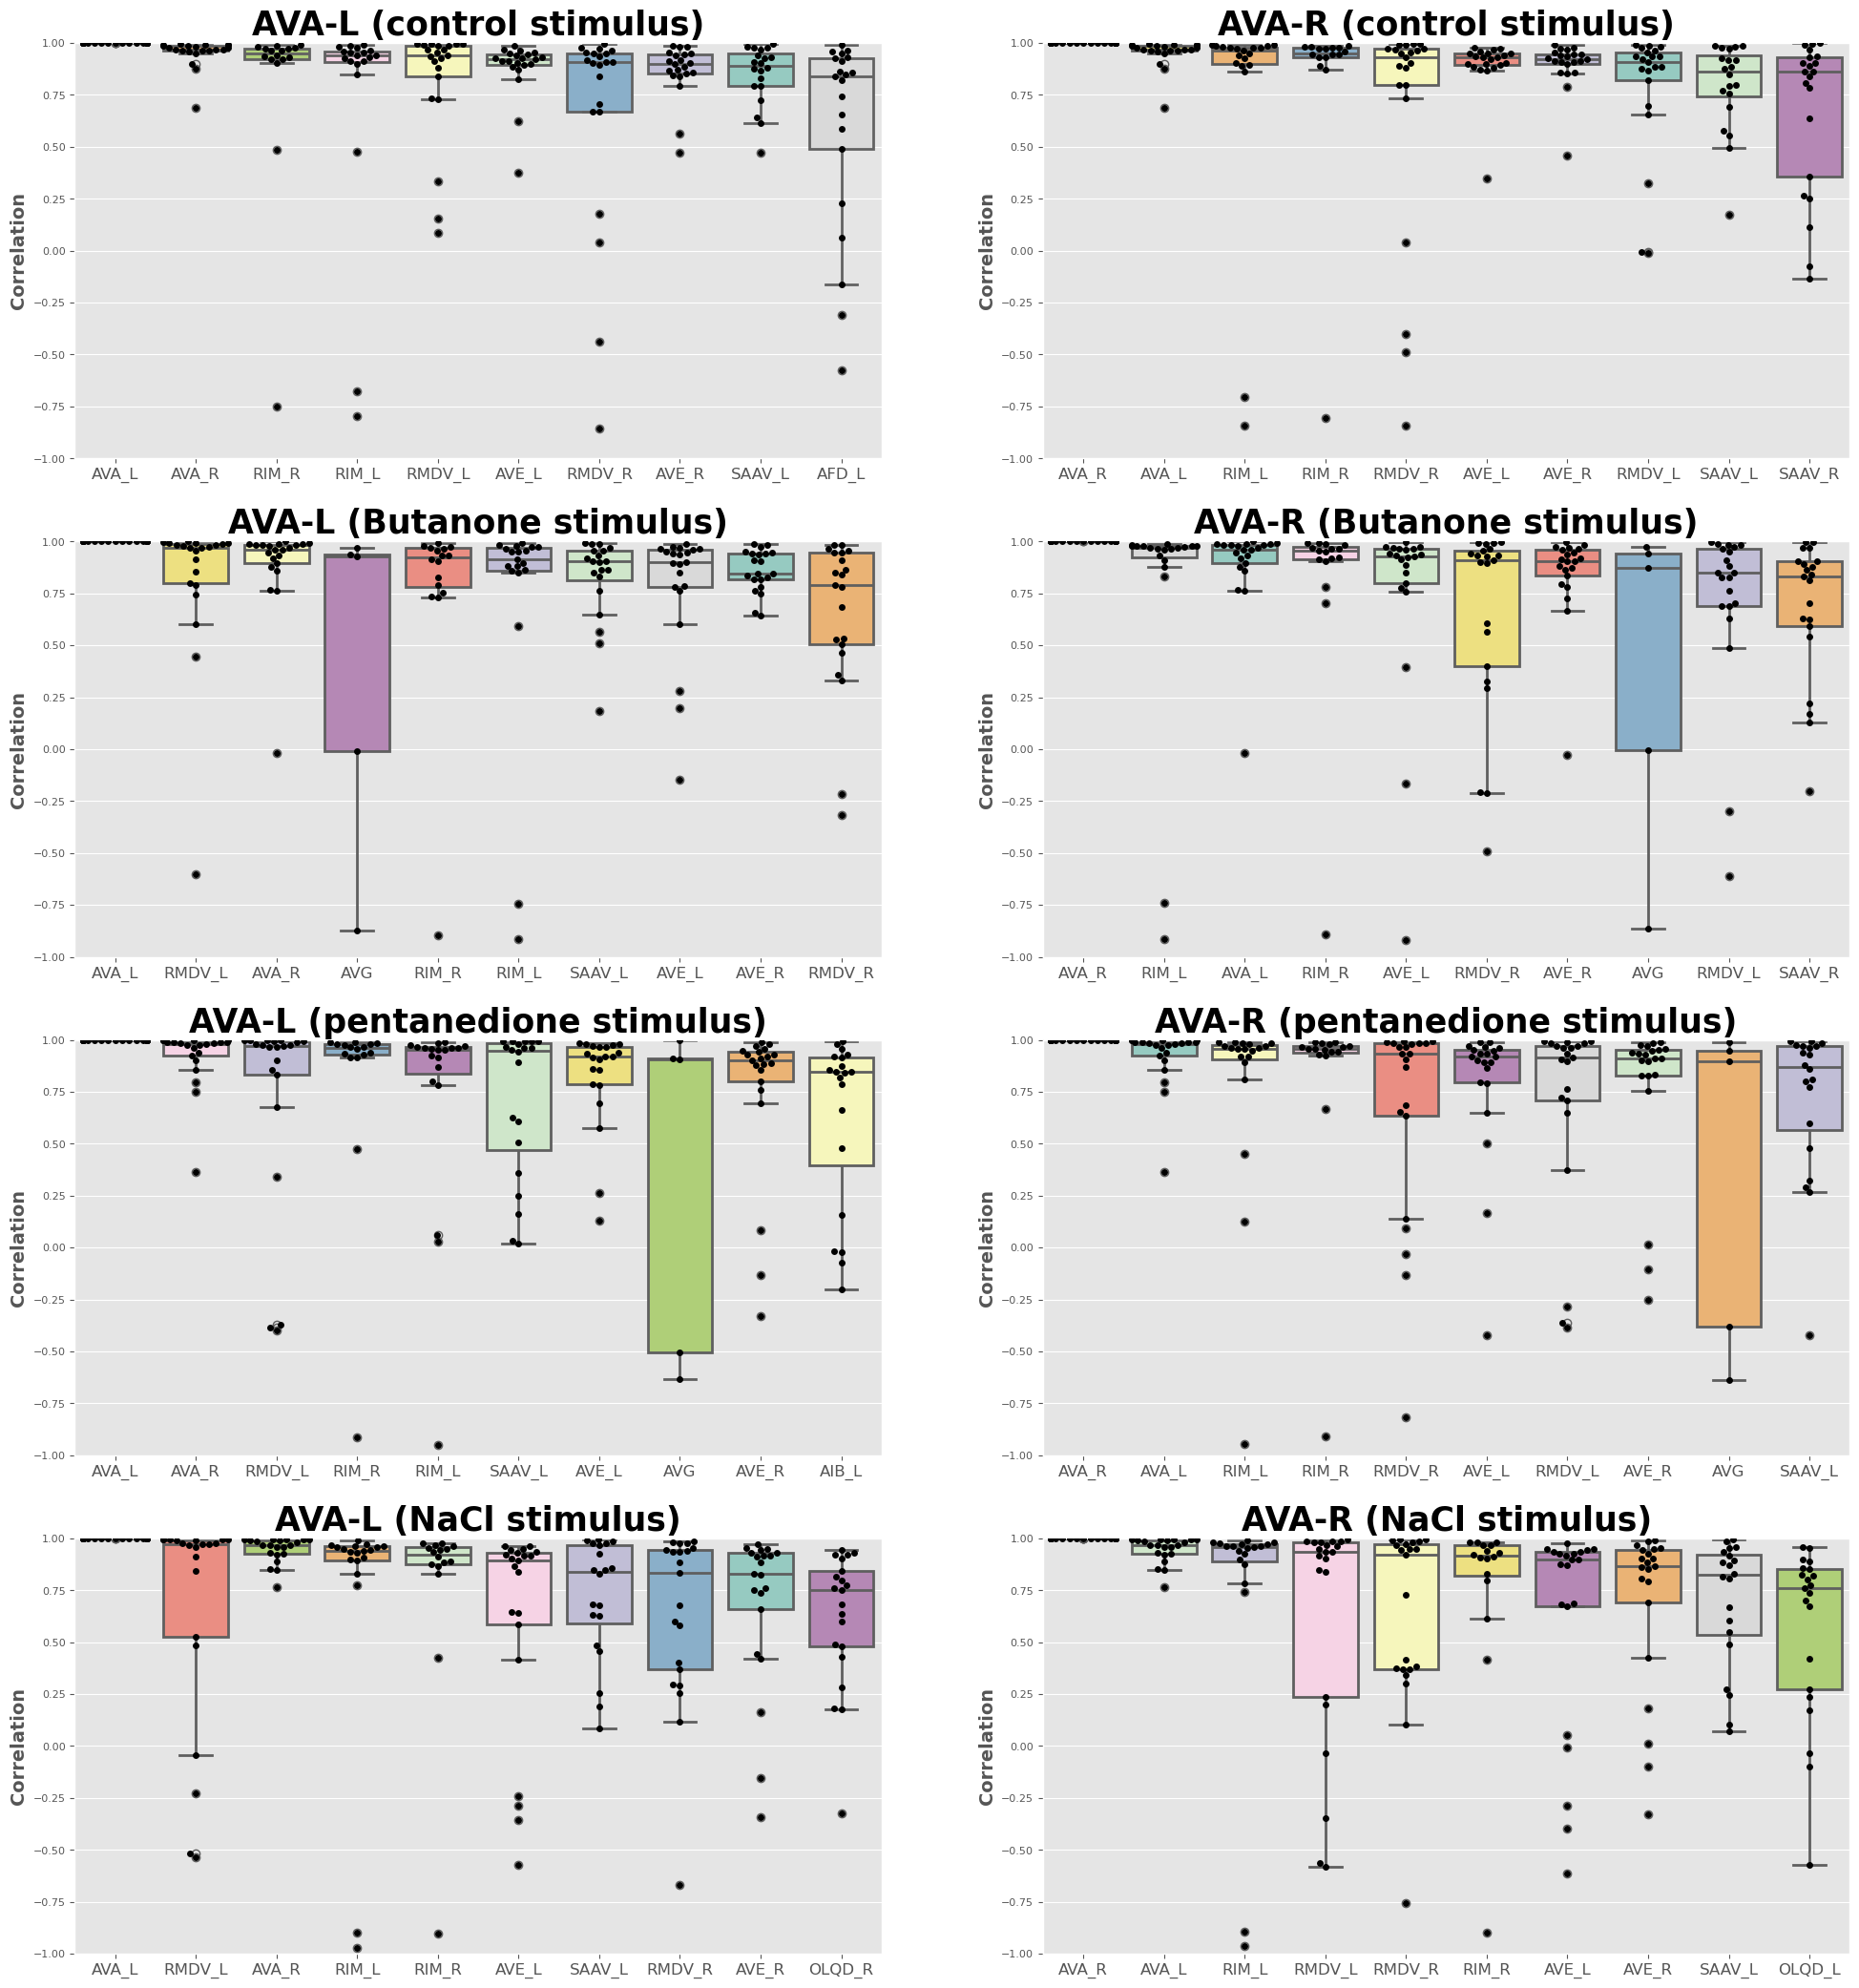

In [327]:
plt.style.use("ggplot") #to have plot look more like ggplot2 in R
colors = sns.color_palette("Set3") #if you look up 'matplotlib colormap reference' you can find a list of options

fig, axs = plt.subplots(4,2, figsize=(24,26), facecolor='w') #this establishes the plotting
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]
ax5 = axs[2,0]
ax6 = axs[2,1]
ax7 = axs[3,0]
ax8 = axs[3,1]

colors1 = random.sample(colors, len(colors))
colors2 = random.sample(colors, len(colors))
colors3 = random.sample(colors, len(colors))
colors4 = random.sample(colors, len(colors))
colors5 = random.sample(colors, len(colors))
colors6 = random.sample(colors, len(colors))
colors7 = random.sample(colors, len(colors))
colors8 = random.sample(colors, len(colors))

ax1.set_title('AVA-L (control stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_AVA_L_corrC.iloc[:, :10], palette=colors1, linewidth = 2, ax=ax1) 
sns.swarmplot(data=ReorderCutoff_df_rank_AVA_L_corrC.iloc[:, :10], size=5, color='black', ax=ax1) 
ax1.set_ylabel('Correlation', fontsize=14, weight='bold')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=8)
ax1.set_ylim([-1,1])

ax2.set_title('AVA-R (control stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_AVA_R_corrC.iloc[:, :10], palette=colors2, linewidth = 2, ax=ax2) 
sns.swarmplot(data=ReorderCutoff_df_rank_AVA_R_corrC.iloc[:, :10], size=5, color='black', ax=ax2) 
ax2.set_ylabel('Correlation', fontsize=14, weight='bold')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=8)
ax2.set_ylim([-1,1])

ax3.set_title('AVA-L (Butanone stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_AVA_L_corrB.iloc[:, :10], palette=colors3, linewidth = 2, ax=ax3)
sns.swarmplot(data=ReorderCutoff_df_rank_AVA_L_corrB.iloc[:, :10], size=5, color='black', ax=ax3) 
ax3.set_ylabel('Correlation', fontsize=14, weight='bold')
ax3.xaxis.set_tick_params(labelsize=12)
ax3.yaxis.set_tick_params(labelsize=8)
ax3.set_ylim([-1,1])

ax4.set_title('AVA-R (Butanone stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_AVA_R_corrB.iloc[:, :10], palette=colors4, linewidth = 2, ax=ax4) #excluding column 1, only 5 trials
sns.swarmplot(data=ReorderCutoff_df_rank_AVA_R_corrB.iloc[:, :10], size=5, color='black', ax=ax4) 
ax4.set_ylabel('Correlation', fontsize=14, weight='bold')
ax4.xaxis.set_tick_params(labelsize=12)
ax4.yaxis.set_tick_params(labelsize=8)
ax4.set_ylim([-1,1])

ax5.set_title('AVA-L (pentanedione stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_AVA_L_corrP.iloc[:, :10], palette=colors5, linewidth = 2, ax=ax5) 
sns.swarmplot(data=ReorderCutoff_df_rank_AVA_L_corrP.iloc[:, :10], size=5, color='black', ax=ax5) 
ax5.set_ylabel('Correlation', fontsize=14, weight='bold')
ax5.xaxis.set_tick_params(labelsize=12)
ax5.yaxis.set_tick_params(labelsize=8)
ax5.set_ylim([-1,1])

ax6.set_title('AVA-R (pentanedione stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_AVA_R_corrP.iloc[:, :10], palette=colors6, linewidth = 2, ax=ax6) #removing first column as it IS AVA_R
sns.swarmplot(data=ReorderCutoff_df_rank_AVA_R_corrP.iloc[:, :10], size=5, color='black', ax=ax6) 
ax6.set_ylabel('Correlation', fontsize=14, weight='bold')
ax6.xaxis.set_tick_params(labelsize=12)
ax6.yaxis.set_tick_params(labelsize=8)
ax6.set_ylim([-1,1])

ax7.set_title('AVA-L (NaCl stimulus)', fontsize=25, weight='bold') 
sns.boxplot(data=ReorderCutoff_df_rank_AVA_L_corrNaCl.iloc[:, :10], palette=colors7, linewidth = 2, ax=ax7) 
sns.swarmplot(data=ReorderCutoff_df_rank_AVA_L_corrNaCl.iloc[:, :10], size=5, color='black', ax=ax7)
ax7.set_ylabel('Correlation', fontsize=14, weight='bold')
ax7.xaxis.set_tick_params(labelsize=12)
ax7.yaxis.set_tick_params(labelsize=8)
ax7.set_ylim([-1,1])

ax8.set_title('AVA-R (NaCl stimulus)', fontsize=25, weight='bold')
sns.boxplot(data=ReorderCutoff_df_rank_AVA_R_corrNaCl.iloc[:, :10], palette=colors8, linewidth = 2, ax=ax8)
sns.swarmplot(data=ReorderCutoff_df_rank_AVA_R_corrNaCl.iloc[:, :10], size=5, color='black', ax=ax8)
ax8.set_ylabel('Correlation', fontsize=14, weight='bold')
ax8.xaxis.set_tick_params(labelsize=12)
ax8.yaxis.set_tick_params(labelsize=8)
ax8.set_ylim([-1,1])
#plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/AVA_LR_CorrelationStimulus.png', dpi = 900)

plt.show()

<font color='skyblue' size = 10>Seeing what specific neurons contribute to ASJ activity most based on calculating cost for traces</font>

<font color='red' size = 6>Creating matrices with all traces for all neurons, and ASJ, for all trials</font>

In [651]:
# Getting trace info for ASJ neurons
ASJ_L = LR_Traces(head1, 'ASJ', 'left') #see LR_traces function at beginning of script - pulling out all of the traces for ASJL and ASJR
ASJ_R = LR_Traces(head1, 'ASJ', 'right')

# print(len(ASJ_L)) #21 - trials
# print(len(ASJ_L[0])) #955 - traces per trial


# Getting trace info for all other neurons
head_names = Neurons_list('heads', 'names') #see Neurons_list function at the beginning of the script
head_traces = Neurons_list('heads', 'traces')

tail_names = Neurons_list('tails', 'names')
tail_traces = Neurons_list('tails', 'traces')

print(head_traces)
print(len(head_traces)) #189 - neurons
print(len(head_traces[0])) # 21 - trials
print(len(head_traces[0][5])) #955 - traces per trial
print(len(head_names)) #189 - neurons
print(np.shape(head_traces)) # (189,21)


# Need to re-organize traces data so that the first index is each trial, and then each trial contains a matrix of 955x189 - 955 traces for each of the 189 neurons
head_traces_reindexed = []
for i in range(21):  
    trial_data = np.full((955, 189), np.nan) #initializing a matrix
    for j in range(189): 
        neuron_traces = head_traces[j][i] #getting the traces for the i'th trial, and j'th neuron 
        # Assign the traces to the corresponding column in trial_data
        trial_data[:len(neuron_traces), j] = neuron_traces

    head_traces_reindexed.append(trial_data)

head_traces_reindexed = np.array(head_traces_reindexed)

# print(len(head_traces_reindexed)) # 21 - trials
# print(len(head_traces_reindexed[0])) # 955 - traces
# print(head_traces_reindexed[5][0:5]) #the 5th trial, all neurons (columns), and the first 6 traces
# print(head_traces_reindexed.shape[2]) #189 - number of columns (neurons). The 2 corresponds to 3rd dimension (first is 21, second is 955, third is 189)



# Need to remove ASJ neuron from traces
ASJ_R_index = head_names.index('ASJ_R')
ASJ_L_index = head_names.index('ASJ_L')

head_traces_reindexed_ASJremoved = []
for trial in head_traces_reindexed:
    trial_data = np.delete(trial, [ASJ_R_index, ASJ_L_index], axis=1)
    head_traces_reindexed_ASJremoved.append(trial_data)

head_traces_reindexed_ASJremoved = np.array(head_traces_reindexed_ASJremoved)
# ALSO need to remove ASJ_L and ASJ_R from the head_names to ensure indexing is not messed up!
head_names_ASJremoved = head_names.copy()  # Create a copy of head_names to avoid modifying the original list
head_names_ASJremoved.remove('ASJ_R')
head_names_ASJremoved.remove('ASJ_L')
# print(len(head_names_ASJremoved)) # 187!





tail_traces_reindexed = []
for i in range(21):  
    trial_data = np.full((955, 42), np.nan) #initializing a matrix
    for j in range(42): 
        neuron_traces = tail_traces[j][i] #getting the traces for the i'th trial, and j'th neuron 
        # Assign the traces to the corresponding column in trial_data
        trial_data[:len(neuron_traces), j] = neuron_traces

    tail_traces_reindexed.append(trial_data)

tail_traces_reindexed = np.array(tail_traces_reindexed) # ASJ neuron is not in the tail, do not need to remove

# print(len(tail_traces_reindexed)) # 21 - trials
# print(len(tail_traces_reindexed[0])) # 955 - traces
# print(tail_traces_reindexed[5][0:5]) #the 5th trial, all neurons (columns), and the first 6 traces
# print(tail_traces_reindexed.shape[2]) #42 - number of columns (neurons). The 2 corresponds to 3rd dimension (first is 21, second is 955, third is 42)







# Combining head and tail traces and names for one-to-all comparison!
# Combine the traces
ALLneuron_traces_ASJremoved = np.concatenate((head_traces_reindexed_ASJremoved, tail_traces_reindexed), axis=2)
# print(len(ALLneuron_traces_ASJremoved)) # 21 - for trials
# print(len(ALLneuron_traces_ASJremoved[1])) # 955 for traces
# print(ALLneuron_traces_ASJremoved.shape[2]) # 229 - CORRECT! (189 + 42 - 2)

# Combine the names
ALLneuron_names_ASJremoved = head_names_ASJremoved + tail_names


[[array([ 1.37090077e+00,  1.16861170e-01, -2.48405140e-01,  5.50792418e-01,
         -2.26306990e-01, -2.93846757e-01, -3.24628639e-01, -6.31017210e-01,
          2.81143849e-02,  2.08521000e-01, -1.05614845e+00, -1.27202816e+00,
         -6.82303950e-01, -2.24961331e+00, -5.46372761e-01, -1.74967299e+00,
         -1.92063470e+00, -1.42153963e+00, -1.52733558e+00, -1.63303545e+00,
         -1.43760319e+00, -1.58347799e+00, -8.94527311e-01, -1.45369553e+00,
         -1.88579414e+00, -1.88445770e+00, -1.59912600e+00, -1.81577116e+00,
         -1.31597704e+00, -2.12743175e+00, -9.45433489e-01, -1.37099683e+00,
         -8.91285620e-01, -6.47197395e-01, -6.71610249e-01, -2.85848952e-01,
         -1.50271269e+00, -8.88679626e-01, -1.68576383e-01, -5.08166711e-01,
         -1.63327576e+00, -1.18984260e+00, -1.68249954e+00, -1.14611683e+00,
         -8.18974852e-01, -1.87563927e+00, -1.24029239e+00, -7.71925404e-01,
         -1.31446231e+00, -1.54287329e+00, -2.82851606e-01, -1.25544847e+00,

/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<font color='red' size = 6>Function to extract summed cost for all neurons, across all trials, based on weight of neurons contributing to ASJ trace</font>

In [647]:
def Cost_function(weights, neuronTraces, ASJ_trace):
    T = len(neuronTraces) #955 - the number of frames
    Predicted_raw = np.matmul(neuronTraces, np.diag(weights)) # matrix multiplication to get product of neuron trace * weight of neuron
    Predicted_sum = np.nansum(Predicted_raw, axis =1) # summing across  columns
    min_length = min(len(Predicted_sum), len(ASJ_trace)) # in case some traces contain less frames than others 
    residual = np.sum((Predicted_sum[:min_length] - ASJ_trace[:min_length])**2 / T) # calculates the squared difference for every time point, and then divides by the frames/time points (955)
    return residual


def optimize_weights(allNeuronTraces, ASJ_traces, head_tail_all):
    optimal_weights_allTrials = []
    residuals_allTrials = []
    predicted_ASJ_traces_allTrials = []
    processed_trials_indices = []


    for trial in range(len(allNeuronTraces)):
        if head_tail_all =='tail':
            initial_weights = np.random.rand(42) 
        if head_tail_all == 'head':
            initial_weights = np.random.rand(187)
        if head_tail_all == 'all':
            initial_weights = np.random.rand(229)
        if head_tail_all == 'all_wASJ':
            initial_weights = np.random.rand(231)
        if head_tail_all == 'test':
            initial_weights = np.random.rand(10)                   
        if head_tail_all == 'stimuli':
            initial_weights = np.random.rand(29) #29 for ASJR and 27 for ASJL
        if head_tail_all == 'AVAL':
            initial_weights = np.random.rand(12)
        
        neuronTraces = allNeuronTraces[trial]
        ASJ_trace = ASJ_traces[trial]
        if (len(ASJ_trace) > 0): # ASJ contains some empty traces for a couple of trials
            result = minimize(Cost_function, initial_weights, args=(neuronTraces, ASJ_trace), method = 'L-BFGS-B')
            optimal_weights = result.x
            optimal_weights_allTrials.append(optimal_weights)
            residual = result.fun  # The final cost (residual) of the trial
            residuals_allTrials.append(residual) #the lowest calculated residual for a given trial after optimizing neuron weights
            Predicted_raw = np.matmul(neuronTraces, np.diag(optimal_weights)) #calculating the predicted ASJ trace using the optimal neuron weights with the lowest residual
            Predicted_sum = np.nansum(Predicted_raw, axis =1)
            predicted_ASJ_traces_allTrials.append(Predicted_sum)
            processed_trials_indices.append(trial)

    return optimal_weights_allTrials, residuals_allTrials, predicted_ASJ_traces_allTrials, processed_trials_indices



#optimal_weights_ASJ_left_toAll, optimal_residuals_allTrials_ASJ_left_toAll, predicted_traces_ASJ_left_toAll, processed_trials_indices_ASJ_L = optimize_weights(ALLneuron_traces_ASJremoved, ASJ_L, 'all')
# print(len(optimal_residuals_allTrials_ASJ_left_toAll)) # len is 17, as there are 4 trials where the ASJ trace is empty
# print(len(optimal_weights_ASJ_left_toAll[0])) # 229 - for each neuron
# print(len(predicted_traces_ASJ_left_toAll)) # 17 - for the 17 trials
# print(len(predicted_traces_ASJ_left_toAll[4])) # 955 - for the 955 trace values for the 5th trial

# optimal_weights_ASJ_right_toAll, optimal_residuals_allTrials_ASJ_right_toAll, predicted_traces_ASJ_right_toAll, processed_trials_indices_ASJ_R = optimize_weights(ALLneuron_traces_ASJremoved, ASJ_R, 'all')
# print(len(optimal_residuals_allTrials_ASJ_right_toAll)) # len is 20, as there is 1 trials where the ASJ trace is empty


<font color='red' size = 6>Isolating trials lowest residual values, and corresponding highest-weighted neruons</font>

In [40]:
# Isolating lowest residual trials, and then best scoring neurons (highest weight), and plotting against ASJ
lowest_residuals_indices = np.argsort(optimal_residuals_allTrials_ASJ_right_toAll)[:10]
#print(lowest_residuals_indices) # [15 19 18  5  6 13  2 14 17  3]

#isolating neurons from lowest residual trial, and ASJ_R traces from lowest residual trials
lowest_residuals_neurons = [optimal_weights_ASJ_right_toAll[i] for i in lowest_residuals_indices] # 10 arrays, each containing 229 values (weights of neurons)
# for i, trial in enumerate(lowest_residuals_neurons):
#     print(f"Trial {i+1}: {trial[:5]}")



lowest_residuals_original_indices = [processed_trials_indices_ASJ_R[i] for i in lowest_residuals_indices]
print(lowest_residuals_original_indices)
lowest_residuals_original_indices_forINDEXING = np.array(lowest_residuals_original_indices)




#Getting corresponding traces for low residual trials for ASJ_R
ASJ_R_array = np.array(ASJ_R)
ASJ_R_filtered = np.array([trial for trial in ASJ_R_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing
lowest_residualTrials_ASJ_R = ASJ_R_filtered[lowest_residuals_indices]

#Getting corresponding traces for low residual trials from the MASTER list for all other neurons
lowest_residual_trials = ALLneuron_traces_ASJremoved[lowest_residuals_original_indices_forINDEXING] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955x229 neurons and corresponding traces
 
#Getting the predicted ASJ_R traces from the optimize_weights function for the low residual trials 
predicted_ASJ_R_traces_lowestResidualTrials = [predicted_traces_ASJ_right_toAll[i] for i in lowest_residuals_indices] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955 traces for the predicted ASJ_R


all_traces = []
all_names = []
for trial, weight in enumerate(lowest_residuals_neurons):
    highestWeightNeurons_w_lowestResiduals = np.argsort(weight)[-5:] #isolating indices of top 5 neurons that had the highest weights, within the top 10 lowest residual trials

    # Get the corresponding traces and names for these neurons
    traces = lowest_residual_trials[trial, :, highestWeightNeurons_w_lowestResiduals] #lowest_residual_trials contains 10 matrices, each for a trial, of 955 rows by 187 neurons, and I need to isolate the top 5 scoring neurons (columns) and all of their traces!
    names = [ALLneuron_names_ASJremoved[i] for i in highestWeightNeurons_w_lowestResiduals]

    # Add the traces and names for this trial to the overall lists
    all_traces.append(traces)
    all_names.append(names)

# print(len(all_traces)) # 10 - for the top 10 scoring (lowest residual) trials
# print(len(all_traces[5])) # 5 - for each neuron
# print(all_traces[4][0]) # 955 traces (trial 5 (scoring), and highest scoring neuron)
# print(len(all_names)) # 10 -  for the top 10 scoring (lowest residual) trials
# print(len(all_names[5])) # 5 - for top scoring neurons 

[16, 8, 9, 4, 14, 11, 1, 10, 5, 12]


/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/128384267.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ASJ_R_array = np.array(ASJ_R)
/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/128384267.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ASJ_R_filtered = np.array([trial for trial in ASJ_R_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing


<font color='red' size = 6>Plotting by trial, including ASJ and predicted ASJ traces</font>

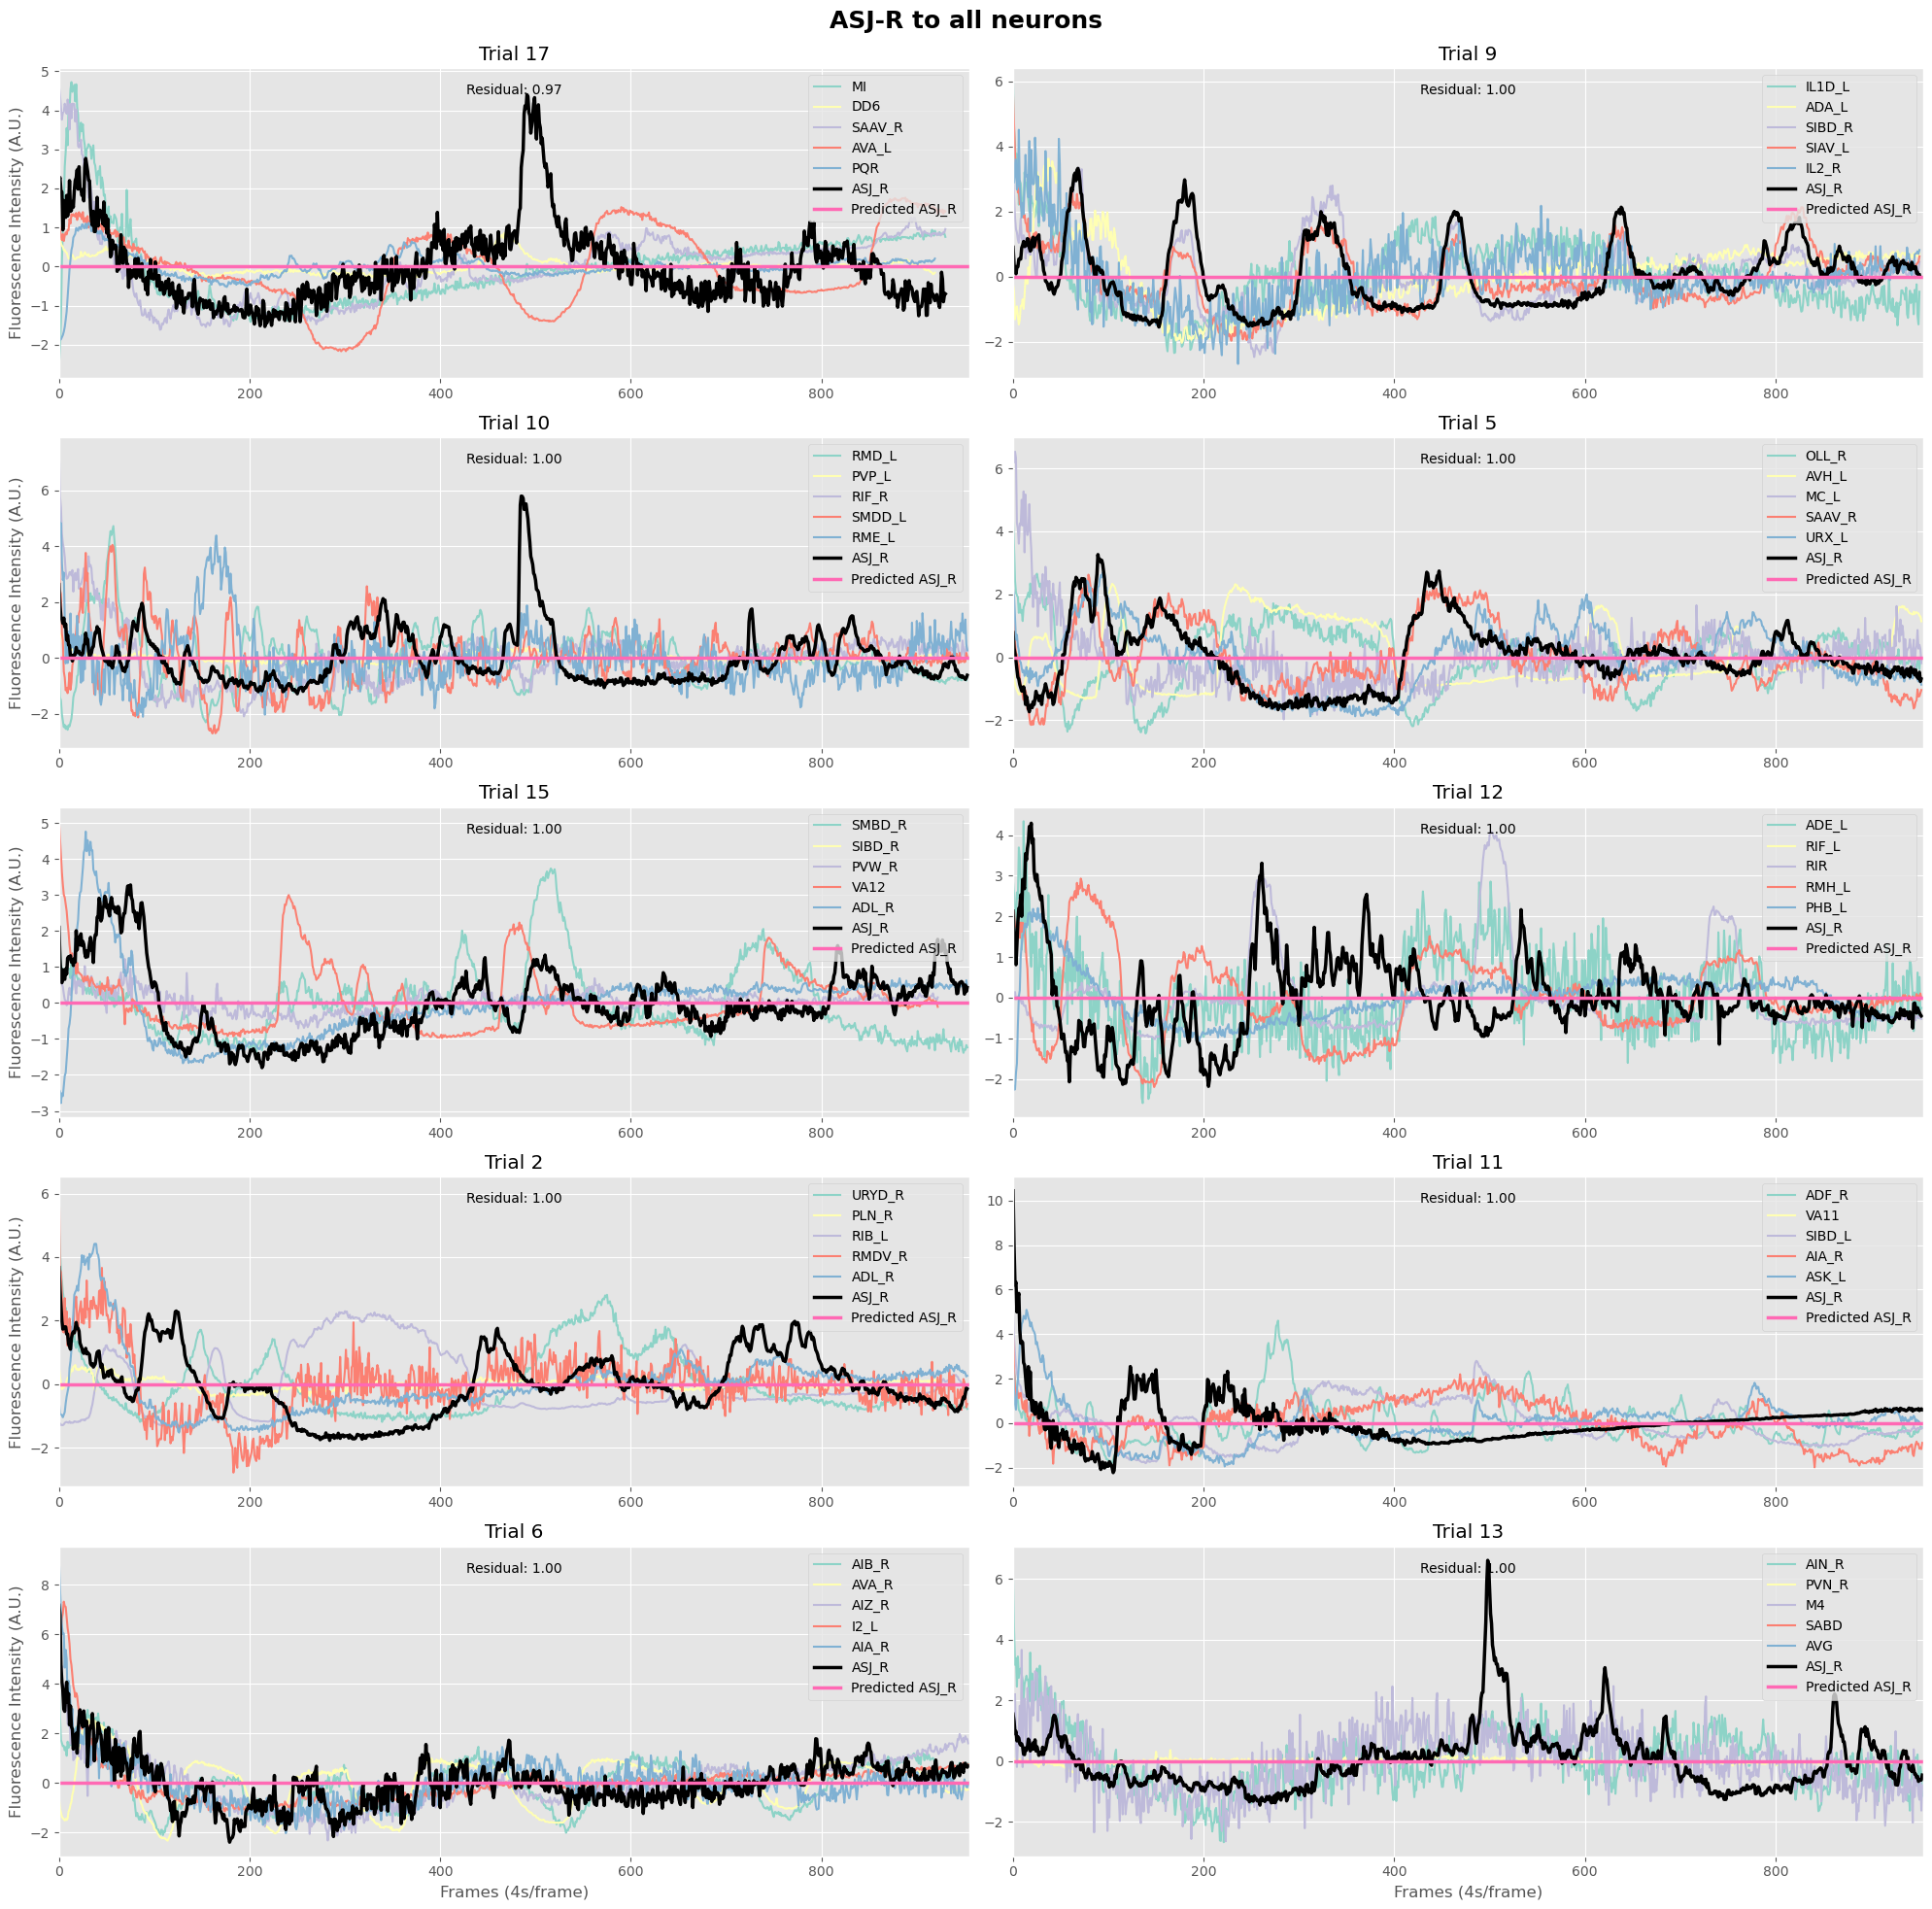

In [41]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
fig.suptitle("ASJ-R to all neurons", fontsize = 18, weight = 'bold')

palette = sns.color_palette("Set3", 5) 

for i in range(len(all_traces)):
    # Get the current subplot
    ax = axs[i // 2, i % 2]

    for j in range(len(all_traces[i])):
        ax.plot(all_traces[i][j], label=all_names[i][j], color=palette[j])

    ax.plot(lowest_residualTrials_ASJ_R[i], label='ASJ_R', color= 'black', linewidth = 2.5)
    ax.plot(predicted_ASJ_R_traces_lowestResidualTrials[i], label = 'Predicted ASJ_R', color = 'hotpink', linewidth = 2.5)

    residual_value = optimal_residuals_allTrials_ASJ_right_toAll[lowest_residuals_indices[i]]
    ax.text(0.5, 0.95, f"Residual: {residual_value:.2f}", transform=ax.transAxes, ha="center", va="top") #plotting residual values for each trial, with two decimal places

    ax.set_title(f"Trial {lowest_residuals_original_indices[i] + 1}") #python indexes at 0
    ax.set_xlim(0,955)
    if i % 2 == 0: #only labeling odd plots (1,3,5,7,9)
        ax.set_ylabel("Fluorescence Intensity (z-score)")

    if i >= len(all_traces) - 2: #adding x-axis to last two plots (ax 9 and 10)
        ax.set_xlabel("Frames (4s/frame)")
    ax.legend(loc = 'upper right')

plt.tight_layout()
plt.subplots_adjust(top = 0.95)
#plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/ASJ_R_residual_trials_weightedNeurons.png", dpi = 900)
plt.show()

<font color='red' size = 6>Now do for AVA neuron!</font>

In [638]:
#Getting AVA traces:
AVA_L = LR_Traces(head1, 'AVA', 'left') #see LR_traces function at beginning of script - pulling out all of the traces for AVAL and AVAR
AVA_R = LR_Traces(head1, 'AVA', 'right')

#Removing AVA from head traces and reindexing:
AVA_R_index = head_names.index('AVA_R')
AVA_L_index = head_names.index('AVA_L')

head_traces_reindexed_AVAremoved = []
for trial in head_traces_reindexed:
    trial_data = np.delete(trial, [AVA_R_index, AVA_L_index], axis=1)
    head_traces_reindexed_AVAremoved.append(trial_data)

head_traces_reindexed_AVAremoved = np.array(head_traces_reindexed_AVAremoved)
# ALSO need to remove AVA_L and AVA_R from the head_names to ensure indexing is not messed up!
head_names_AVAremoved = head_names.copy()  # Create a copy of head_names to avoid modifying the original list
head_names_AVAremoved.remove('AVA_R')
head_names_AVAremoved.remove('AVA_L')
print(len(head_names_AVAremoved)) # 187!
print()

ALLneuron_traces_AVAremoved = np.concatenate((head_traces_reindexed_AVAremoved, tail_traces_reindexed), axis=2)
# print(len(ALLneuron_traces_AVAremoved)) # 21 - for trials
# print(len(ALLneuron_traces_AVAremoved[1])) # 955 for traces
# print(ALLneuron_traces_AVAremoved.shape[2]) # 229 - CORRECT! (189 + 42 - 2)

# Combine the names
ALLneuron_names_AVAremoved = head_names_AVAremoved + tail_names



#isolating neruons that correlate with ASJ-R the most stimuli inclusive
neuron_names_stimuli = ["RIM_L","RIM_R","RMDV_R","AVE_L","AVE_R","RMDV_L","SAAV_L", "SAAV_R", "AVG", "OLQD_L"]
neurons_to_index_stimuli = [ALLneuron_names_AVAremoved.index(name) for name in neuron_names_stimuli]

TEST_HIGHESTcorrelated_AVAR_stimuli = []
for trial in ALLneuron_traces_AVAremoved:
    isolated_data = trial[:, neurons_to_index_stimuli]
    TEST_HIGHESTcorrelated_AVAR_stimuli.append(isolated_data)

TEST_HIGHESTcorrelated_AVAR_STIMULI_traces = np.array(TEST_HIGHESTcorrelated_AVAR_stimuli)
print(len(TEST_HIGHESTcorrelated_AVAR_STIMULI_traces))
print(len(TEST_HIGHESTcorrelated_AVAR_STIMULI_traces[4]))
print(TEST_HIGHESTcorrelated_AVAR_STIMULI_traces.shape[2]) # 10 neurons

TEST_HIGHESTcorrelated_AVAR_STIMULI_names = [ALLneuron_names_AVAremoved[i] for i in neurons_to_index_stimuli]
print(TEST_HIGHESTcorrelated_AVAR_STIMULI_names)



#isolating neruons that correlate with ASJ-L the most stimuli inclusive
neuron_names_stimuli = ["RIM_L","RIM_R","RMDV_R","AVE_L","AVE_R","RMDV_L","SAAV_L", "SAAV_R", "AVG", "AFD_L", "AIB_L", "OLQD_R"]
neurons_to_index_stimuli = [ALLneuron_names_AVAremoved.index(name) for name in neuron_names_stimuli]

TEST_HIGHESTcorrelated_AVAL_stimuli = []
for trial in ALLneuron_traces_AVAremoved:
    isolated_data = trial[:, neurons_to_index_stimuli]
    TEST_HIGHESTcorrelated_AVAL_stimuli.append(isolated_data)

TEST_HIGHESTcorrelated_AVAL_STIMULI_traces = np.array(TEST_HIGHESTcorrelated_AVAL_stimuli)
print(len(TEST_HIGHESTcorrelated_AVAL_STIMULI_traces))
print(len(TEST_HIGHESTcorrelated_AVAL_STIMULI_traces[4]))
print(TEST_HIGHESTcorrelated_AVAL_STIMULI_traces.shape[2]) # 12 neurons

TEST_HIGHESTcorrelated_AVAL_STIMULI_names = [ALLneuron_names_AVAremoved[i] for i in neurons_to_index_stimuli]
print(TEST_HIGHESTcorrelated_AVAL_STIMULI_names)




187

21
955
10
['RIM_L', 'RIM_R', 'RMDV_R', 'AVE_L', 'AVE_R', 'RMDV_L', 'SAAV_L', 'SAAV_R', 'AVG', 'OLQD_L']
21
955
12
['RIM_L', 'RIM_R', 'RMDV_R', 'AVE_L', 'AVE_R', 'RMDV_L', 'SAAV_L', 'SAAV_R', 'AVG', 'AFD_L', 'AIB_L', 'OLQD_R']


In [639]:
# optimal_weights_AVA_left_toAll, optimal_residuals_allTrials_AVA_left_toAll, predicted_traces_AVA_left_toAll, processed_trials_indices_AVA_L = optimize_weights(TEST_HIGHESTcorrelated_AVAL_STIMULI_traces, AVA_L, 'AVAL')
# print(len(optimal_residuals_allTrials_AVA_left_toAll)) # len is 21 - no esmpty trials!
# print(len(optimal_weights_AVA_left_toAll[0])) # 187 - for each neuron
optimal_weights_AVA_right_toAll, optimal_residuals_allTrials_AVA_right_toAll, predicted_traces_AVA_right_toAll, processed_trials_indices_AVA_R = optimize_weights(TEST_HIGHESTcorrelated_AVAR_STIMULI_traces, AVA_R, 'test')
# print(optimal_weights_AVA_right_toAll[0:10])
# optimal_weights_tail_AVA_Left_toAll, optimal_residuals_allTrials_tail_AVA_left_toAll, predicted_traces_tail_AVA_left_toAll, processed_trials_indices_tail_AVA_L = optimize_weights(tail_traces_reindexed, AVA_L, 'tail')
# optimal_weights_tail_AVA_right_toAll, optimal_residuals_allTrials_tail_AVA_right_toAll, predicted_traces_tail_AVA_right_toAll, processed_trials_indices_tail_AVA_R = optimize_weights(tail_traces_reindexed, AVA_R, 'tail')

In [640]:
# Isolating lowest residual trials, and then best scoring neurons (highest weight), and plotting against AVA
lowest_residuals_indices = np.argsort(optimal_residuals_allTrials_AVA_right_toAll)[:2]
#print(lowest_residuals_indices) # [15 19 18  5  6 13  2 14 17  3]

#isolating neurons from lowest residual trial, and AVA_R traces from lowest residual trials
lowest_residuals_neurons = [optimal_weights_AVA_right_toAll[i] for i in lowest_residuals_indices] # 10 arrays, each containing 187 values (weights of neurons)
# for i, trial in enumerate(lowest_residuals_neurons):
#     print(f"Trial {i+1}: {trial[:5]}")


lowest_residuals_original_indices = [processed_trials_indices_AVA_R[i] for i in lowest_residuals_indices]
# print(lowest_residuals_original_indices)
lowest_residuals_original_indices_forINDEXING = np.array(lowest_residuals_original_indices)





AVA_R_array = np.array(AVA_R)
AVA_R_filtered = np.array([trial for trial in AVA_R_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing
lowest_residualTrials_AVA_R = AVA_R_filtered[lowest_residuals_indices]


# AVA_L_array = np.array(AVA_L)
# AVA_L_filtered = np.array([trial for trial in AVA_L_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing
# lowest_residualTrials_AVA_L = AVA_L_filtered[lowest_residuals_indices]

lowest_residual_trials = TEST_HIGHESTcorrelated_AVAR_STIMULI_traces[lowest_residuals_original_indices_forINDEXING] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955x187 neurons and corresponding traces
 
# predicted_AVA_L_traces_lowestResidualTrials = [predicted_traces_AVA_left_toAll[i] for i in lowest_residuals_indices] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955 traces for the predicted AVA_R
predicted_AVA_R_traces_lowestResidualTrials = [predicted_traces_AVA_right_toAll[i] for i in lowest_residuals_indices] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955 traces for the predicted AVA_R

all_traces = []
all_names = []
for trial, weight in enumerate(lowest_residuals_neurons):
    highestWeightNeurons_w_lowestResiduals = np.argsort(weight)[-5:] #isolating indices of top 5 neurons that had the highest weights, within the top 10 lowest residual trials
    print(weight[-5:]) # all values are very small
    # Get the corresponding traces and names for these neurons
    traces = lowest_residual_trials[trial, :, highestWeightNeurons_w_lowestResiduals] #lowest_residual_trials contains 10 matrices, each for a trial, of 955 rows by 187 neurons, and I need to isolate the top 5 scoring neurons (columns) and all of their traces!
    names = [TEST_HIGHESTcorrelated_AVAR_STIMULI_names[i] for i in highestWeightNeurons_w_lowestResiduals]

    # Add the traces and names for this trial to the overall lists
    all_traces.append(traces)
    all_names.append(names)

[ 0.14206151  0.04114167  0.81497441 -0.05807656  0.01305946]
[ 0.12609922  0.00593566 -0.02544393 -0.0552294   0.0030336 ]


/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/2397652078.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  AVA_R_array = np.array(AVA_R)
/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/2397652078.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  AVA_R_filtered = np.array([trial for trial in AVA_R_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing


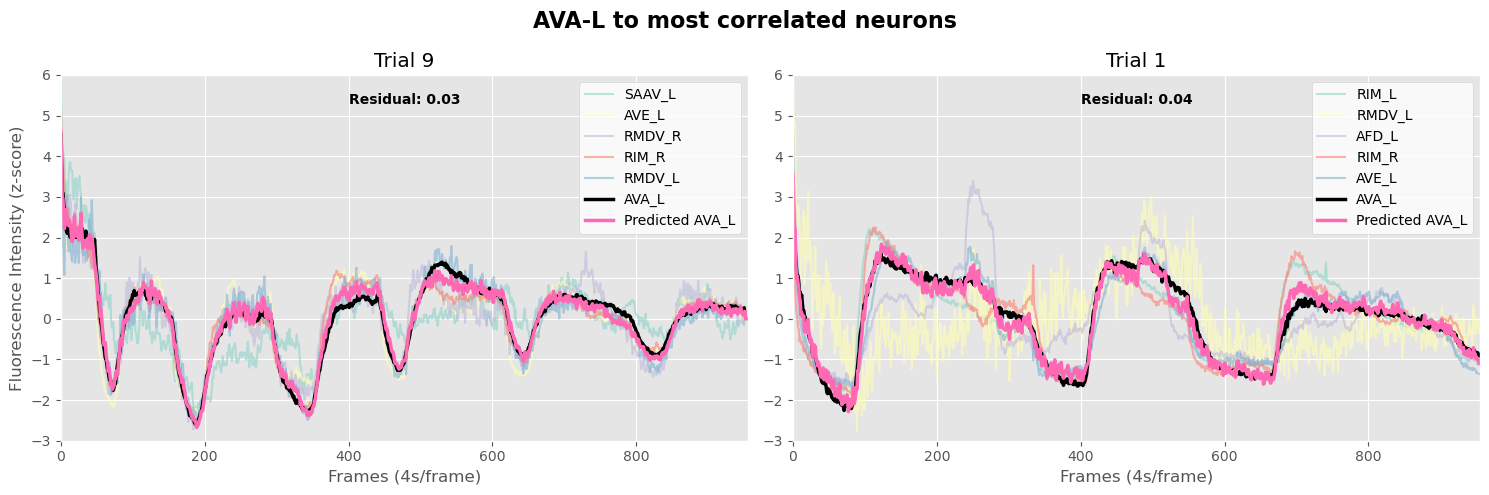

In [637]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("AVA-L to most correlated neurons", fontsize = 16, weight = 'bold')

palette = sns.color_palette("Set3", 5) 

for i in range(2): # len(all_traces)
    # ax = axs[i // 2, i % 2]
    ax = axs[i]
    for j in range(len(all_traces[i])):
        ax.plot(all_traces[i][j], label=all_names[i][j], color=palette[j], alpha = 0.6)

    ax.plot(lowest_residualTrials_AVA_L[i], label='AVA_L', color= 'black', linewidth = 2.5)
    ax.plot(predicted_AVA_L_traces_lowestResidualTrials[i], label = 'Predicted AVA_L', color = 'hotpink', linewidth = 2.5)

    residual_value = optimal_residuals_allTrials_AVA_left_toAll[lowest_residuals_indices[i]]
    ax.text(0.5, 0.95, f"Residual: {residual_value:.2f}", transform=ax.transAxes, ha="center", va="top", weight = 'bold') #plotting residual values for each trial, with two decimal places

    ax.set_title(f"Trial {lowest_residuals_original_indices[i] + 1}") #python indexes at 0
    ax.set_xlim(0,955)
    if i % 2 == 0: #only labeling odd plots (1,3,5,7,9)
        ax.set_ylabel("Fluorescence Intensity (z-score)")

    if i >= len(all_traces) - 2: #adding x-axis to last two plots (ax 9 and 10)
        ax.set_xlabel("Frames (4s/frame)")
    ax.legend(facecolor = 'white', loc = 'upper right')
    ax.set_ylim(-3,6)

plt.tight_layout()
plt.subplots_adjust(top = 0.85)
plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/AVA_L_residual_trials_weightedNeurons_top2", dpi = 900)
plt.show()

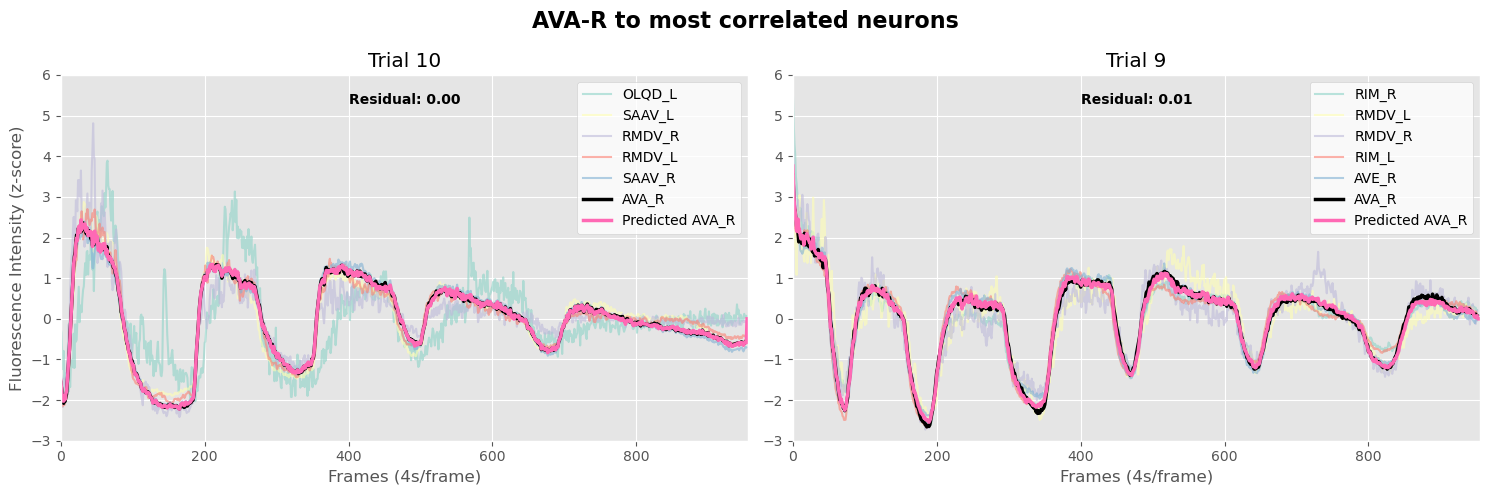

In [642]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("AVA-R to most correlated neurons", fontsize = 16, weight = 'bold')

palette = sns.color_palette("Set3", 5) 

for i in range(2): # len(all_traces)
    # ax = axs[i // 2, i % 2]
    ax = axs[i]
    for j in range(len(all_traces[i])):
        ax.plot(all_traces[i][j], label=all_names[i][j], color=palette[j], alpha = 0.6)

    ax.plot(lowest_residualTrials_AVA_R[i], label='AVA_R', color= 'black', linewidth = 2.5)
    ax.plot(predicted_AVA_R_traces_lowestResidualTrials[i], label = 'Predicted AVA_R', color = 'hotpink', linewidth = 2.5)

    residual_value = optimal_residuals_allTrials_AVA_right_toAll[lowest_residuals_indices[i]]
    ax.text(0.5, 0.95, f"Residual: {residual_value:.2f}", transform=ax.transAxes, ha="center", va="top", weight = 'bold') #plotting residual values for each trial, with two decimal places

    ax.set_title(f"Trial {lowest_residuals_original_indices[i] + 1}") #python indexes at 0
    ax.set_xlim(0,955)
    if i % 2 == 0: #only labeling odd plots (1,3,5,7,9)
        ax.set_ylabel("Fluorescence Intensity (z-score)")

    if i >= len(all_traces) - 2: #adding x-axis to last two plots (ax 9 and 10)
        ax.set_xlabel("Frames (4s/frame)")
    ax.legend(facecolor = 'white', loc = 'upper right')
    ax.set_ylim(-3,6)


plt.tight_layout()
plt.subplots_adjust(top = 0.85)
plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/AVA_R_residual_trials_weightedNeurons_top2", dpi = 900)
plt.show()

<font color='lightblue' size = 6>Something isn't working..... include ASJ and only top neurons agnostic to stimuli</font>

In [652]:
# Need to re-organize traces data so that the first index is each trial, and then each trial contains a matrix of 955x189 - 955 traces for each of the 189 neurons
head_traces_reindexed = []
for i in range(21):  
    trial_data = np.full((955, 189), np.nan) #initializing a matrix
    for j in range(189): 
        neuron_traces = head_traces[j][i] #getting the traces for the i'th trial, and j'th neuron 
        # Assign the traces to the corresponding column in trial_data
        trial_data[:len(neuron_traces), j] = neuron_traces

    head_traces_reindexed.append(trial_data)

head_traces_reindexed = np.array(head_traces_reindexed)


tail_traces_reindexed = []
for i in range(21):  
    trial_data = np.full((955, 42), np.nan) #initializing a matrix
    for j in range(42): 
        neuron_traces = tail_traces[j][i] #getting the traces for the i'th trial, and j'th neuron 
        # Assign the traces to the corresponding column in trial_data
        trial_data[:len(neuron_traces), j] = neuron_traces

    tail_traces_reindexed.append(trial_data)

tail_traces_reindexed = np.array(tail_traces_reindexed) # ASJ neuron is not in the tail, do not need to remove

ALLneuron_traces_ASJ_INCLUDED = np.concatenate((head_traces_reindexed, tail_traces_reindexed), axis=2)
# print(ALLneuron_traces_ASJ_INCLUDED.shape[2]) #231! All neurons included
ALLneuron_names_ASJ_INCLUDED = head_names + tail_names
# print(len(ALLneuron_names_ASJ_INCLUDED)) # 231!





### Going to isolate 10 neruons, with ASJ_L and ASJ_R included for every trial and re-run
print(ALLneuron_names_ASJ_INCLUDED.index("ASJ_L")) # 33
print(ALLneuron_names_ASJ_INCLUDED.index("ASJ_R")) # 34

TEST_splicedTraces_wASJ = []
for trial in ALLneuron_traces_ASJ_INCLUDED:
    isolated_data = trial[:, 30:40]
    TEST_splicedTraces_wASJ.append(isolated_data)

TEST_splicedTraces_wASJ = np.array(TEST_splicedTraces_wASJ)
print(len(TEST_splicedTraces_wASJ)) #21 trials
print(len(TEST_splicedTraces_wASJ[5])) #955 rows
print(TEST_splicedTraces_wASJ.shape[2]) #10 neurons


TEST_splicedNames_wASJ = ALLneuron_names_ASJ_INCLUDED[30:40]
print(TEST_splicedNames_wASJ)




TEST_splicedTraces_withoutASJ = []
for trial in ALLneuron_traces_ASJ_INCLUDED:
    isolated_data = trial[:, 0:10]
    TEST_splicedTraces_withoutASJ.append(isolated_data)

TEST_splicedTraces_withoutASJ = np.array(TEST_splicedTraces_withoutASJ)


TEST_splicedNames_withoutASJ = ALLneuron_names_ASJ_INCLUDED[0:10]
print(TEST_splicedNames_withoutASJ)





#isolating neurons that correlate with ASJ-R the most independent of stimuli
neuron_names = ["SIAV_L","RMF_L","RMH_R","AIM_L","RMF_R","AUA_L","SMBV_L","ASK_R", "I2_R", "AUA_R"]
neurons_to_index = [ALLneuron_names_ASJ_INCLUDED.index(name) for name in neuron_names]

TEST_HIGHESTcorrelated_ASJR = []
for trial in ALLneuron_traces_ASJ_INCLUDED:
    isolated_data = trial[:, neurons_to_index]
    TEST_HIGHESTcorrelated_ASJR.append(isolated_data)

TEST_HIGHESTcorrelated_ASJR_traces = np.array(TEST_HIGHESTcorrelated_ASJR)
print(len(TEST_HIGHESTcorrelated_ASJR_traces))
print(len(TEST_HIGHESTcorrelated_ASJR_traces[4]))
print(TEST_HIGHESTcorrelated_ASJR_traces.shape[2])

TEST_HIGHESTcorrelated_ASJR_names = [ALLneuron_names_ASJ_INCLUDED[i] for i in neurons_to_index]
print(TEST_HIGHESTcorrelated_ASJR_names)






#isolating neruons that correlate with ASJ-R the most stimuli inclusive
neuron_names_stimuli = ["AIA_R","AWA_L","RMDD_R","AWC_L","SIAV_L","NSM_L","AVD_R", "CEPV_L", "AVG", "RIF_L", "AIZ_R", "AIB_L", "URAV_L", "RIA_L", "RMDD_L", "RMD_R", "M1", "MI", "OLQD_L", "AIY_L", "AVD_L", "RMH_R", "ASI_L", "DB2", "SMBD_R", "ASI_R", "ASE_L", "SMBV_L", "CEPV_R"]
neurons_to_index_stimuli = [ALLneuron_names_ASJ_INCLUDED.index(name) for name in neuron_names_stimuli]

TEST_HIGHESTcorrelated_ASJR_stimuli = []
for trial in ALLneuron_traces_ASJ_INCLUDED:
    isolated_data = trial[:, neurons_to_index_stimuli]
    TEST_HIGHESTcorrelated_ASJR_stimuli.append(isolated_data)

TEST_HIGHESTcorrelated_ASJR_STIMULI_traces = np.array(TEST_HIGHESTcorrelated_ASJR_stimuli)
print(len(TEST_HIGHESTcorrelated_ASJR_STIMULI_traces))
print(len(TEST_HIGHESTcorrelated_ASJR_STIMULI_traces[4]))
print(TEST_HIGHESTcorrelated_ASJR_STIMULI_traces.shape[2]) # 29 neurons

TEST_HIGHESTcorrelated_ASJR_STIMULI_names = [ALLneuron_names_ASJ_INCLUDED[i] for i in neurons_to_index_stimuli]
print(TEST_HIGHESTcorrelated_ASJR_STIMULI_names)


#isolating neruons that correlate with ASJ-L the most stimuli inclusive
neuron_names_stimuli_L = ["AIA_R","AWA_R","AVL","ADF_L","AIA_L","AVJ_L", "M3_L", "AWC_L", "AWC_R", "AIZ_L", "M1", "AVG", "AVD_L", "ASH_R", "AWB_R", "AUA_L", "AIB_L", "OLQD_R", "RIC_R", "AIZ_R", "ASI_L", "RIF_L", "ASE_L", "AUA_R", "AVH_L", "DB2", "ASG_L"]
neurons_to_index_stimuli = [ALLneuron_names_ASJ_INCLUDED.index(name) for name in neuron_names_stimuli_L]

TEST_HIGHESTcorrelated_ASJL_stimuli = []
for trial in ALLneuron_traces_ASJ_INCLUDED:
    isolated_data = trial[:, neurons_to_index_stimuli]
    TEST_HIGHESTcorrelated_ASJL_stimuli.append(isolated_data)

TEST_HIGHESTcorrelated_ASJL_STIMULI_traces = np.array(TEST_HIGHESTcorrelated_ASJL_stimuli)
print(len(TEST_HIGHESTcorrelated_ASJL_STIMULI_traces))
print(len(TEST_HIGHESTcorrelated_ASJL_STIMULI_traces[4]))
print(TEST_HIGHESTcorrelated_ASJL_STIMULI_traces.shape[2]) # 29 neurons

TEST_HIGHESTcorrelated_ASJL_STIMULI_names = [ALLneuron_names_ASJ_INCLUDED[i] for i in neurons_to_index_stimuli]
print(TEST_HIGHESTcorrelated_ASJL_STIMULI_names)



33
34
21
955
10
['ASH_R', 'ASI_L', 'ASI_R', 'ASJ_L', 'ASJ_R', 'ASK_L', 'ASK_R', 'AUA_L', 'AUA_R', 'AVA_L']
['ADA_L', 'ADA_R', 'ADE_L', 'ADE_R', 'ADF_L', 'ADF_R', 'ADL_L', 'ADL_R', 'AFD_L', 'AFD_R']
21
955
10
['SIAV_L', 'RMF_L', 'RMH_R', 'AIM_L', 'RMF_R', 'AUA_L', 'SMBV_L', 'ASK_R', 'I2_R', 'AUA_R']
21
955
29
['AIA_R', 'AWA_L', 'RMDD_R', 'AWC_L', 'SIAV_L', 'NSM_L', 'AVD_R', 'CEPV_L', 'AVG', 'RIF_L', 'AIZ_R', 'AIB_L', 'URAV_L', 'RIA_L', 'RMDD_L', 'RMD_R', 'M1', 'MI', 'OLQD_L', 'AIY_L', 'AVD_L', 'RMH_R', 'ASI_L', 'DB2', 'SMBD_R', 'ASI_R', 'ASE_L', 'SMBV_L', 'CEPV_R']
21
955
27
['AIA_R', 'AWA_R', 'AVL', 'ADF_L', 'AIA_L', 'AVJ_L', 'M3_L', 'AWC_L', 'AWC_R', 'AIZ_L', 'M1', 'AVG', 'AVD_L', 'ASH_R', 'AWB_R', 'AUA_L', 'AIB_L', 'OLQD_R', 'RIC_R', 'AIZ_R', 'ASI_L', 'RIF_L', 'ASE_L', 'AUA_R', 'AVH_L', 'DB2', 'ASG_L']


In [653]:
# Total neurons (unique) correlated with ASJL and ASJR across all stimuli
combined_list = neuron_names_stimuli + neuron_names_stimuli_L

# Convert to a set to remove duplicates, then convert back to a list
unique_names = list(set(combined_list))

print(len(unique_names))

45


In [658]:
optimal_weights_ASJ_left_TEST, optimal_residuals_allTrials_ASJ_left_TEST, predicted_traces_ASJ_left_TEST, processed_trials_indices_ASJ_L_TEST = optimize_weights(TEST_HIGHESTcorrelated_ASJL_STIMULI_traces, ASJ_L, 'stimuli')
# print(len(optimal_residuals_allTrials_ASJ_left_TEST)) # len is 17, as there are 4 trials where the ASJ trace is empty
# print(len(optimal_weights_ASJ_left_TEST[0])) # 29 - for each neuron
# print(len(predicted_traces_ASJ_left_TEST)) # 17 - for the 17 trials
# print(len(predicted_traces_ASJ_left_TEST[4])) # 955 - for the 955 trace values for the 5th trial

# optimal_weights_ASJ_right_TEST, optimal_residuals_allTrials_ASJ_right_TEST, predicted_traces_ASJ_right_TEST, processed_trials_indices_ASJ_R_TEST= optimize_weights(TEST_HIGHESTcorrelated_ASJR_STIMULI_traces, ASJ_R, 'stimuli')
# print(len(optimal_residuals_allTrials_ASJ_right_TEST)) # len is 20, as there is 1 trials where the ASJ trace is empty
# print(optimal_weights_ASJ_right_TEST)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 29 is different from 27)

In [659]:
# Isolating lowest residual trials, and then best scoring neurons (highest weight), and plotting against ASJ
lowest_residuals_indices = np.argsort(optimal_residuals_allTrials_ASJ_left_TEST)[:10] # add [::-1] to have in descending order
print(lowest_residuals_indices) # [15 19 18  5  6 13  2 14 17  3] for ASJ-R
# print(type(lowest_residuals_indices))

#isolating neurons from lowest residual trial, and ASJ_R traces from lowest residual trials
lowest_residuals_neurons = [optimal_weights_ASJ_left_TEST[i] for i in lowest_residuals_indices] # 10 arrays, each containing 229 values (weights of neurons)
# for i, trial in enumerate(lowest_residuals_neurons):
#     print(f"Trial {i+1}: {trial[:5]}")


# Must re-index to get the original trial indexes since the optimize function skips ASJ trials that are empty
lowest_residuals_original_indices = [processed_trials_indices_ASJ_L_TEST[i] for i in lowest_residuals_indices]
print(lowest_residuals_original_indices)
lowest_residuals_original_indices_forINDEXING = np.array(lowest_residuals_original_indices)




#Getting corresponding traces for low residual trials for ASJ_R
# ASJ_R_array = np.array(ASJ_R)
# ASJ_R_filtered = np.array([trial for trial in ASJ_R_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing
# lowest_residualTrials_ASJ_R = ASJ_R_filtered[lowest_residuals_indices]


# Getting corresponding traces for low residual trials for ASJ_L
ASJ_L_array = np.array(ASJ_L)
ASJ_L_filtered = np.array([trial for trial in ASJ_L_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing
lowest_residualTrials_ASJ_L = ASJ_L_filtered[lowest_residuals_indices]

#Getting corresponding traces for low residual trials from the MASTER list for all other neurons
lowest_residual_trials = TEST_HIGHESTcorrelated_ASJL_STIMULI_traces[lowest_residuals_original_indices_forINDEXING] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955x10 neurons and corresponding traces
 
#Getting the predicted ASJ_R traces from the optimize_weights function for the low residual trials 
predicted_ASJ_L_traces_lowestResidualTrials = [predicted_traces_ASJ_left_TEST[i] for i in lowest_residuals_indices] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955 traces for the predicted ASJ_R
# predicted_ASJ_R_traces_lowestResidualTrials = [predicted_traces_ASJ_right_TEST[i] for i in lowest_residuals_indices] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955 traces for the predicted ASJ_R


all_traces = []
all_names = []
for trial, weight in enumerate(lowest_residuals_neurons):
    highestWeightNeurons_w_lowestResiduals = np.argsort(weight)[-5:] #isolating indices of top 5 neurons that had the highest weights, within the top 10 lowest residual trials
    print(weight[-5:]) # the neurons do have weights associated with them... many are small though: <1
    
    # Get the corresponding traces and names for these neurons
    traces = lowest_residual_trials[trial, :, highestWeightNeurons_w_lowestResiduals] #lowest_residual_trials contains 10 matrices, each for a trial, of 955 rows by 187 neurons, and I need to isolate the top 5 scoring neurons (columns) and all of their traces!
    names = [TEST_HIGHESTcorrelated_ASJL_STIMULI_names[i] for i in highestWeightNeurons_w_lowestResiduals]

    # Add the traces and names for this trial to the overall lists
    all_traces.append(traces)
    all_names.append(names)


[14  7  1  8 12 10  6  4  0  3]
[16, 8, 1, 9, 14, 11, 6, 4, 0, 3]
[0.81439066 0.85878141 0.32095129 0.71931961 0.93237451]
[0.02127883 0.47610167 0.42697769 0.31785601 0.82526784]
[0.72621392 0.90430861 0.86753047 0.66764892 0.51876954]
[0.29942002 0.97820089 0.56464056 0.85003436 0.4558    ]
[0.68231445 0.67821309 0.91540784 0.78532068 0.34713209]
[0.20427681 0.42498496 0.81225017 0.01896412 0.48174666]
[0.61894929 0.59601249 0.85776143 0.12441618 0.45648092]
[0.12585814 0.91253884 0.09056829 0.0166798  0.84169343]
[0.63725693 0.44096832 0.17227154 0.29583102 0.89517658]
[0.94813854 0.99299882 0.90667251 0.20963581 0.10967533]


/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/937080096.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ASJ_L_array = np.array(ASJ_L)
/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/937080096.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ASJ_L_filtered = np.array([trial for trial in ASJ_L_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing


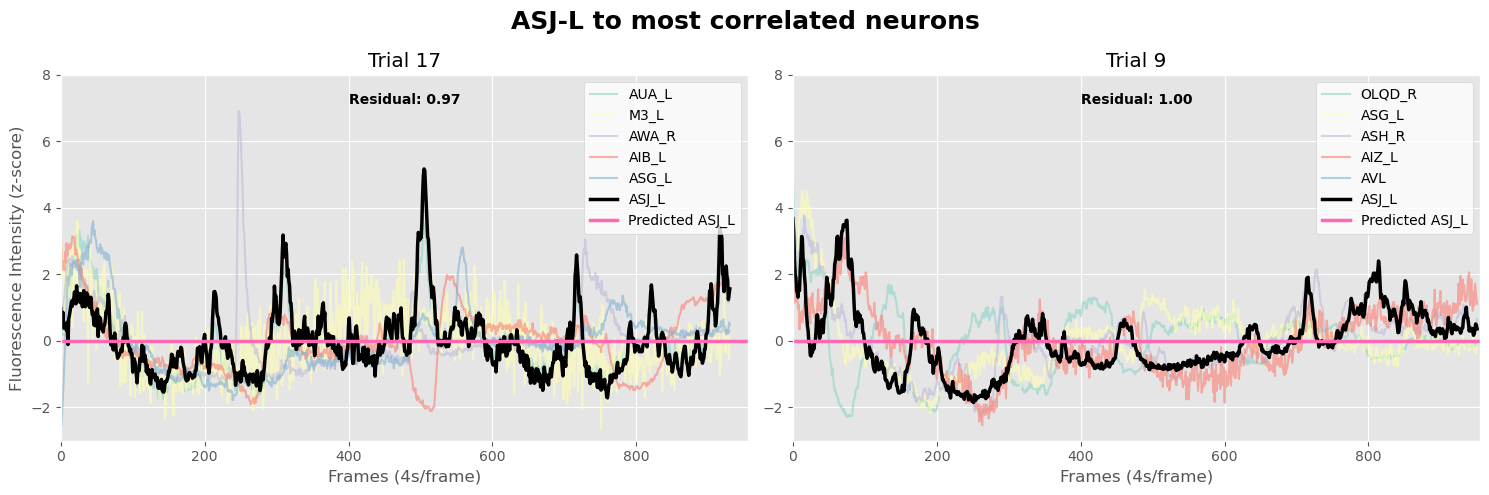

In [661]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("ASJ-L to all correlated neurons", fontsize = 18, weight = 'bold')

palette = sns.color_palette("Set3", 5) 

for i in range(2): #len(all_traces)
    ax = axs[i]
    # ax = axs[i // 2, i % 2] # a way to create subplot indices such as [0,0].... up unto [4,1] (5x2)

    for j in range(len(all_traces[i])):
        ax.plot(all_traces[i][j], label=all_names[i][j], color=palette[j], alpha = 0.6)

    ax.plot(lowest_residualTrials_ASJ_L[i], label='ASJ_L', color= 'black', linewidth = 2.5)
    ax.plot(predicted_ASJ_L_traces_lowestResidualTrials[i], label = 'Predicted ASJ_L', color = 'hotpink', linewidth = 2.5)

    residual_value = optimal_residuals_allTrials_ASJ_left_TEST[lowest_residuals_indices[i]]
    ax.text(0.5, 0.95, f"Residual: {residual_value:.2f}", transform=ax.transAxes, ha="center", va="top", weight = 'bold') #plotting residual values for each trial, with two decimal places

    ax.set_title(f"Trial {lowest_residuals_original_indices[i] + 1}") #python indexes at 0
    ax.set_xlim(0,955)
    if i % 2 == 0: #only labeling odd plots (1,3,5,7,9)
        ax.set_ylabel("Fluorescence Intensity (z-score)")

    if i >= len(all_traces) - 2: #adding x-axis to last two plots (ax 9 and 10)
        ax.set_xlabel("Frames (4s/frame)")
    ax.set_xlabel("Frames (4s/frame)")
    ax.legend(facecolor = 'white', loc = 'upper right')
    ax.set_ylim(-3,8)

plt.tight_layout()
plt.subplots_adjust(top = 0.85)
# plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/ASJ_L_residual_trials_weightedNeurons_correlatedStimuliInclusive_TOP2.png", dpi = 900)
plt.show()

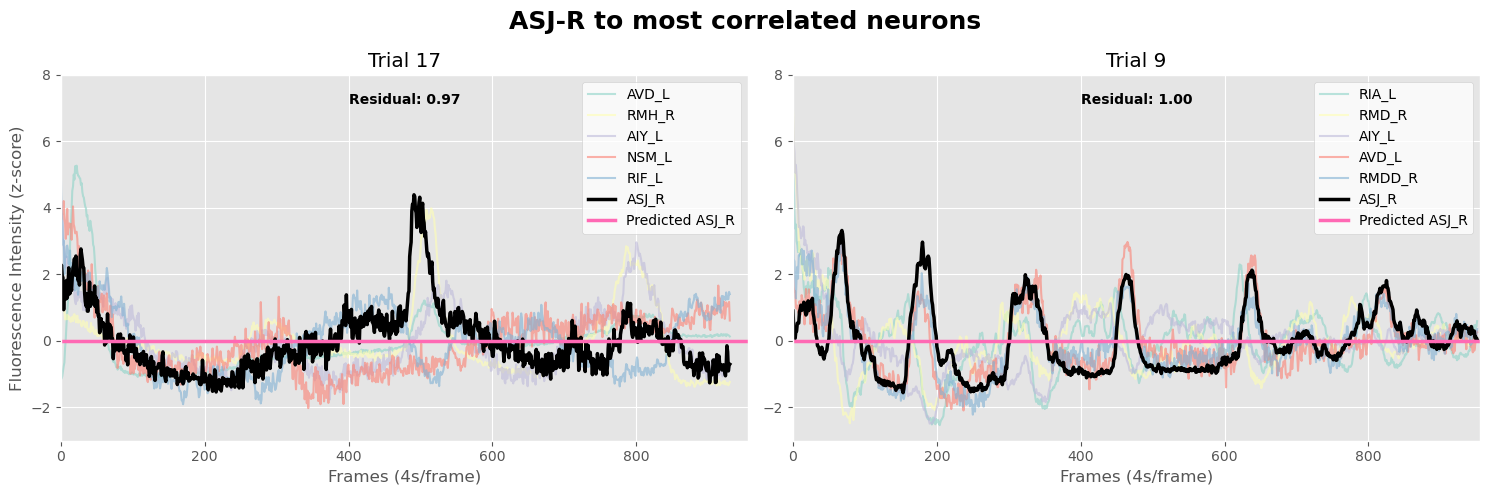

In [657]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("ASJ-R to all correlated neurons", fontsize = 18, weight = 'bold')

palette = sns.color_palette("Set3", 5) 

for i in range(2): #len(all_traces)
    ax = axs[i]
    #ax = axs[i // 2, i % 2] # a way to create subplot indices such as [0,0].... up unto [4,1] (5x2)

    for j in range(len(all_traces[i])):
        ax.plot(all_traces[i][j], label=all_names[i][j], color=palette[j], alpha = 0.6)

    ax.plot(lowest_residualTrials_ASJ_R[i], label='ASJ_R', color= 'black', linewidth = 2.5)
    ax.plot(predicted_ASJ_R_traces_lowestResidualTrials[i], label = 'Predicted ASJ_R', color = 'hotpink', linewidth = 2.5)

    residual_value = optimal_residuals_allTrials_ASJ_right_TEST[lowest_residuals_indices[i]]
    ax.text(0.5, 0.95, f"Residual: {residual_value:.2f}", transform=ax.transAxes, ha="center", va="top", weight = 'bold') #plotting residual values for each trial, with two decimal places

    ax.set_title(f"Trial {lowest_residuals_original_indices[i] + 1}") #python indexes at 0
    ax.set_xlim(0,955)
    if i % 2 == 0: #only labeling odd plots (1,3,5,7,9)
        ax.set_ylabel("Fluorescence Intensity (z-score)")

    if i >= len(all_traces) - 2: #adding x-axis to last two plots (ax 9 and 10)
        ax.set_xlabel("Frames (4s/frame)")
    ax.legend(facecolor = 'white', loc = 'upper right')
    ax.set_xlabel("Frames (4s/frame)")
    ax.set_ylim(-3,8)

plt.tight_layout()
plt.subplots_adjust(top = 0.85)
# plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/ASJ_R_residual_trials_weightedNeurons_correlatedStimuliInclusive_TOP2.png", dpi = 900)
plt.show()

<font color='red' size = 6>Plot illustrating residual calculation and neuron weight</font>

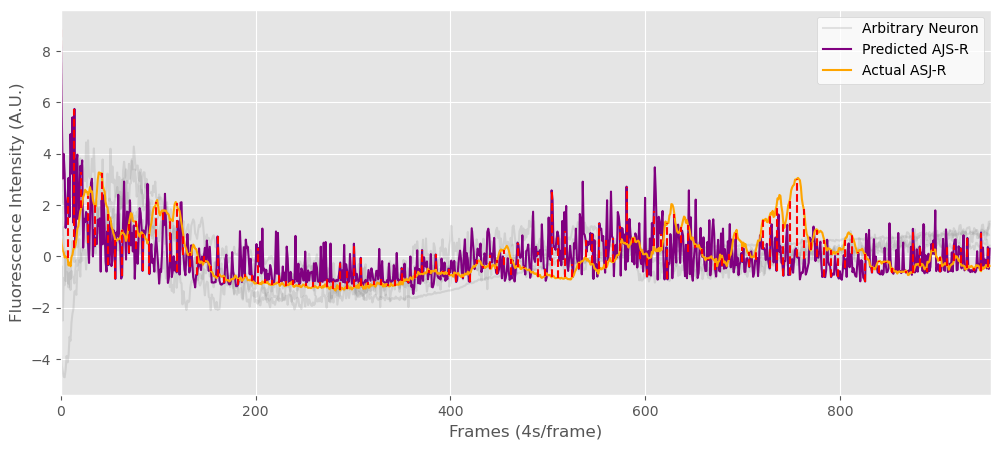

In [90]:
# Make a mock plot to represent how cost is calculated
Random_neuronTrace = head_traces_reindexed[3][:,0] # 0 and 3 are good...
RandomNeuronTrace2 = head_traces_reindexed[17][:,0]
RandomNeuronTrace3 = head_traces_reindexed[13][:,0]
RandomNeuronTrace4 = head_traces_reindexed[1][:,0]
RandomNeuronTrace5 = head_traces_reindexed[20][:,0]

ASJ_neuronTraceR = ASJ_R[0]

### ADD TEXT FOR RESIDUAL AND NEURON WEIGHT ###

plt.style.use('ggplot')
plt.figure(figsize = (12,5))
plt.plot(RandomNeuronTrace2, color = 'grey', alpha = 0.2, label = 'Arbitrary Neuron')
plt.plot(RandomNeuronTrace3, color = 'grey', alpha = 0.2)
plt.plot(RandomNeuronTrace4, color = 'grey', alpha = 0.2)
plt.plot(RandomNeuronTrace5, color = 'grey', alpha = 0.2)
plt.plot(Random_neuronTrace, color = 'purple', label = 'Predicted AJS-R')
plt.plot(ASJ_neuronTraceR, color = 'orange', label = 'Actual ASJ-R')
plt.legend(facecolor = 'white', loc = 'upper right')

for i in range(0, len(Random_neuronTrace), 7):
    if Random_neuronTrace[i] > ASJ_neuronTraceR[i]:
        plt.plot([i, i], [ASJ_neuronTraceR[i], Random_neuronTrace[i]], color='red', linestyle='--')
    if Random_neuronTrace[i] < ASJ_neuronTraceR[i]:
        plt.plot([i, i], [Random_neuronTrace[i], ASJ_neuronTraceR[i]], color='red', linestyle='--')

plt.xlim(0,955)
# plt.ylim(-1.0,1.5)
plt.ylabel('Fluorescence Intensity (z-score)')
plt.xlabel('Frames (4s/frame)')
#plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/Cost_plot_example', dpi = 900)
plt.show()

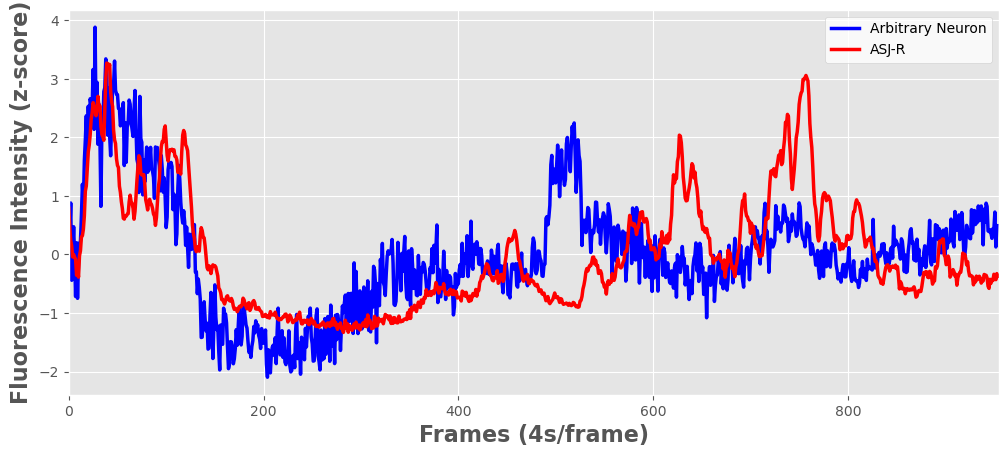

In [591]:
# Make a mock plot to represent how cost is calculated
Random_neuronTrace2 = head_traces_reindexed[11][:,0] # 0 and 3 are good...

ASJ_neuronTraceR = ASJ_R[0]

### ADD TEXT FOR RESIDUAL AND NEURON WEIGHT ###

plt.style.use('ggplot')
plt.figure(figsize = (12,5))
plt.plot(Random_neuronTrace2, color = 'blue', label = 'Arbitrary Neuron', linewidth = 2.5)
plt.plot(ASJ_neuronTraceR, color = 'red', label = 'ASJ-R', linewidth = 2.5)
plt.legend(facecolor = 'white', loc = 'upper right')

plt.xlim(0,955)
# plt.ylim(-1.0,1.5)
plt.ylabel('Fluorescence Intensity (z-score)', weight = 'bold', fontsize = 16)
plt.xlabel('Frames (4s/frame)', weight = 'bold', fontsize = 16)
# plt.savefig('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/examplePlot_forTraces_YAXIS.png', dpi = 900)
plt.show()

<font color='cyan' size = 8>Using scikit linear regression</font>

Using from sklearn.linear_model import LinearRegression

x will be a mulitple column vector with rows being corresponding traces
y will be a column matrix with actual ASJ traces

coefficients for each will effectively be the weights of each neruon contributing to ASJ trace

set fit_intercept to FALSE!!!!!!!!


And also test with AVA!

In [400]:
### Prepping data ###
ASJ_R_corrNeurons_linearRegression = TEST_HIGHESTcorrelated_ASJR_STIMULI_traces
#print(ASJ_R_corrNeurons_linearRegression[0].shape) # 21 trails, each with a matrix of 955 rows, and 29 neurons! So already in a column matrix
# print(len(ASJ_R_corrNeurons_linearRegression)) # length is 21, for each trial

ASJ_R_columnVectors = []
for trial in ASJ_R:
    ASJ_R_columnVectors.append(trial[...,None])

ASJ_R_columnVectors = np.array(ASJ_R_columnVectors)
# print(len(ASJ_R_columnVectors)) #21
# print(len(ASJ_R_columnVectors[0])) # 955 - now a column vector

/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/3362608116.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ASJ_R_columnVectors = np.array(ASJ_R_columnVectors)


In [401]:
### Quality control of data
count = 0
for trial in ASJ_R_corrNeurons_linearRegression:
    if np.isnan(trial).any():
        count += 1
print(count) #So all trials contain at least one NaN value.....

for i, trial in enumerate(ASJ_R_columnVectors):
    if len(trial) == 0:
        print(i) #trial 7 (index 6) is empty


21
6


In [402]:
### Filtering out trials that don't contain data for ASJ_R_columnVectors
ASJ_R_columnVectorsFiltered = np.delete(ASJ_R_columnVectors, 6)
ASJ_R_corrNeurons_linearRegressionFiltered = np.delete(ASJ_R_corrNeurons_linearRegression, 6, axis=0) #axis=0 specifies that it is deleting the index of a 2D array (so all rows and columns)
# print(len(ASJ_R_columnVectorsFiltered)) 
# print(len(ASJ_R_corrNeurons_linearRegressionFiltered)) #both are now 20

for i, trial in enumerate(ASJ_R_columnVectorsFiltered):
    if len(trial) != 955:
        print(i, len(trial)) #so there are many trials that do not contain all 955 traces

1 954
4 954
7 952
8 954
10 954
13 954
15 931


In [418]:
### Running the regression ###
#filling NaN values with 0
ASJ_R_corrNeurons_linearRegression_NanFilled = np.nan_to_num(ASJ_R_corrNeurons_linearRegressionFiltered)

regression_models = []
for i, trial in enumerate(ASJ_R_corrNeurons_linearRegression_NanFilled):
    if np.any(trial): #ensuring that all of the traces within a trial are not equal to zero
        min_length = min(len(trial), len(ASJ_R_columnVectorsFiltered[i])) #for some trials of ASJ_R_columnVectorsFiltered, there are only 954 traces, or 952, or 931
        if min_length > 0:
            regression = LinearRegression(fit_intercept = False).fit(trial[:min_length], ASJ_R_columnVectorsFiltered[i][:min_length])
            regression_models.append(regression)

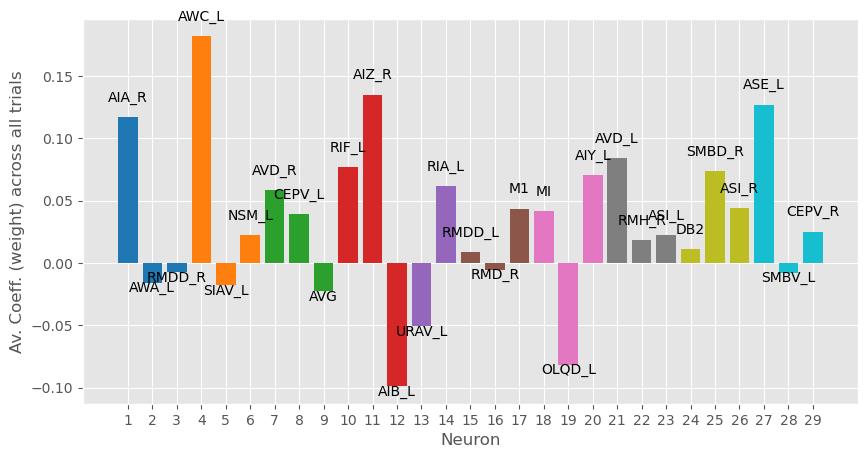

In [419]:
coefficients = [model.coef_ for model in regression_models]
average_coefficients = np.mean(coefficients, axis=0)
average_coefficients = average_coefficients.flatten()

#Adding names to plot
NAMES = TEST_HIGHESTcorrelated_ASJR_STIMULI_names #a list of strings, which are the neuron names

colors = cm.tab10(np.linspace(0, 1, len(average_coefficients)))

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
bars = plt.bar(range(1, len(average_coefficients) + 1), average_coefficients, color = colors)
plt.xticks(range(1, len(average_coefficients) + 1))
plt.xlabel('Neuron')
plt.ylabel('Av. Coeff. (weight) across all trials')

for bar, name in zip(bars, NAMES):
    yval = bar.get_height()
    if yval < 0:  # if the bar is below the x-axis
        yval -= 0.01  # adjust the position to be below the bar
    else:
        yval += 0.01  # adjust the position to be above the bar
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, name, va='bottom', ha='center')

plt.show()

/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/mambaforge/envs/ASJ_neuron_2/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


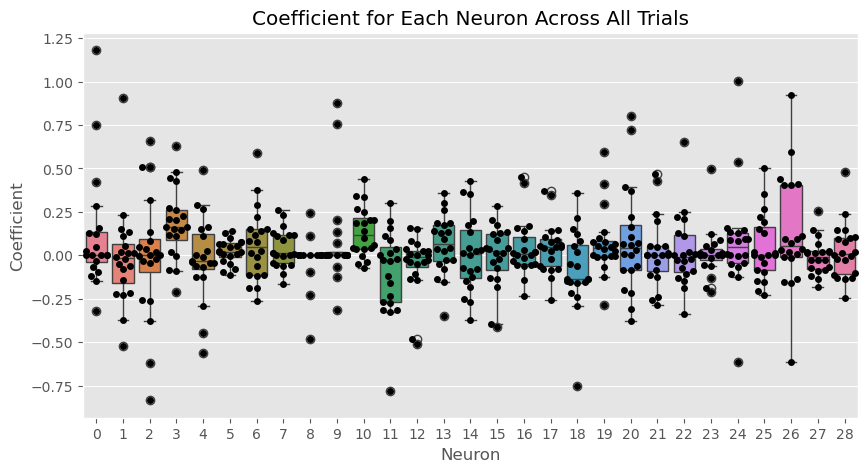

In [420]:
coefficients = [model.coef_.flatten() for model in regression_models]
coefficients_per_neuron = list(map(list, zip(*coefficients))) #transpose to get a list for each neuron

plt.figure(figsize=(10, 5))
sns.boxplot(data=coefficients_per_neuron)
sns.swarmplot(data = coefficients_per_neuron, color = 'black')
plt.xlabel('Neuron')
plt.ylabel('Coefficient')
plt.title('Coefficient for Each Neuron Across All Trials')
plt.show()

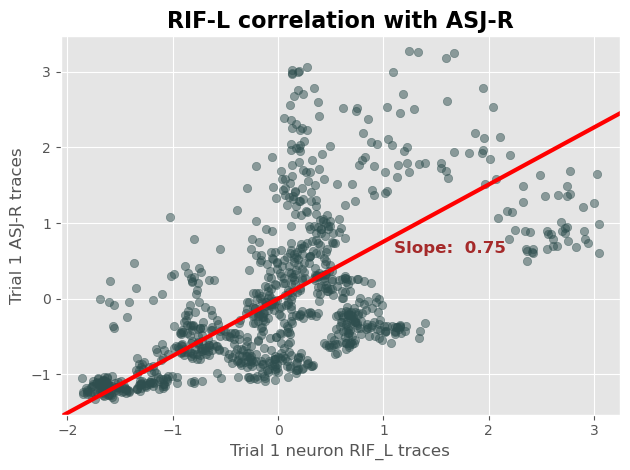

In [519]:
### Plotting how the regression works! ###

weights = [model.coef_ for model in regression_models]

neuronNames_R = TEST_HIGHESTcorrelated_ASJR_STIMULI_names #a list of strings, which are the neuron names

# for i in range(len(weights[0][0])): #first trial, all 29 neurons
#     plt.title(f"Neuron {i+1}", fontsize = 16, weight = 'bold')
    
#     x_values = range(-len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,i]), len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,i]))
#     y_values = [weights[0][0][i]*x for x in x_values] # weights for the first trial
#     plt.plot(x_values, y_values, color = 'deepskyblue', linewidth = 3)
    
#     plt.scatter(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,i], ASJ_R_columnVectorsFiltered[0][:len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,i])], color = 'darkred') #first trial, each neuron against ASJ trace
#     plt.xlim(min(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,i]),max(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,i]))
#     plt.ylim(min(ASJ_R_columnVectorsFiltered[0][:len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,i])]), max(ASJ_R_columnVectorsFiltered[0][:len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,i])]))

#     plt.ylabel("Trial 1 ASJ-R traces")
#     plt.xlabel(f"Trial 1 neuron {neuronNames_R[i]} traces")

#     plt.show()

neuron_index = 9
plt.title("RIF-L correlation with ASJ-R", fontsize = 16, weight = 'bold')

x_values = range(-len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,neuron_index]), len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,neuron_index]))
y_values = [weights[0][0][neuron_index]*x for x in x_values] # weights for the first trial
plt.plot(x_values, y_values, color = 'red', linewidth = 3)

slope = weights[0][0][neuron_index]
plt.text(1.1, 0.6, f'Slope: {slope: .2f}', fontsize=12, weight = 'bold', color = 'brown')

plt.scatter(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,neuron_index], ASJ_R_columnVectorsFiltered[0][:len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,neuron_index])], color = 'darkslategray', alpha = 0.5) #first trial, each neuron against ASJ trace
plt.xlim(min(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,neuron_index]) - 0.2,max(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,neuron_index]) + 0.2)
plt.ylim(min(ASJ_R_columnVectorsFiltered[0][:len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,neuron_index])] - 0.2), max(ASJ_R_columnVectorsFiltered[0][:len(ASJ_R_corrNeurons_linearRegression_NanFilled[0][:,neuron_index])] + 0.2))

plt.ylabel("Trial 1 ASJ-R traces")
plt.xlabel(f"Trial 1 neuron {neuronNames_R[neuron_index]} traces")

plt.tight_layout()
# plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/LinearRegression_example.png", dpi = 900)
plt.show()


<font color='red' size = 6>Now using the coeff (weights) to predict ASJ's activity</font>

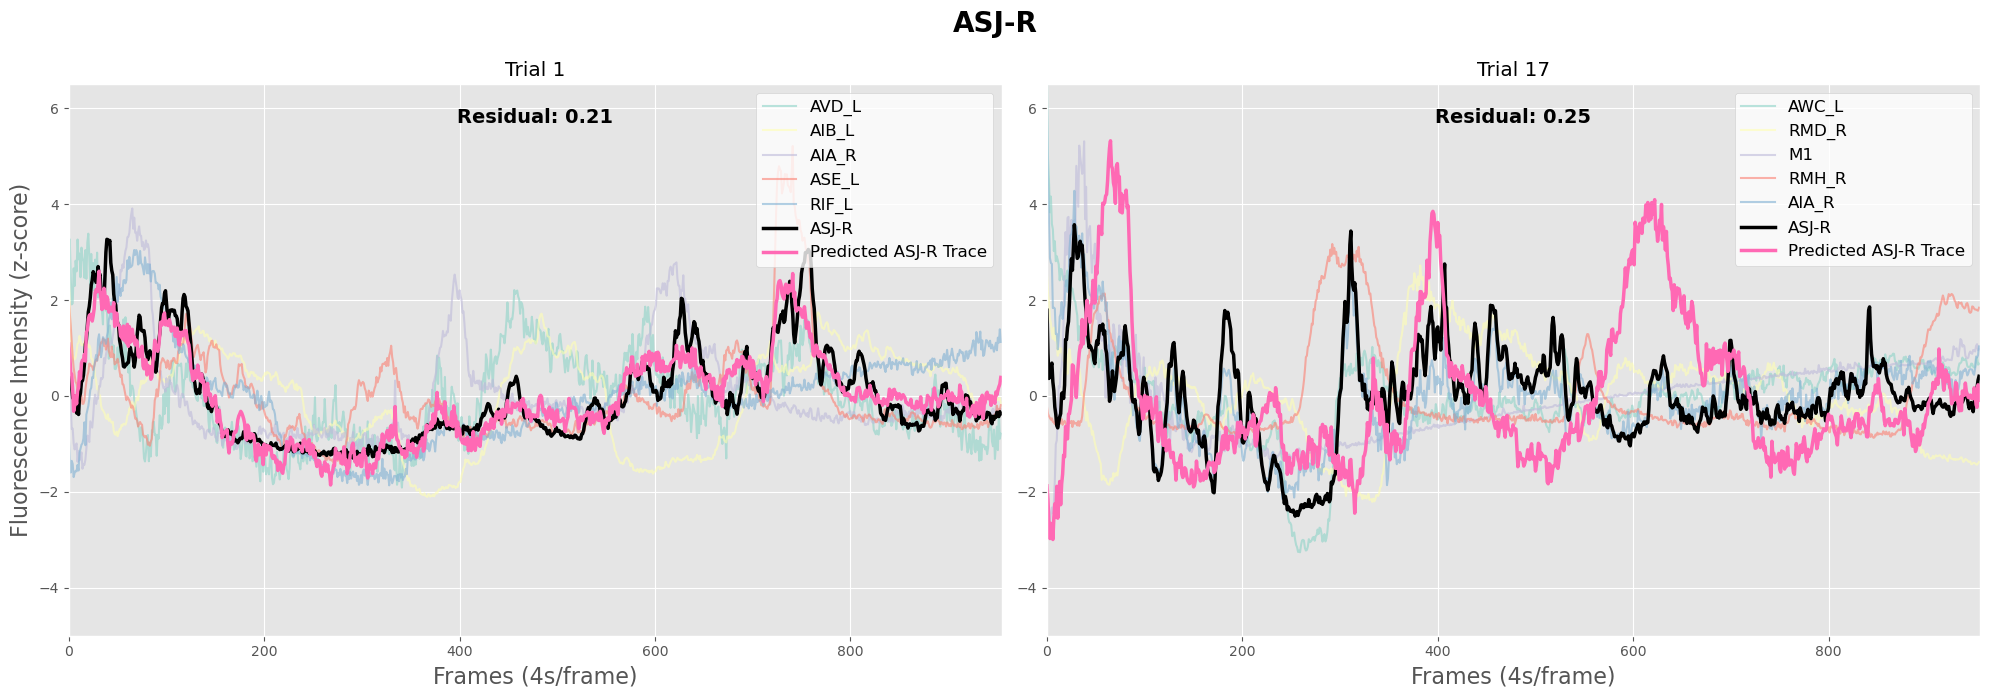

In [663]:
weights = [model.coef_ for model in regression_models]
residuals = []

# Calculate residuals for all trials
for trial in range(0,19):
    ASJ_R_trial_trace = ASJ_R_columnVectorsFiltered[trial]
    T = len(ASJ_R_trial_trace)
    raw_ASJ_R_trial = np.matmul(ASJ_R_corrNeurons_linearRegression_NanFilled, np.diag(weights[trial][0]))
    predicted_ASJ_R_trial = np.nansum(raw_ASJ_R_trial, axis = 1)

    min_length = min(len(predicted_ASJ_R_trial), len(ASJ_R_trial_trace))
    residual_value = np.sum((predicted_ASJ_R_trial[:min_length] - ASJ_R_trial_trace[:min_length])**2 / T) 
    residuals.append(residual_value)

# Get indices of six lowest residuals
lowest_residual_indices = np.argsort(residuals)[:2]

# Create 3x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs = axs.flatten()

# Plot trials with lowest residuals
for i, trial in enumerate(lowest_residual_indices):
    ax = axs[i]
    ASJ_R_trial_trace = ASJ_R_columnVectorsFiltered[trial]
    T = len(ASJ_R_trial_trace)
    raw_ASJ_R_trial = np.matmul(ASJ_R_corrNeurons_linearRegression_NanFilled, np.diag(weights[trial][0]))
    predicted_ASJ_R_trial = np.nansum(raw_ASJ_R_trial[0], axis = 1)

    min_length = min(len(predicted_ASJ_R_trial), len(ASJ_R_trial_trace))
    residual_value = residuals[trial]

    highWeightNeuron_indices = np.argsort(weights[trial][0])[-5:]
    neuron_names = [NAMES[i] for i in highWeightNeuron_indices.tolist()] 
    neuron_names_str = ', '.join(neuron_names)
    
    plt.suptitle('ASJ-R to all correlated neurons', fontsize=20, weight = 'bold', y=0.99)
    ax.set_ylim(-5,6.5)
    for j in range(len(highWeightNeuron_indices)):
        ax.plot(ASJ_R_corrNeurons_linearRegression_NanFilled[trial][:,highWeightNeuron_indices[j]], color = palette[j], label = neuron_names[j], alpha = 0.6)
    
    ax.plot(ASJ_R_trial_trace, color = 'black', label = 'ASJ-R', linewidth = 2.5)
    ax.plot(predicted_ASJ_R_trial, color = 'hotpink', label = 'Predicted ASJ-R Trace', linewidth = 2.5)
    x_center = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2
    ax.text(x_center, ax.get_ylim()[1] - 0.5, f"Residual: {residual_value:.2f}", ha="center", va="top", weight = 'bold', fontsize = 14)
    # ax.text(ax.get_xlim()[0]+75, ax.get_ylim()[1] - 0.7, neuron_names_str, fontsize = 16, weight = 'bold')
    ax.legend(facecolor = 'white', loc = 'upper right', fontsize = 12)

    ax.set_xlim(0,955)
    if i in [0, 1]:  #last two
        ax.set_xlabel('Frames (4s/frame)', fontsize = 16)
    if i % 2 == 0:  #only odd
        ax.set_ylabel('Fluorescence Intensity (z-score)', fontsize = 16)
    ax.set_title(f'Trial {trial + 1}')

plt.tight_layout()
# plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/LinearRegression_ASJR_top2Trials.png", dpi = 900)
plt.show()


<font color='red' size = 6>Now perform for ASJ-L!</font>

In [570]:
### Prepping data ###
ASJ_L_corrNeurons_linearRegression = TEST_HIGHESTcorrelated_ASJL_STIMULI_traces
# print(ASJ_L_corrNeurons_linearRegression[0].shape) # 21 trails, each with a matrix of 955 rows, and 27 neurons! So already in a column matrix
# print(len(ASJ_L_corrNeurons_linearRegression)) # length is 21, for each trial

ASJ_L_columnVectors = []
for trial in ASJ_L:
    ASJ_L_columnVectors.append(trial[...,None])

ASJ_L_columnVectors = np.array(ASJ_L_columnVectors)
# print(len(ASJ_L_columnVectors)) #21
# print(len(ASJ_L_columnVectors[0])) # 955 - now a column vector

/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/713067711.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ASJ_L_columnVectors = np.array(ASJ_L_columnVectors)


In [571]:
### Quality control of data
count = 0
for trial in ASJ_L_corrNeurons_linearRegression:
    if np.isnan(trial).any():
        count += 1
print(count) #So all trials contain at least one NaN value.....

empty_indices = []
for i, trial in enumerate(ASJ_L_columnVectors):
    if len(trial) == 0:
        empty_indices.append(i) #indices 7, 12, 18, and 20 are empty!!!
print(empty_indices)

21
[7, 12, 18, 20]


In [572]:
### Filtering out trials that don't contain data for ASJ_L_columnVectors
ASJ_L_columnVectorsFiltered = np.delete(ASJ_L_columnVectors, empty_indices)
ASJ_L_corrNeurons_linearRegressionFiltered = np.delete(ASJ_L_corrNeurons_linearRegression, empty_indices, axis=0) #axis=0 specifies that it is deleting the index of a 2D array (so all rows and columns)
# print(len(ASJ_L_columnVectorsFiltered)) 
# print(len(ASJ_L_corrNeurons_linearRegressionFiltered)) #both are now 20

for i, trial in enumerate(ASJ_L_columnVectorsFiltered):
    if len(trial) != 955:
        print(i, len(trial)) #so there are many trials that do not contain all 955 traces

1 954
4 954
6 954
7 952
8 954
10 954
12 954
14 931


In [573]:
### Running the regression ###
#filling NaN values with 0
ASJ_L_corrNeurons_linearRegression_NanFilled = np.nan_to_num(ASJ_L_corrNeurons_linearRegressionFiltered)

regression_models_L = []
successful_trials = []  # List to keep track of successful trials
for i, trial in enumerate(ASJ_L_corrNeurons_linearRegression_NanFilled):
    if np.any(trial): #ensuring that all of the traces within a trial are not equal to zero
        min_length = min(len(trial), len(ASJ_L_columnVectorsFiltered[i])) #for some trials of ASJ_L_columnVectorsFiltered, there are only 954 traces, or 952, or 931
        if min_length > 0:
            regression_L = LinearRegression(fit_intercept = False).fit(trial[:min_length], ASJ_L_columnVectorsFiltered[i][:min_length])
            regression_models_L.append(regression_L)
            successful_trials.append(i)  #tracking index of successful trials, as two fail (15/17)

# Filter ASJ_L_corrNeurons_linearRegression_NanFilled using successful_trials
ASJ_L_corrNeurons_linearRegression_NanFilled = ASJ_L_corrNeurons_linearRegression_NanFilled[successful_trials]

weights_L = [model.coef_ for model in regression_models_L]
print(len(weights_L))  # This should now be equal to the length of ASJ_L_corrNeurons_linearRegression_NanFilled
print(len(ASJ_L_corrNeurons_linearRegression_NanFilled))

17
17


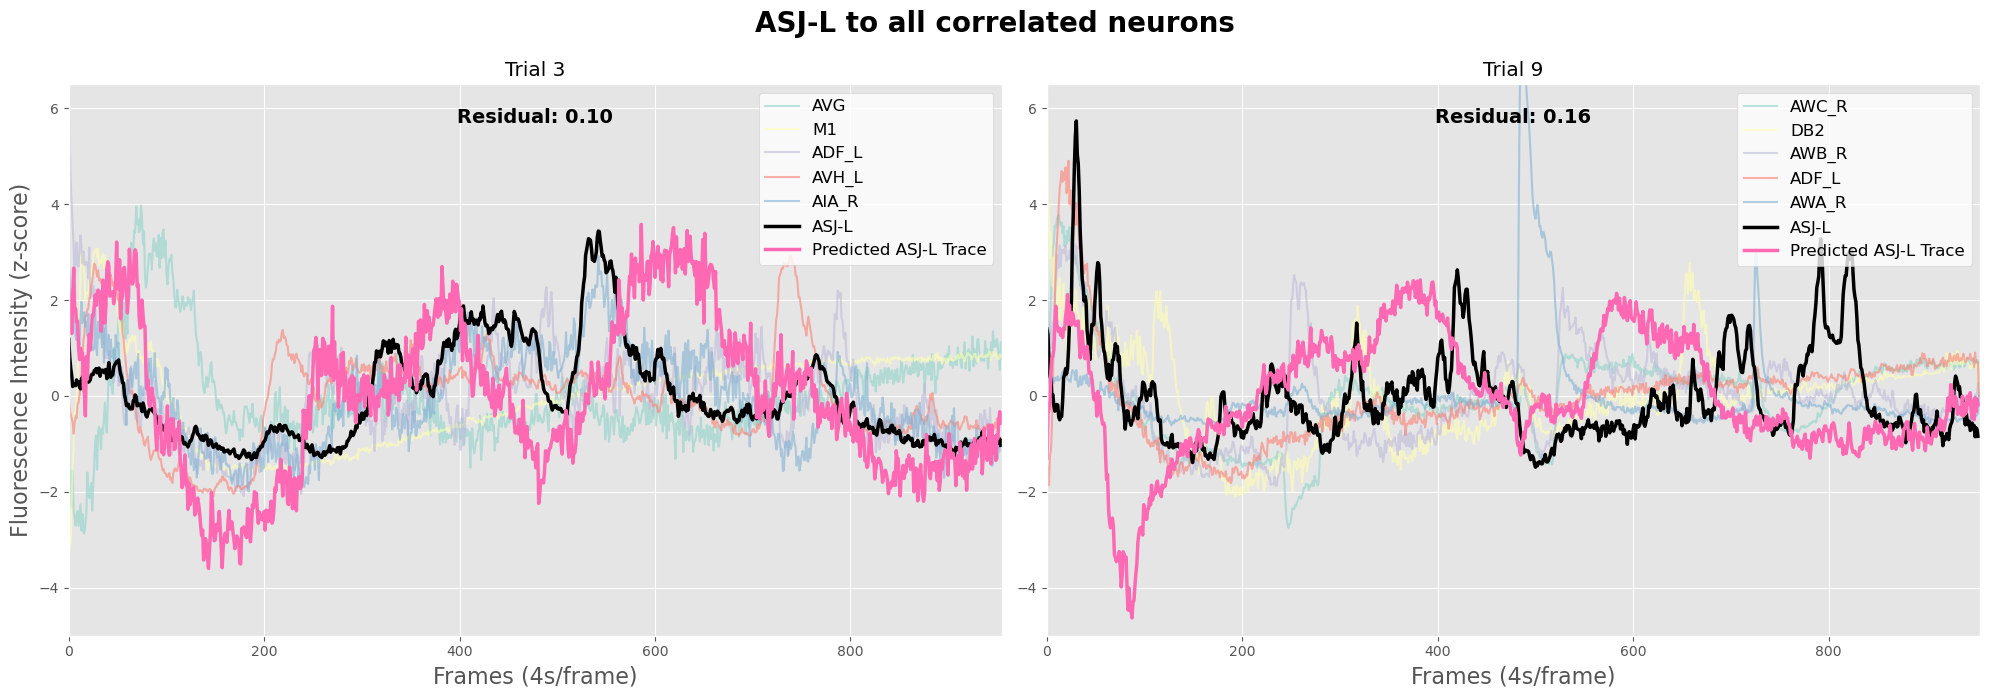

In [668]:
weights_L = [model.coef_ for model in regression_models_L]
# print(len(weights_L))  # This should now be equal to the length of ASJ_L_corrNeurons_linearRegression_NanFilled
# print(len(ASJ_L_corrNeurons_linearRegression_NanFilled))
residuals = []
NAMES_L = TEST_HIGHESTcorrelated_ASJL_STIMULI_names #a list of strings, which are the neuron names

# Calculate residuals for all trials
for trial in range(0,15):
    ASJ_L_trial_trace = ASJ_L_columnVectorsFiltered[trial]
    T = len(ASJ_L_trial_trace)
    raw_ASJ_L_trial = np.matmul(ASJ_L_corrNeurons_linearRegression_NanFilled, np.diag(weights_L[trial][0]))
    predicted_ASJ_L_trial = np.nansum(raw_ASJ_L_trial, axis = 1)

    min_length = min(len(predicted_ASJ_L_trial), len(ASJ_L_trial_trace))
    residual_value = np.sum((predicted_ASJ_L_trial[:min_length] - ASJ_L_trial_trace[:min_length])**2 / T) 
    residuals.append(residual_value)

# Get indices of six lowest residuals
lowest_Lesidual_indices = np.argsort(residuals)[:2]

# Create 3x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs = axs.flatten()

# Plot trials with lowest residuals
for i, trial in enumerate(lowest_Lesidual_indices):
    ax = axs[i]
    ASJ_L_trial_trace = ASJ_L_columnVectorsFiltered[trial]
    T = len(ASJ_L_trial_trace)
    raw_ASJ_L_trial = np.matmul(ASJ_L_corrNeurons_linearRegression_NanFilled, np.diag(weights_L[trial][0]))
    predicted_ASJ_L_trial = np.nansum(raw_ASJ_L_trial[0], axis = 1)
    
    if np.nansum(predicted_ASJ_L_trial) != 0:
        min_length = min(len(predicted_ASJ_L_trial), len(ASJ_L_trial_trace))
        residual_value = residuals[trial]

    highWeightNeuron_indices = np.argsort(weights[trial][0])[-5:]
    neuron_names = [NAMES_L[i] for i in highWeightNeuron_indices.tolist()] 
    neuron_names_str = ', '.join(neuron_names)

    ax.set_ylim(-5,6.5)
    for j in range(len(highWeightNeuron_indices)):
        ax.plot(ASJ_L_corrNeurons_linearRegression_NanFilled[trial][:,highWeightNeuron_indices[j]], color = palette[j], label = neuron_names[j], alpha = 0.6)

    plt.suptitle('ASJ-L to all correlated neurons', fontsize=20, weight = 'bold', y=0.99)
    ax.set_ylim(-5,6.5)
    ax.plot(ASJ_L_trial_trace, color = 'black', label = 'ASJ-L', linewidth = 2.5)
    ax.plot(predicted_ASJ_L_trial, color = 'hotpink', label = 'Predicted ASJ-L Trace', linewidth = 2.5)
    x_center = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2
    ax.text(x_center, ax.get_ylim()[1] - 0.5, f"Residual: {residual_value:.2f}", ha="center", va="top", weight = 'bold', fontsize = 14)
    # ax.text(ax.get_xlim()[0]+75, ax.get_ylim()[1] - 0.7, neuron_names_str, fontsize = 16, weight = 'bold')
    ax.legend(facecolor = 'white', loc = 'upper right', fontsize = 12)

    ax.set_xlim(0,955)
    if i in [0, 1]:  #last two
        ax.set_xlabel('Frames (4s/frame)', fontsize = 16)
    if i % 2 == 0:  #only odd
        ax.set_ylabel('Fluorescence Intensity (z-score)', fontsize = 16)
    ax.set_title(f'Trial {trial + 1}')

plt.tight_layout()
# plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/LinearRegression_ASJL_top2Trials.png", dpi = 900)
plt.show()


<font color='cyan' size = 8>Seeding the minimizer with the coeff's from the linear regression</font>

In [582]:
def Cost_function(weights, neuronTraces, ASJ_trace):
    T = len(neuronTraces) #955 - the number of frames
    Predicted_raw = np.matmul(neuronTraces, np.diag(weights)) # matrix multiplication to get product of neuron trace * weight of neuron
    Predicted_sum = np.nansum(Predicted_raw, axis =1) # summing across  columns
    min_length = min(len(Predicted_sum), len(ASJ_trace)) # in case some traces contain less frames than others 
    residual = np.sum((Predicted_sum[:min_length] - ASJ_trace[:min_length])**2 / T) # calculates the squared difference for every time point, and then divides by the frames/time points (955)
    return residual


def optimize_weights_LinearRegression(allNeuronTraces, ASJ_traces):
    optimal_weights_allTrials = []
    residuals_allTrials = []
    predicted_ASJ_traces_allTrials = []
    processed_trials_indices = []


    for trial in range(len(allNeuronTraces)):
        initial_weights = weights_L[2][0] #weights for the 27 neurons from trial 3 (lowest residual out of all of them)
        
        neuronTraces = allNeuronTraces[trial]
        ASJ_trace = ASJ_traces[trial]
        if (len(ASJ_trace) > 0): # ASJ contains some empty traces for a couple of trials
            result = minimize(Cost_function, initial_weights, args=(neuronTraces, ASJ_trace), method = 'L-BFGS-B')
            optimal_weights = result.x
            optimal_weights_allTrials.append(optimal_weights)
            residual = result.fun  # The final cost (residual) of the trial
            residuals_allTrials.append(residual) #the lowest calculated residual for a given trial after optimizing neuron weights
            Predicted_raw = np.matmul(neuronTraces, np.diag(optimal_weights)) #calculating the predicted ASJ trace using the optimal neuron weights with the lowest residual
            Predicted_sum = np.nansum(Predicted_raw, axis =1)
            predicted_ASJ_traces_allTrials.append(Predicted_sum)
            processed_trials_indices.append(trial)

    return optimal_weights_allTrials, residuals_allTrials, predicted_ASJ_traces_allTrials, processed_trials_indices

optimal_weights_ASJ_left_LinearRegression, optimal_residuals_allTrials_ASJ_left_LinearRegression, predicted_traces_ASJ_left_LinearRegression, processed_trials_indices_ASJ_L_LinearRegression= optimize_weights_LinearRegression(TEST_HIGHESTcorrelated_ASJL_STIMULI_traces, ASJ_L)

In [585]:
# Isolating lowest residual trials, and then best scoring neurons (highest weight), and plotting against ASJ
lowest_residuals_indices = np.argsort(optimal_residuals_allTrials_ASJ_left_LinearRegression)[:10] # add [::-1] to have in descending order
print(lowest_residuals_indices) 

#isolating neurons from lowest residual trial, and ASJ_R traces from lowest residual trials
lowest_residuals_neurons = [optimal_weights_ASJ_left_LinearRegression[i] for i in lowest_residuals_indices] # 10 arrays, each containing 229 values (weights of neurons)

# Must re-index to get the original trial indexes since the optimize function skips ASJ trials that are empty
lowest_residuals_original_indices = [processed_trials_indices_ASJ_L_LinearRegression[i] for i in lowest_residuals_indices]
print(lowest_residuals_original_indices)
lowest_residuals_original_indices_forINDEXING = np.array(lowest_residuals_original_indices)

# Getting corresponding traces for low residual trials for ASJ_L
ASJ_L_array = np.array(ASJ_L)
ASJ_L_filtered = np.array([trial for trial in ASJ_L_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing
lowest_residualTrials_ASJ_L = ASJ_L_filtered[lowest_residuals_indices]

#Getting corresponding traces for low residual trials from the MASTER list for all other neurons
lowest_residual_trials = TEST_HIGHESTcorrelated_ASJR_STIMULI_traces[lowest_residuals_original_indices_forINDEXING] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955x10 neurons and corresponding traces
 
#Getting the predicted ASJ_R traces from the optimize_weights function for the low residual trials 
predicted_ASJ_L_traces_lowestResidualTrials = [predicted_traces_ASJ_left_LinearRegression[i] for i in lowest_residuals_indices] # 2D array - first dimension is each of top scoring 10 trials (lowest residual), and then next is the 955 traces for the predicted ASJ_R


all_traces = []
all_names = []
for trial, weight in enumerate(lowest_residuals_neurons):
    highestWeightNeurons_w_lowestResiduals = np.argsort(weight)[-5:] #isolating indices of top 5 neurons that had the highest weights, within the top 10 lowest residual trials
    print(weight[-5:]) # the neurons do have weights associated with them... many are small though: <1
    
    # Get the corresponding traces and names for these neurons
    traces = lowest_residual_trials[trial, :, highestWeightNeurons_w_lowestResiduals] #lowest_residual_trials contains 10 matrices, each for a trial, of 955 rows by 187 neurons, and I need to isolate the top 5 scoring neurons (columns) and all of their traces!
    names = [TEST_HIGHESTcorrelated_ASJL_STIMULI_names[i] for i in highestWeightNeurons_w_lowestResiduals]

    # Add the traces and names for this trial to the overall lists
    all_traces.append(traces)
    all_names.append(names)

[14  7  1  8 12 10  6  4  0  3]
[16, 8, 1, 9, 14, 11, 6, 4, 0, 3]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]
[ 0.17864838  0.58922526  0.14733171  0.         -0.05766846]


/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/692363926.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ASJ_L_array = np.array(ASJ_L)
/var/folders/z5/5sg9bhn17hg_r7jh5xr4v22r0000gq/T/ipykernel_44064/692363926.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ASJ_L_filtered = np.array([trial for trial in ASJ_L_array if trial.size > 0]) #filtering out trials with empty arrays to ensure indexing


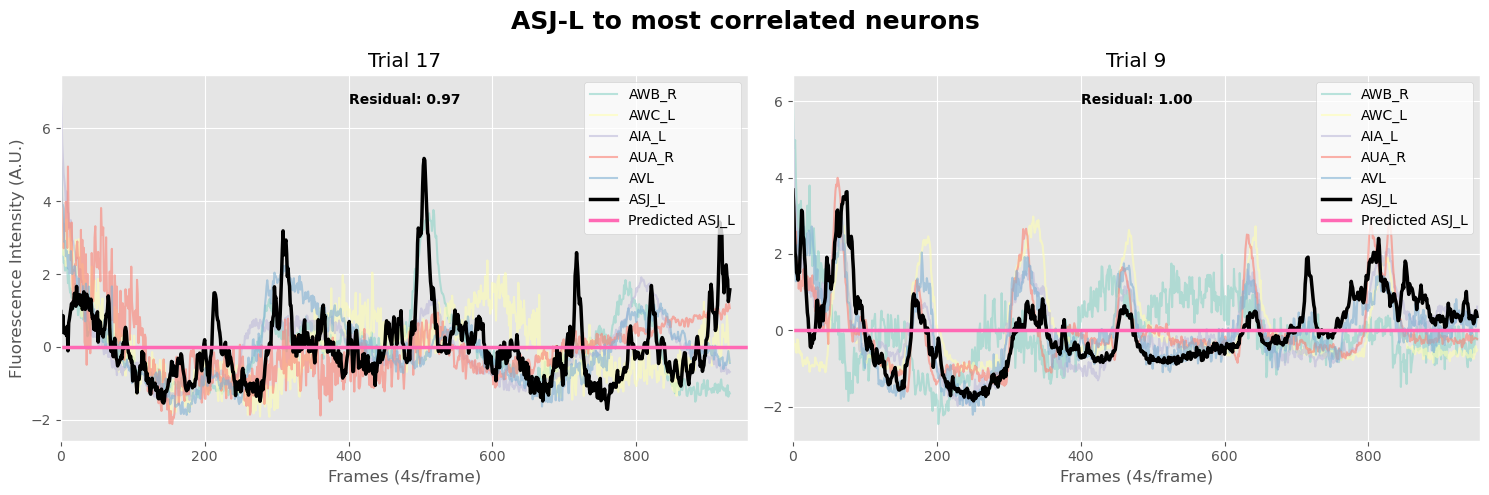

In [584]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("ASJ-L to all correlated neurons", fontsize = 18, weight = 'bold')

palette = sns.color_palette("Set3", 5) 

for i in range(2): #len(all_traces)
    ax = axs[i]
    # ax = axs[i // 2, i % 2] # a way to create subplot indices such as [0,0].... up unto [4,1] (5x2)

    for j in range(len(all_traces[i])):
        ax.plot(all_traces[i][j], label=all_names[i][j], color=palette[j], alpha = 0.6)

    ax.plot(lowest_residualTrials_ASJ_L[i], label='ASJ_L', color= 'black', linewidth = 2.5)
    ax.plot(predicted_ASJ_L_traces_lowestResidualTrials[i], label = 'Predicted ASJ_L', color = 'hotpink', linewidth = 2.5)

    residual_value = optimal_residuals_allTrials_ASJ_left_LinearRegression[lowest_residuals_indices[i]]
    ax.text(0.5, 0.95, f"Residual: {residual_value:.2f}", transform=ax.transAxes, ha="center", va="top", weight = 'bold') #plotting residual values for each trial, with two decimal places

    ax.set_title(f"Trial {lowest_residuals_original_indices[i] + 1}") #python indexes at 0
    ax.set_xlim(0,955)
    if i % 2 == 0: #only labeling odd plots (1,3,5,7,9)
        ax.set_ylabel("Fluorescence Intensity (z-score)")

    if i >= len(all_traces) - 2: #adding x-axis to last two plots (ax 9 and 10)
        ax.set_xlabel("Frames (4s/frame)")
    ax.set_xlabel("Frames (4s/frame)")
    ax.legend(facecolor = 'white', loc = 'upper right')

plt.tight_layout()
plt.subplots_adjust(top = 0.85)
# plt.savefig("/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/plots/ASJ_L_residual_trials_weightedNeurons_correlatedStimuliInclusive_TOP2.png", dpi = 900)
plt.show()